## ⚙️ Import Libraries

In [88]:
# Importing basic libraries
import os  # Library for interacting with the operating system (e.g., file and directory management)
from datetime import datetime  # Library for working with dates and times
import numpy as np  # Library for scientific computation and numerical array manipulation
import pandas as pd  # Library for data manipulation and analysis (DataFrame support)

# Importing libraries for machine learning and deep learning
import tensorflow as tf  # Deep learning framework
from tensorflow import keras as tfk  # High-level interface of TensorFlow for building models
from tensorflow.keras import layers as tfkl  # Modules for building neural networks layer by layer
from sklearn.model_selection import train_test_split  # Function for splitting data into train/test sets
from tensorflow.keras import metrics  # Modules for evaluating model performance (e.g., accuracy)

# Importing the library for visualization
import matplotlib.pyplot as plt  # Library for creating plots and visualizations

# Setting a seed to ensure reproducibility of results
seed = 42  # Chosen seed value
np.random.seed(seed)  # Set the seed for NumPy operations
tf.random.set_seed(seed)  # Set the seed for TensorFlow operations

## ⏳ Load the Data


In [89]:
# Loading data from a .npz file (compressed NumPy format)
data = np.load("/kaggle/input/homework2/mars_for_students.npz")  # Load the data file from the specified directory

# Extracting the training set from the loaded file
training_set = data["training_set"]  # Retrieve the training set from the .npz file

# Splitting the training set into features (X) and labels (y)
X_train_import = training_set[:, 0]  # Extract the first column of the training set (input features)
y_train_import = training_set[:, 1]  # Extract the second column of the training set (output labels)

# Extracting the test set
X_test = data["test_set"]  # Retrieve the test set from the .npz file

# Printing the dimensions of the training and test data to verify their shapes
print(f"Training X shape: {X_train_import.shape}")  # Print the shape of the training features
print(f"Training y shape: {y_train_import.shape}")  # Print the shape of the training labels
print(f"Test X shape: {X_test.shape}")  # Print the shape of the test features


Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


## 👽 Remove outliers

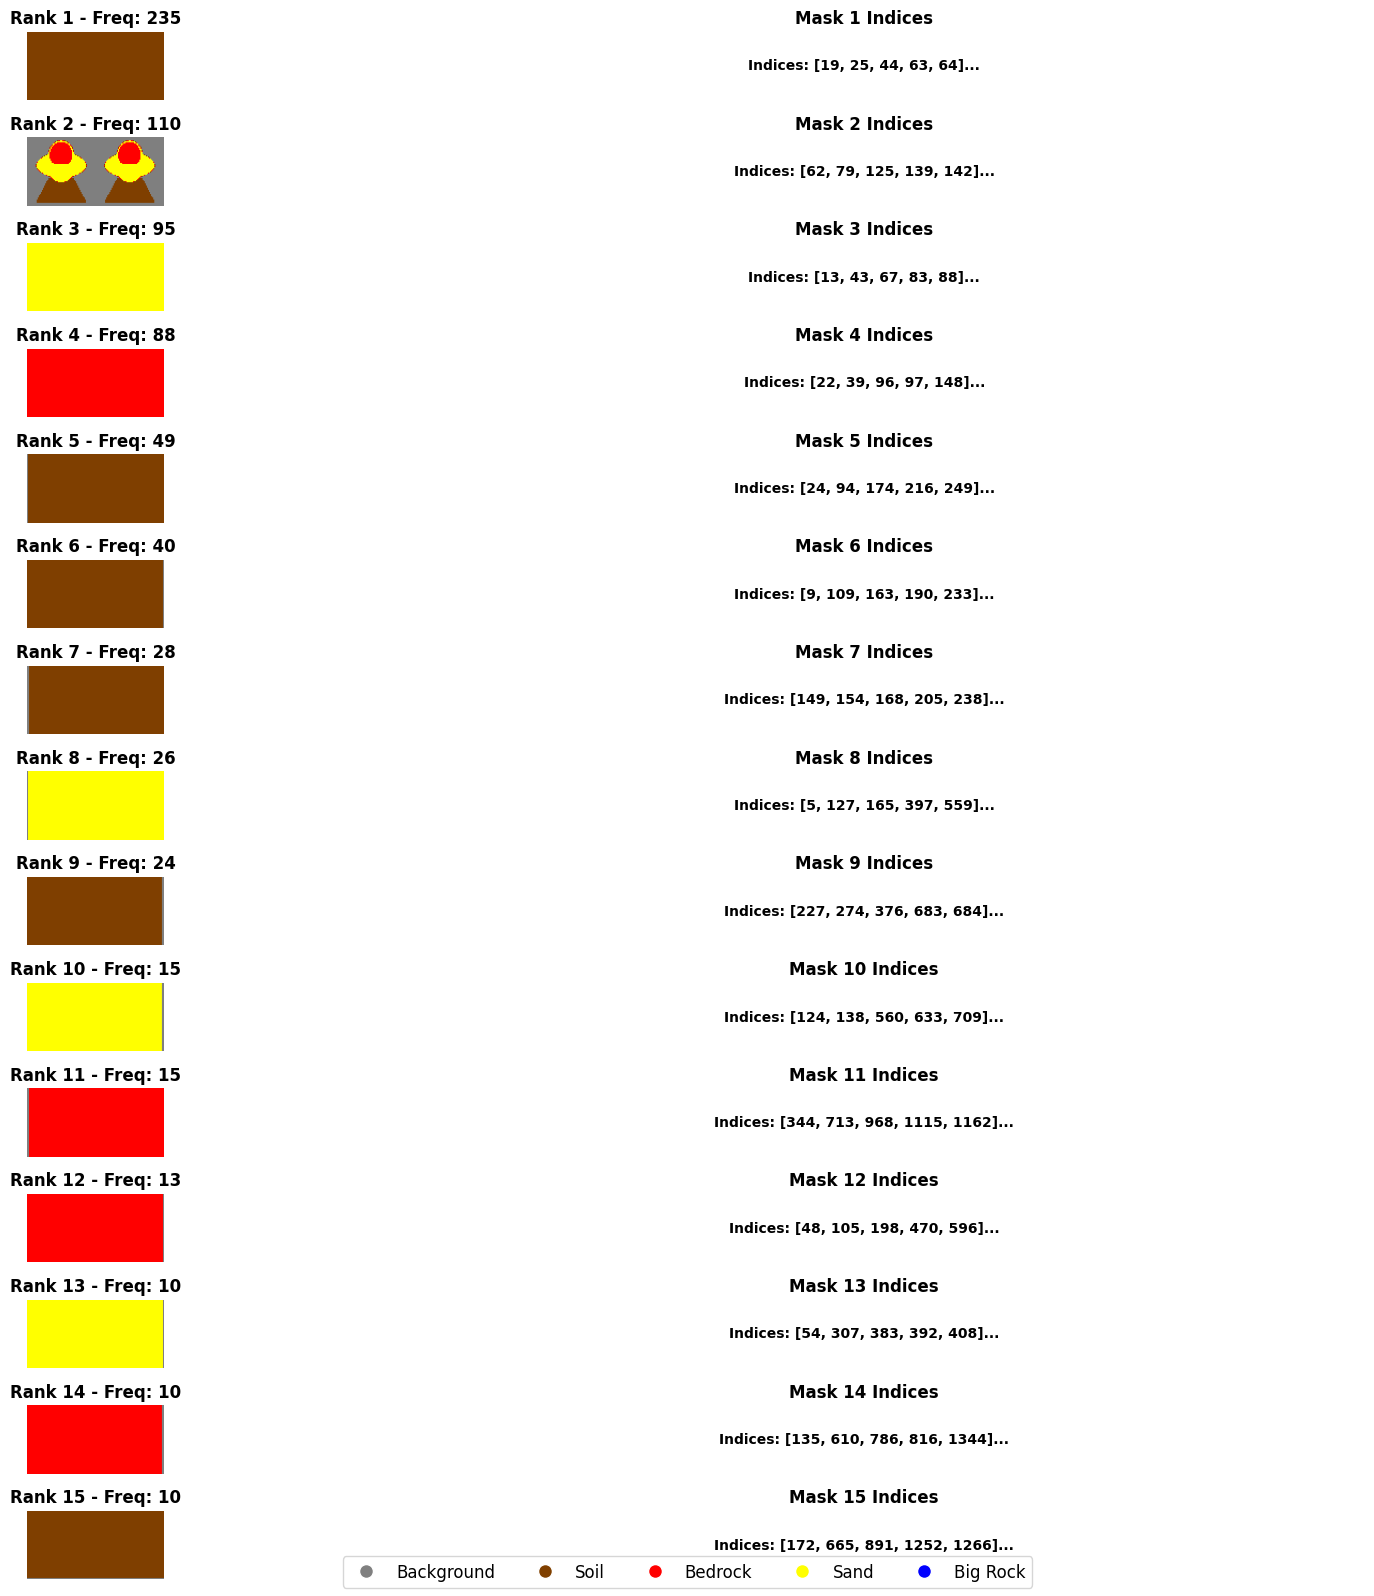

In [90]:
import hashlib  # Library for hashing (e.g., SHA-256)

def find_most_common_masks(label, top_n=15):
    """
    Finds the most common masks in the dataset.

    Args:
        label (numpy.ndarray): Array of masks.
        top_n (int): Number of top most common masks to return.

    Returns:
        list: A list of tuples containing the mask hash, count, and indices where it appears.
    """
    # Initialize a dictionary to store mask hashes and their information
    hash_map = {}

    # Iterate through all masks in the dataset
    for idx, mask in enumerate(label):
        # Convert mask to immutable bytes representation and compute its SHA-256 hash
        mask_bytes = mask.tobytes()
        mask_hash = hashlib.sha256(mask_bytes).hexdigest()

        # Add the hash to the dictionary if not already present
        if mask_hash not in hash_map:
            hash_map[mask_hash] = {"count": 0, "indices": []}

        # Update the count and store the index of the mask
        hash_map[mask_hash]["count"] += 1
        hash_map[mask_hash]["indices"].append(idx)

    # Sort masks by frequency in descending order
    sorted_masks = sorted(hash_map.items(), key=lambda x: x[1]["count"], reverse=True)

    # Return the top_n most common masks
    return [
        (mask_hash, data["count"], data["indices"])
        for mask_hash, data in sorted_masks[:top_n]
    ]


def plot_most_common_masks(y_val, most_common_masks, num_to_show=10):
    """
    Visualizes the most common masks with their occurrence frequency and a legend for class labels.

    Args:
        y_val (numpy.ndarray): Dataset of masks.
        most_common_masks (list): List of tuples (hash, count, indices) representing common masks.
        num_to_show (int): Number of masks to visualize (default is 10).
    """
    # Define the colormap for each class
    class_colormap = {
        0: (0.5, 0.5, 0.5),  # Gray for Background
        1: (0.5, 0.25, 0),   # Brown for Soil
        2: (1, 0, 0),        # Red for Bedrock
        3: (1, 1, 0),        # Yellow for Sand
        4: (0, 0, 1),        # Blue for Big Rock
    }

    # Define class labels
    class_labels = {
        0: 'Background',
        1: 'Soil',
        2: 'Bedrock',
        3: 'Sand',
        4: 'Big Rock',
    }

    # Helper function to apply the colormap to a mask
    def apply_colormap(mask):
        """
        Applies a custom colormap to the mask.

        Args:
            mask (numpy.ndarray): Input mask.

        Returns:
            numpy.ndarray: RGB image with the colormap applied.
        """
        colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3))  # Create RGB image
        for class_id, color in class_colormap.items():
            colored_mask[mask == class_id] = color
        return colored_mask

    # Create a larger plot for better visualization
    plt.figure(figsize=(18, 16))

    # Loop through the most common masks and visualize them
    for rank, (mask_hash, count, indices) in enumerate(most_common_masks[:num_to_show], start=1):
        mask = y_val[indices[0]]  # Take the first mask from the list of indices
        colored_mask = apply_colormap(mask)  # Apply the colormap

        # Plot the mask
        plt.subplot(num_to_show, 2, rank * 2 - 1)
        plt.imshow(colored_mask)
        plt.title(f"Rank {rank} - Freq: {count}", fontsize=12, fontweight='bold')
        plt.axis('off')

        # Plot the indices of the mask
        plt.subplot(num_to_show, 2, rank * 2)
        plt.text(0.5, 0.5, f"Indices: {indices[:5]}...", ha='center', va='center', fontsize=10, fontweight='bold')
        plt.title(f"Mask {rank} Indices", fontsize=12, fontweight='bold')
        plt.axis('off')

    # Add a legend at the bottom
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in class_colormap.values()]
    labels = [class_labels[i] for i in class_colormap.keys()]
    plt.figlegend(handles, labels, loc='lower center', ncol=5, fontsize=12)

    # Optimize layout and show the plot
    plt.tight_layout()
    plt.show()


# Find the 15 most common masks
most_common_masks = find_most_common_masks(y_train_import, top_n=15)

# Visualize the 15 most common masks
plot_most_common_masks(y_train_import, most_common_masks, num_to_show=15)


In [91]:
# Find the indices of the outliers (second most common mask in this case)
outlier_indices = most_common_masks[1][2]

# Remove the outliers from the training features (X_train) and labels (y_train)
X_cleaned = np.delete(X_train_import, outlier_indices, axis=0)  # Remove rows corresponding to outliers
y_cleaned = np.delete(y_train_import, outlier_indices, axis=0)  # Remove labels corresponding to outliers

# Check the dimensions of the cleaned dataset
print(f"New X_cleaned shape: {X_cleaned.shape}")  # Display the shape of the cleaned features
print(f"New y_cleaned shape: {y_cleaned.shape}")  # Display the shape of the cleaned labels


New X_cleaned shape: (2505, 64, 128)
New y_cleaned shape: (2505, 64, 128)


## 📊Split in Train and Validation


In [92]:

# Split the cleaned training dataset into training and validation sets
X_train_splitted, X_val_splitted, y_train, y_val = train_test_split(
    X_cleaned,     # Features after removing outliers
    y_cleaned,     # Labels after removing outliers
    test_size=0.2, # Allocate 20% of the data for validation
    random_state=seed # Ensure reproducibility with a fixed random seed
)


In [93]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train_splitted[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0
X_val = X_val_splitted[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))

print(f"Input shape: {X_train.shape[1:]}")
print(f"Validation shape: {X_val.shape[1:]}")
print(f"Number of classes: {num_classes}")

Training set size: 2004
Validation set size: 501
Input shape: (64, 128, 1)
Validation shape: (64, 128, 1)
Number of classes: 5


## 🖼️ Visualize Images

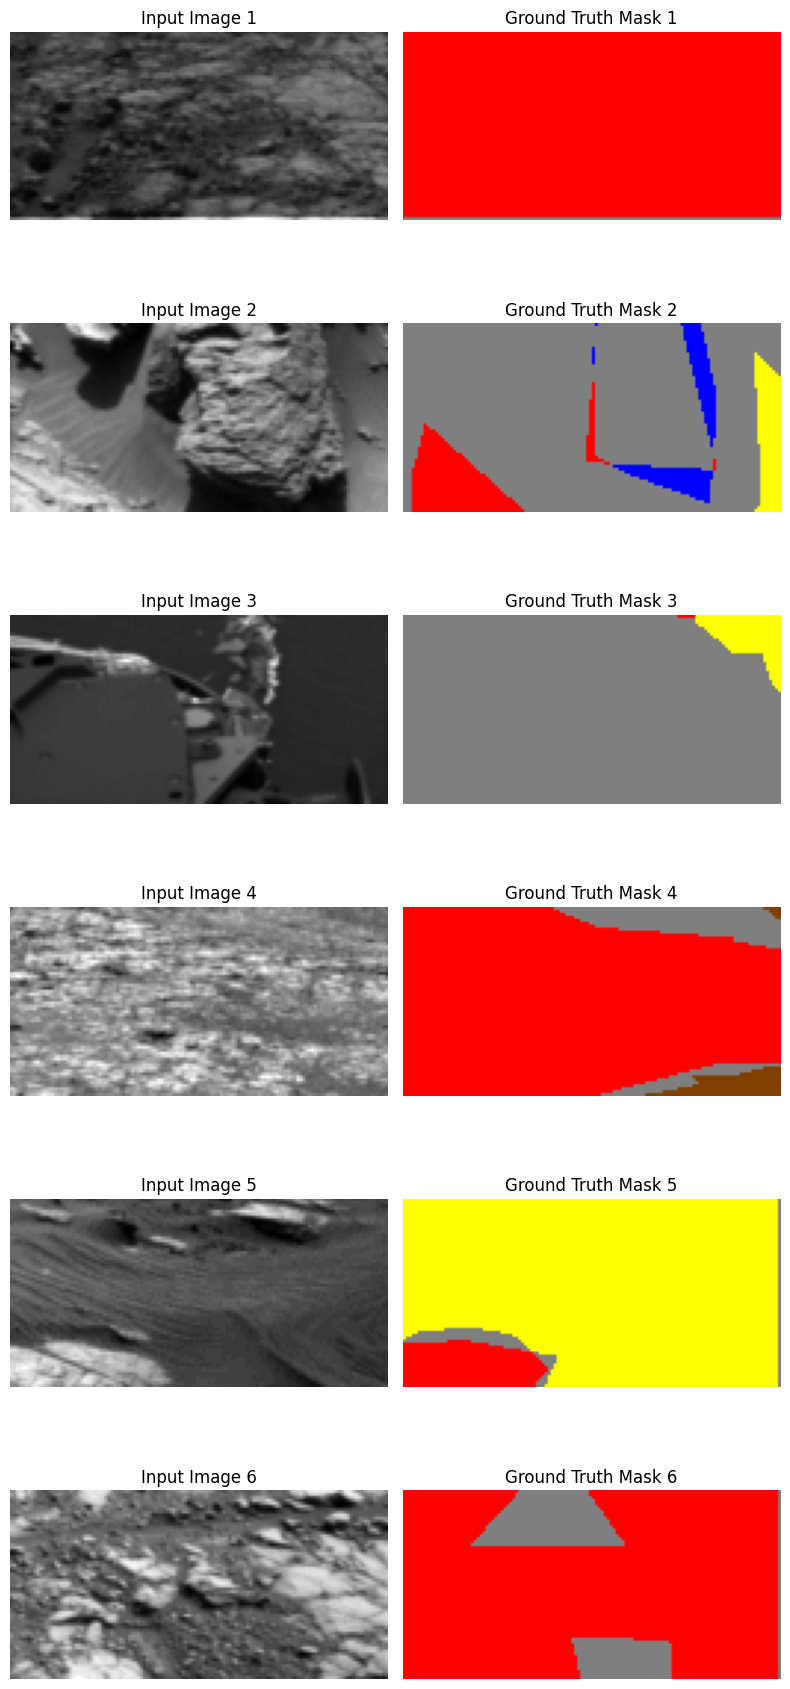

In [94]:
def plot_images_with_masks(X_val, y_val, num_images=3, fixed_indices=None):
    """
    Function to visualize images with their corresponding masks.

    Args:
        X_val (numpy.ndarray): Dataset of images.
        y_val (numpy.ndarray): Corresponding masks.
        num_images (int): Number of images to visualize.
        fixed_indices (list): Optional indices of images to visualize.
    """

    # If no fixed indices are provided, randomly select a subset of images
    if fixed_indices is None:
        indices = np.random.choice(len(X_val), size=num_images, replace=False)  # If no fixed indices, choose randomly
    else:
        indices = fixed_indices  # Use provided indices if specified

    # Custom colors for each class (Background, Soil, Bedrock, Sand, Big Rock)
    class_colormap = {
        0: (0.5, 0.5, 0.5),  # Gray for Background
        1: (0.5, 0.25, 0),   # Brown for Soil
        2: (1, 0, 0),        # Red for Bedrock
        3: (1, 1, 0),        # Yellow for Sand
        4: (0, 0, 1),        # Blue for Big Rock
    }

    # Function to apply custom colormap to the mask
    def apply_colormap(mask, class_colors):
        """
        Applies predefined colors to the classes in the mask.

        Args:
            mask (numpy.ndarray): The mask to be colored.
            class_colors (dict): Color mapping for each class.

        Returns:
            numpy.ndarray: Colored mask.
        """
        # Create an empty RGB image (with 3 channels for color)
        colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.float32)

        # Apply colors for each class (0, 1, 2, 3, 4)
        for class_id, color in class_colors.items():
            colored_mask[mask == class_id] = color  # Add the color where the class matches

        return colored_mask

    # Create a figure for the plot with larger dimensions based on the number of images
    plt.figure(figsize=(8, 3 * num_images))  # Figure size depends on the number of images to visualize

    # Loop through selected indices to visualize images and their respective masks
    for i, idx in enumerate(indices):

        # Get the image and the corresponding mask for the index
        image = X_val[idx]
        mask = y_val[idx]

        # Plot the image (first column)
        plt.subplot(num_images, 2, i * 2 + 1)
        plt.imshow(image.squeeze(), cmap='gray')  # Display the image in grayscale
        plt.title(f"Input Image {i+1}")  # Title with the image index
        plt.axis('off')  # Hide axes for cleaner visualization

        # Plot the mask with custom colormap (second column)
        plt.subplot(num_images, 2, i * 2 + 2)
        colored_mask = apply_colormap(mask, class_colormap)  # Apply colormap to the mask
        plt.imshow(colored_mask)  # Display the colored mask
        plt.title(f"Ground Truth Mask {i+1}")  # Title with the mask index
        plt.axis('off')  # Hide axes for cleaner visualization

    # Optimize layout to avoid overlaps
    plt.tight_layout()

    # Show the plot
    plt.show()

# Run the plot for the first 6 images (you can change the number as desired)
plot_images_with_masks(X_train, y_train, num_images=6)


## ⏳ Load and Process Data

In [95]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 0.001

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 500

In [96]:
num_classes = 5  # Replace with the actual number of classes
y_flat = y_cleaned.flatten().astype(int)   # Flatten the label array to count pixels

# Count the frequency of each class
class_counts = np.bincount(y_flat, minlength=num_classes)  # Count occurrences of each class ID

# Calculate inverse weights (Option 1: inverse of the frequency)
class_weights = 1.0 / (class_counts + 1e-6)  # Add a small value to avoid division by zero

# Normalize the weights (Option 2: make the total sum of weights equal to 1)
class_weights = class_weights / np.sum(class_weights)  # Scale weights so their sum is 1
class_weights[0] *= 0.05  # Optionally, reduce the weight for the background class

# Print the results for verification
print("Class counts:", class_counts)  # Display the number of pixels for each class
print("Class weights:", class_weights)  # Display the computed weights for each class


Class counts: [4988826 6957538 4776810 3770823   26963]
Class weights: [2.64397339e-04 3.79166400e-03 5.52264929e-03 6.99599168e-03
 9.78401748e-01]


## 🤖 Define the Model

In [97]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    
    x = input_tensor

    # Builds a convolution block with 'stack' convolutions.
    for i in range(stack):
        # 2D convolution with the specified number of filters and kernel size.
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        
        # Adds batch normalization to stabilize training.
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        
        # Adds activation function (e.g., ReLU) to introduce non-linearity.
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # If the number of channels in the input is equal to the filters, add a residual connection
    # between the input and the output of the block.
    if input_tensor.shape[-1] == filters:
        x = tfkl.Add(name=name + 'residual')([x, input_tensor])

    return x

def squeeze_and_excite_block(input_tensor, ratio=24, name=''):
    
    # Get the number of filters (channels) in the input.
    filters = input_tensor.shape[-1]
    
    # Global average pooling: reduces each channel to a single value.
    se = tfkl.GlobalAveragePooling2D(name=name + 'se_gap')(input_tensor)
    
    # Excitation phase: reduces the number of filters through a dense (fully connected) layer.
    se = tfkl.Dense(filters // ratio, activation='relu', name=name + 'se_fc1')(se)
    
    # Restore the original filter size.
    se = tfkl.Dense(filters, activation='sigmoid', name=name + 'se_fc2')(se)
    
    # Reshape to bring the size back to (1, 1, filters).
    se = tfkl.Reshape((1, 1, filters), name=name + 'se_reshape')(se)
    
    # Multiply the input by the calculated weight (from squeeze and excite).
    return tfkl.Multiply(name=name + 'se_multiply')([input_tensor, se])


def unet_branch(input_layer, filters, num_classes, name_prefix):
    
    # First down-sampling block
    down_block_1 = unet_block(input_layer, filters, name=name_prefix + 'down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    # Second down-sampling block
    down_block_2 = unet_block(d1, filters * 2, name=name_prefix + 'down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck: a bottleneck layer for more compact representation
    bottleneck = unet_block(d2, filters * 4, name=name_prefix + 'bottleneck_')

    # Add Dropout for regularizing the bottleneck
    bottleneck = tf.keras.layers.Dropout(0.1, name=name_prefix + 'bottleneck_dropout')(bottleneck)
 
    # Apply the squeeze-and-excite block to the bottleneck to weigh the channels
    bottleneck = squeeze_and_excite_block(bottleneck, name=name_prefix + 'bottleneck_se_')

    # First up-sampling block
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = unet_block(u1, filters * 2, name=name_prefix + 'up_block1_')

    # Second up-sampling block
    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, filters, name=name_prefix + 'up_block2_')

    # Final layer for classification with the number of classes
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name=name_prefix + 'output_layer')(u2)

    return output_layer


def get_combined_unet_model(input_shape=(64, 128, 1), num_classes=5, seed=42):
    
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Create two separate U-Net branches
    branch_1_output = unet_branch(input_layer, 32, num_classes, name_prefix='branch1_')
    branch_2_output = unet_branch(input_layer, 32, num_classes, name_prefix='branch2_')

    # Combine the two branches by concatenation
    combined = tfkl.Concatenate(name='combined_branches')([branch_1_output, branch_2_output])
    
    # Final classification layer
    final_output = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='final_output_layer')(combined)

    # Create the final model
    model = tf.keras.Model(inputs=input_layer, outputs=final_output, name='Combined_UNet')
    return model


Model: "Combined_UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ branch1_down_blo… │ (None, 64, 128, │       320 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ branch2_down_blo… │ (None, 64, 128, │       320 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ branch1_down_blo… │ (None, 64, 128, │       128 │ branch1_down_… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ branch2_down_blo… │ (None, 64, 128, │       128 │ branch2_down_… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ branch1_down_blo… │ (None, 64, 128, │         0 │ branch1_down_… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ branch2_down_blo… │ (None, 64, 128, │         0 │ branch2_down_… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ branch1_down_blo… │ (None, 64, 128, │     9,248 │ branch1_down_… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ branch2_down_blo… │ (None, 64, 128, │     9,248 │ branch2_down_… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ branch1_down_blo… │ (None, 64, 128, │       128 │ branch1_down_… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ branch2_down_blo… │ (None, 64, 128, │       128 │ branch2_down_… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ branch1_down_blo… │ (None, 64, 128, │         0 │ branch1_down_… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ branch2_down_blo… │ (None, 64, 128, │         0 │ branch2_down_… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_20  │ (None, 32, 64,  │         0 │ branch1_down_… │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_22  │ (None, 32, 64,  │         0 │ branch2_down_… │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ branch1_down_blo… │ (None, 32, 64,  │    18,496 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ branch2_down_blo… │ (None, 32, 64,  │    18,496 │ max_pooling2d… │   Y 

 Total params: 950,219 (3.62 MB)

 Trainable params: 947,659 (3.62 MB)

 Non-trainable params: 2,560 (10.00 KB)

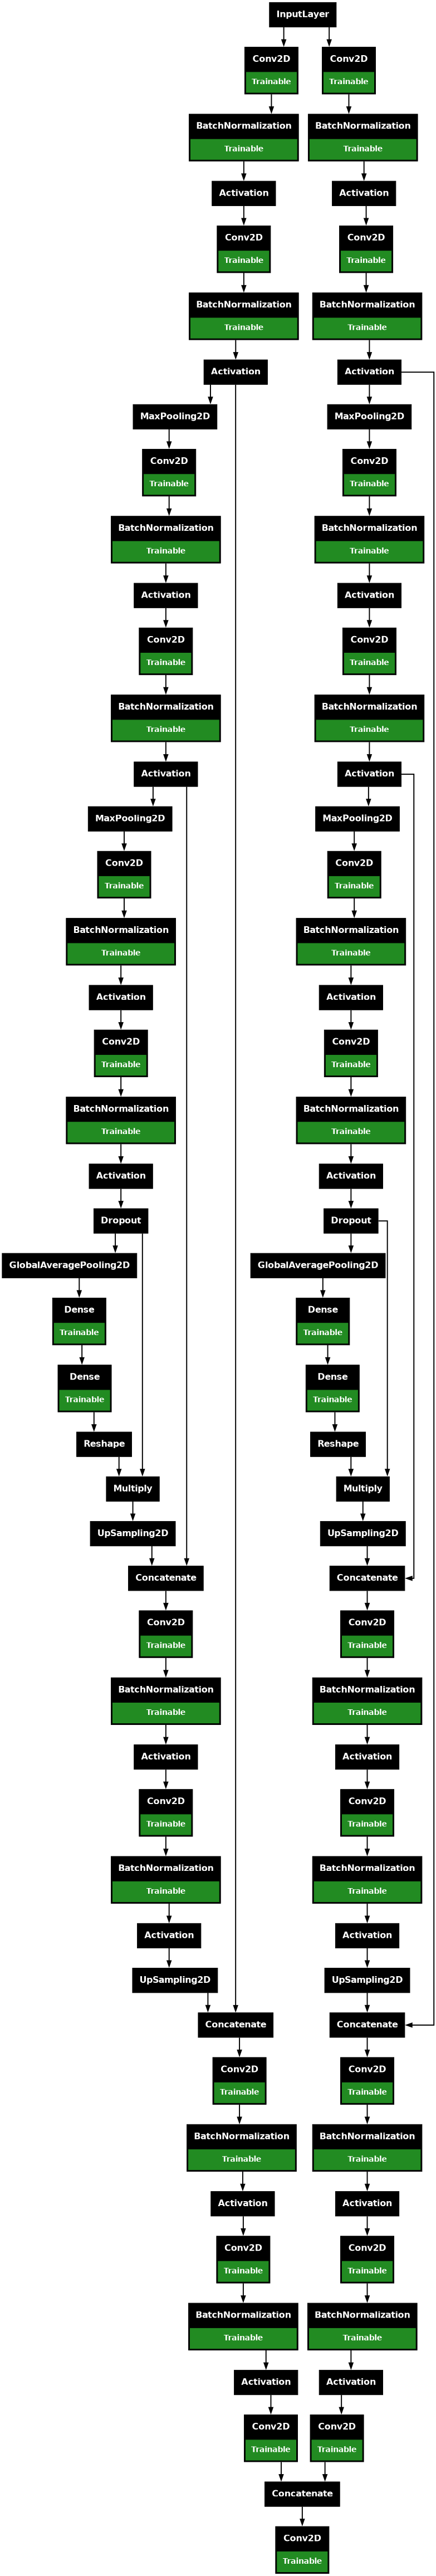

In [98]:

model = get_combined_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architectur
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [99]:
def augment_image_and_mask(image, mask, target_size=(64, 128)):

    # Convert image and mask to float32 for concatenation
    image = tf.cast(image, dtype=tf.float32)  # Convert the image to float32
    mask = tf.cast(mask, dtype=tf.float32)  # Convert the mask to float32 for concatenation

    # Combine image and mask for consistent transformation
    combined = tf.concat([image, tf.expand_dims(mask, axis=-1)], axis=-1)

    # Perform some geometric transformations
    combined = tf.image.random_flip_left_right(combined)  # Horizontal flip
    combined = tf.image.random_flip_up_down(combined)  # Vertical flip

    # Separate image and mask after transformation
    image = combined[:, :, :-1]  # All channels except the last one (image)
    
    # Convert the mask back to int32 after separating
    mask = combined[:, :, -1]  # Mask as the last part of the image
    mask = tf.cast(tf.round(mask), dtype=tf.int32)  # Round and convert to int32
    
    return image, mask


# Function for training data preprocessing
def preprocess_training_data(image, mask):

    # image, mask = augment_image_and_mask(image, mask)  # Apply augmentation (commented out here)
    return image, mask


# Apply to the training dataset
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(

    lambda img, msk: preprocess_training_data(img, msk),
    num_parallel_calls=AUTOTUNE

).batch(BATCH_SIZE).prefetch(AUTOTUNE)


# Validation dataset (without augmentation)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [100]:
import matplotlib.colors as mcolors


# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):

    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)

        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0

        self.labels_to_exclude = labels_to_exclude



    def update_state(self, y_true, y_pred, sample_weight=None):

        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)



class VizCallback(tf.keras.callbacks.Callback):

    def __init__(self, X_val, y_val, fixed_indices=None, frequency=5, number=3):

        super().__init__()
        
        self.X_val = X_val  # Validation images
        self.y_val = y_val  # Validation masks

        self.frequency = frequency  # Frequency of visualization (in epochs)

        self.number = number  # Number of images to visualize per epoch

        # If no fixed indices are provided, randomly select a fixed subset
        if fixed_indices is None:
            self.fixed_indices = np.random.choice(len(self.X_val), size=self.number, replace=False)
        else:
            self.fixed_indices = fixed_indices

    def on_epoch_end(self, epoch, logs=None):

        # Display results only every 'frequency' epochs
        if epoch % self.frequency == 0:
            plt.figure(figsize=(16, 4 * self.number))  # Increase figure size for better readability

            # Define a custom colormap for the masks (not for the grayscale image)
            class_colormap = mcolors.ListedColormap([
                (0.5, 0.5, 0.5),  # Gray for Background
                (0.5, 0.25, 0),   # Brown for Soil
                (1, 0, 0),        # Red for Bedrock
                (1, 1, 0),        # Yellow for Sand
                (0, 0, 1)         # Blue for Big Rock
            ])

            # Loop over the selected fixed indices to visualize
            for i, idx in enumerate(self.fixed_indices):
                image = self.X_val[idx]  # Get image from validation set
                label = self.y_val[idx]  # Get corresponding mask from validation set

                # Prediction
                image_expanded = np.expand_dims(image, axis=0)  # Expand dimensions for the model input
                pred = self.model.predict(image_expanded, verbose=0)  # Get model prediction
                y_pred = tf.math.argmax(pred, axis=-1).numpy()[0]  # Get the predicted class labels

                row_offset = i * 3  # Row offset for plotting the image, ground truth, and prediction

                # Display the input image (using cmap='gray' for grayscale images)
                plt.subplot(self.number, 3, row_offset + 1)
                plt.imshow(image.squeeze(), cmap='gray')  # Show grayscale image
                plt.title(f"Input Image {i+1}")
                plt.axis('off')

                # Display ground truth mask (using the custom colormap for masks)
                plt.subplot(self.number, 3, row_offset + 2)
                plt.imshow(label, cmap=class_colormap)  # Show ground truth mask with custom colormap
                plt.title(f"Ground Truth Mask {i+1}")
                plt.axis('off')

                # Display predicted mask (using the same custom colormap)
                plt.subplot(self.number, 3, row_offset + 3)
                plt.imshow(y_pred, cmap=class_colormap)  # Show predicted mask with custom colormap
                plt.title(f"Predicted Mask {i+1}")
                plt.axis('off')

            plt.tight_layout()  # Optimize space between subplots
            plt.show()  # Display the plots
            plt.close()  # Close the plot to free memory


In [101]:
from tensorflow.keras import backend as K

class CustomLoss(tfk.Loss):

    def __init__(self, alpha=0.25, gamma=2.0, name="categorical_focal_loss"):
        super(CustomLoss, self).__init__(name=name)

        self.class_weights = tf.constant(class_weights, dtype=tf.float32)
        
        self.alpha = alpha

        self.gamma = gamma

    def call(self, y_true, y_pred):
 
        axis_to_reduce = range(1, K.ndim(y_pred))

        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])

        #DiceLoss
        numerator = y_true_one_hot * y_pred * self.class_weights  # Broadcasting
        
        numerator = 2. * K.sum(numerator, axis=axis_to_reduce)

        denominator = (y_true_one_hot + y_pred) * self.class_weights # Broadcasting
        
        denominator = K.sum(denominator, axis=axis_to_reduce)

        dice_loss = 1 - numerator / denominator
        
        #FocalLoss
        gamma = tf.constant(2.0)
        
        f_loss = - 1e3 *(class_weights * (1-y_pred)**gamma * y_true_one_hot * K.log(y_pred))

        # Average over each data point/image in batch
        axis_to_reduce = range(1, K.ndim(f_loss))
        f_loss = K.mean(f_loss, axis=axis_to_reduce)

        return f_loss + dice_loss


In [102]:
# Compile the model
print("Compiling model...")

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3),
    loss=CustomLoss(class_weights),
    metrics=['accuracy', MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)

print("Model compiled!")

Compiling model...
Model compiled!


In [103]:
# Setup callbacks

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',       
    factor=0.5,             
    patience=10,                
    verbose=1,                  
    min_lr=1e-5                 
    )

viz_callback = VizCallback(X_val, y_val)

## 🛠️ Train and Save the Model

Epoch 1/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.2615 - loss: 1.8802 - mean_iou: 0.1605

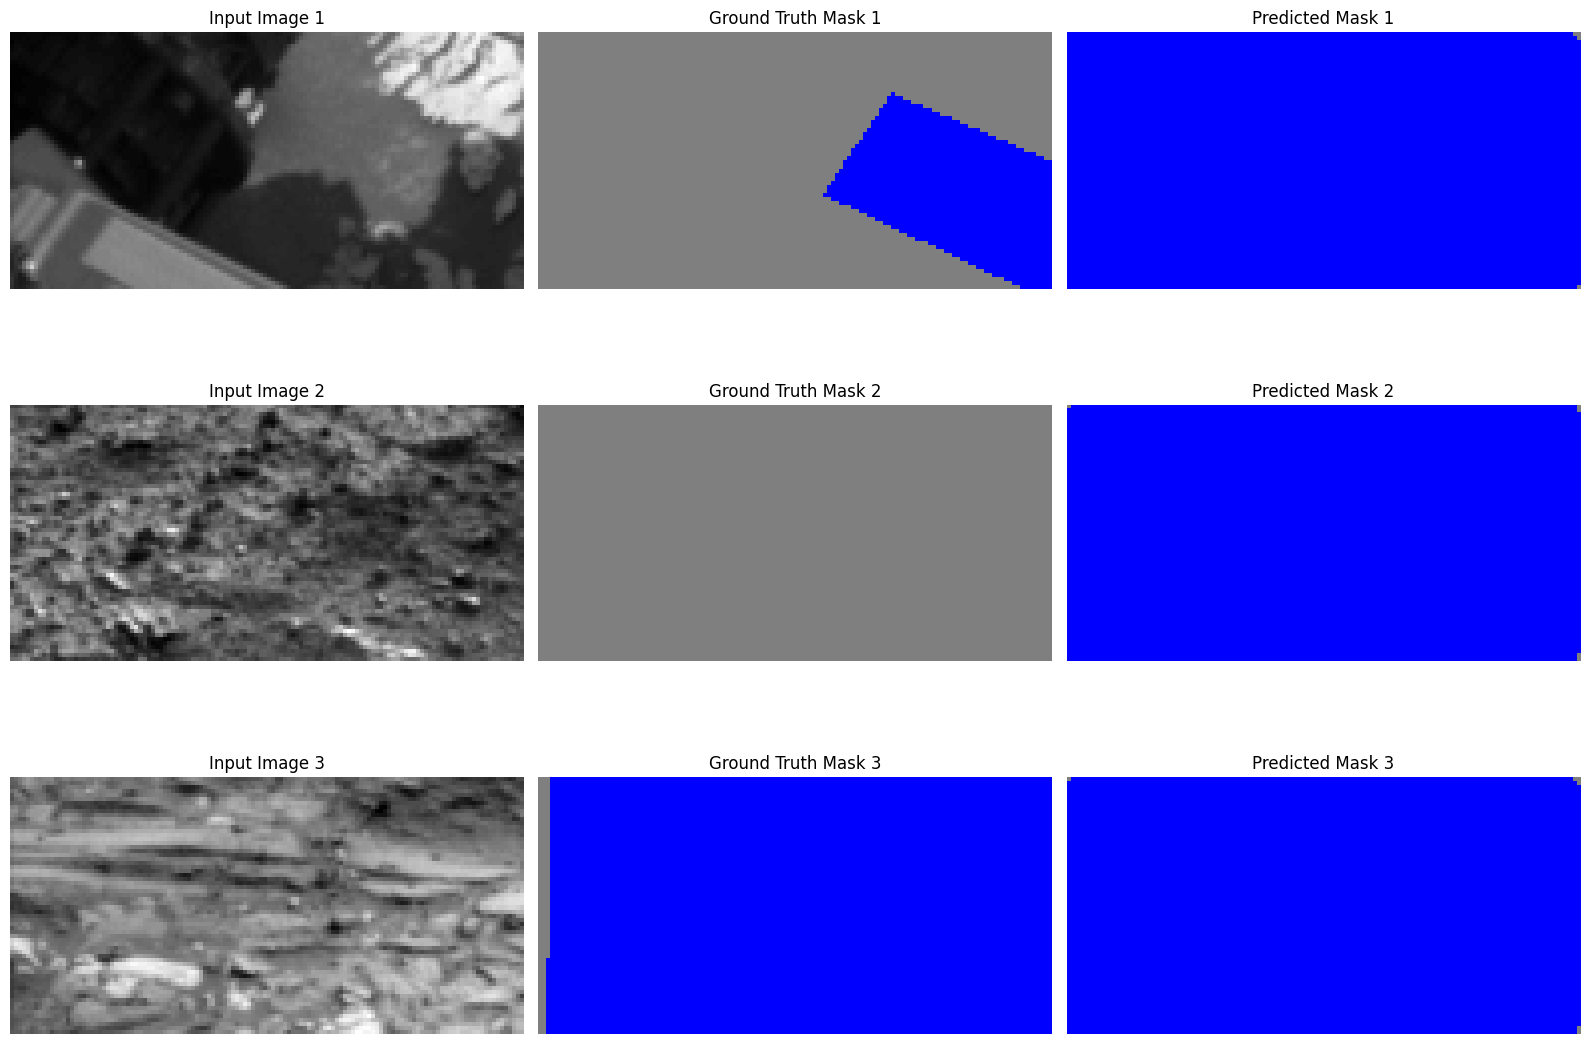

32/32 ━━━━━━━━━━━━━━━━━━━━ 54s 873ms/step - accuracy: 0.2625 - loss: 1.8796 - mean_iou: 0.1615 - val_accuracy: 0.1979 - val_loss: 2.0905 - val_mean_iou: 0.0657 - learning_rate: 0.0010
Epoch 2/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.3268 - loss: 1.7592 - mean_iou: 0.2325 - val_accuracy: 0.1979 - val_loss: 2.1716 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 3/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.3998 - loss: 1.7091 - mean_iou: 0.3018 - val_accuracy: 0.1979 - val_loss: 2.1678 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 4/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.4415 - loss: 1.6431 - mean_iou: 0.3392 - val_accuracy: 0.1979 - val_loss: 2.1732 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 5/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.4405 - loss: 1.6275 - mean_iou: 0.3427 - val_accuracy: 0.1979 - val_loss: 2.1826 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 6/500
31/32 ━━━━━━━━━━━━━━━━━━

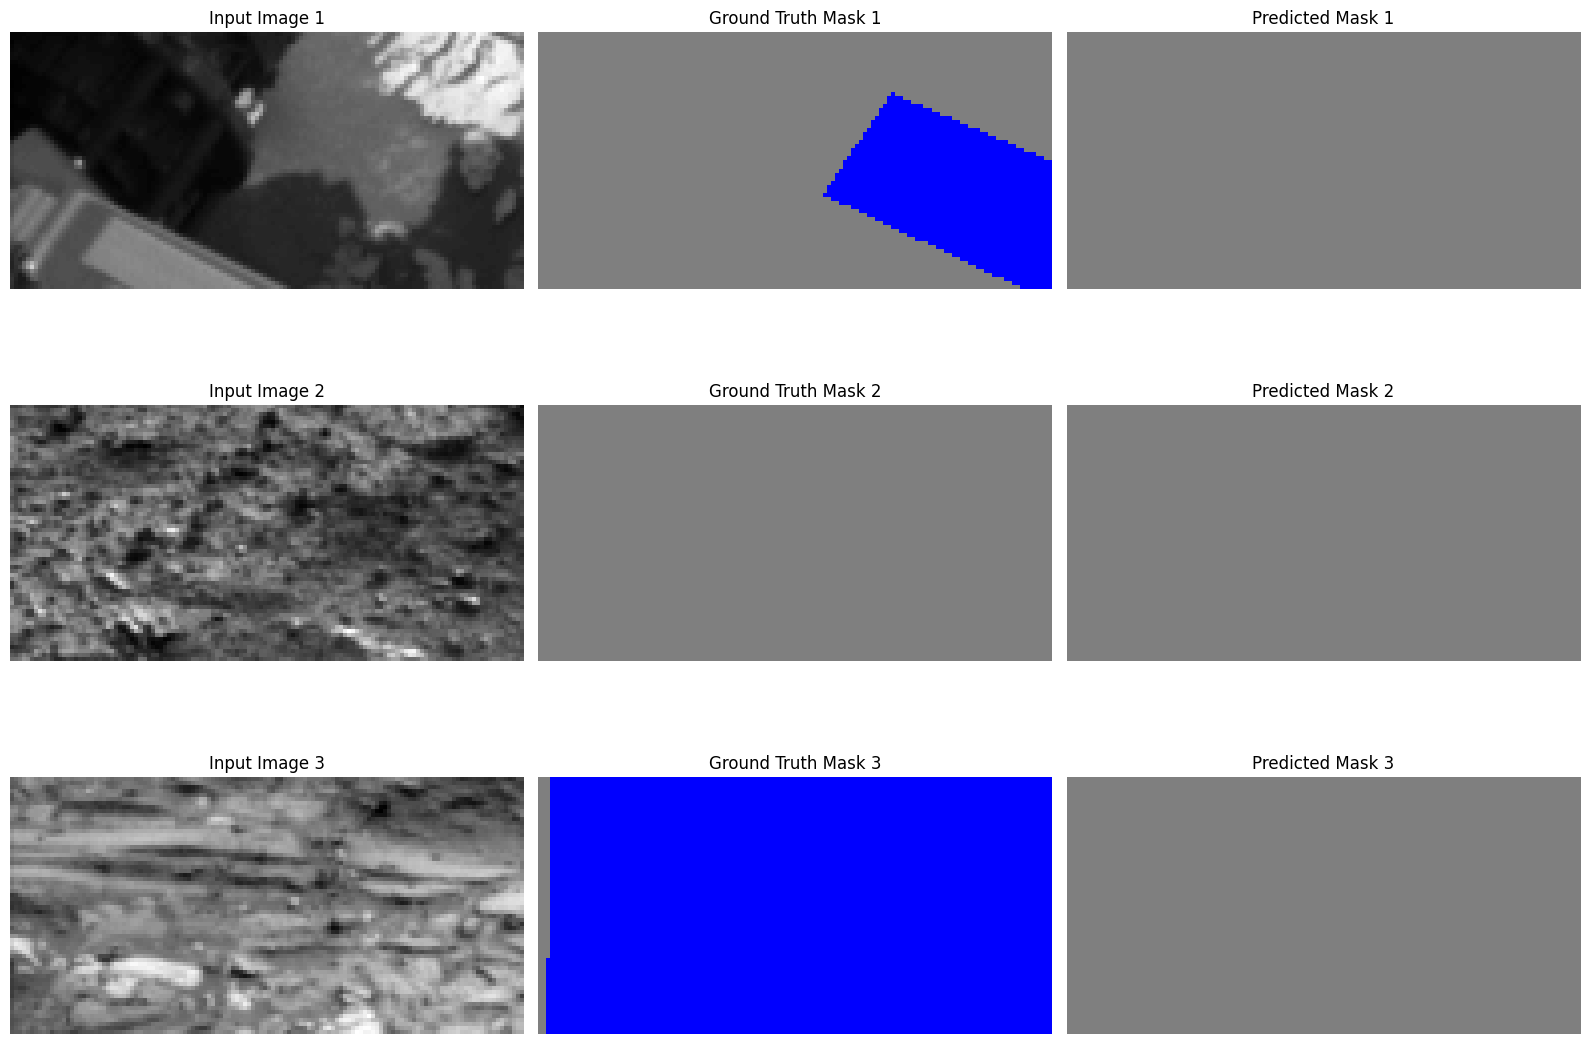

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.5025 - loss: 1.5645 - mean_iou: 0.4060 - val_accuracy: 0.1979 - val_loss: 2.2726 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 7/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.4414 - loss: 1.5818 - mean_iou: 0.3503 - val_accuracy: 0.1979 - val_loss: 2.3029 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 8/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.5115 - loss: 1.5113 - mean_iou: 0.4189 - val_accuracy: 0.1979 - val_loss: 2.3337 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 9/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.5127 - loss: 1.4947 - mean_iou: 0.4264 - val_accuracy: 0.1979 - val_loss: 2.3647 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 10/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.5220 - loss: 1.4504 - mean_iou: 0.4345 - val_accuracy: 0.1979 - val_loss: 2.3866 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 11/500
31/32 ━━━━━━━━━━━━━━━━━

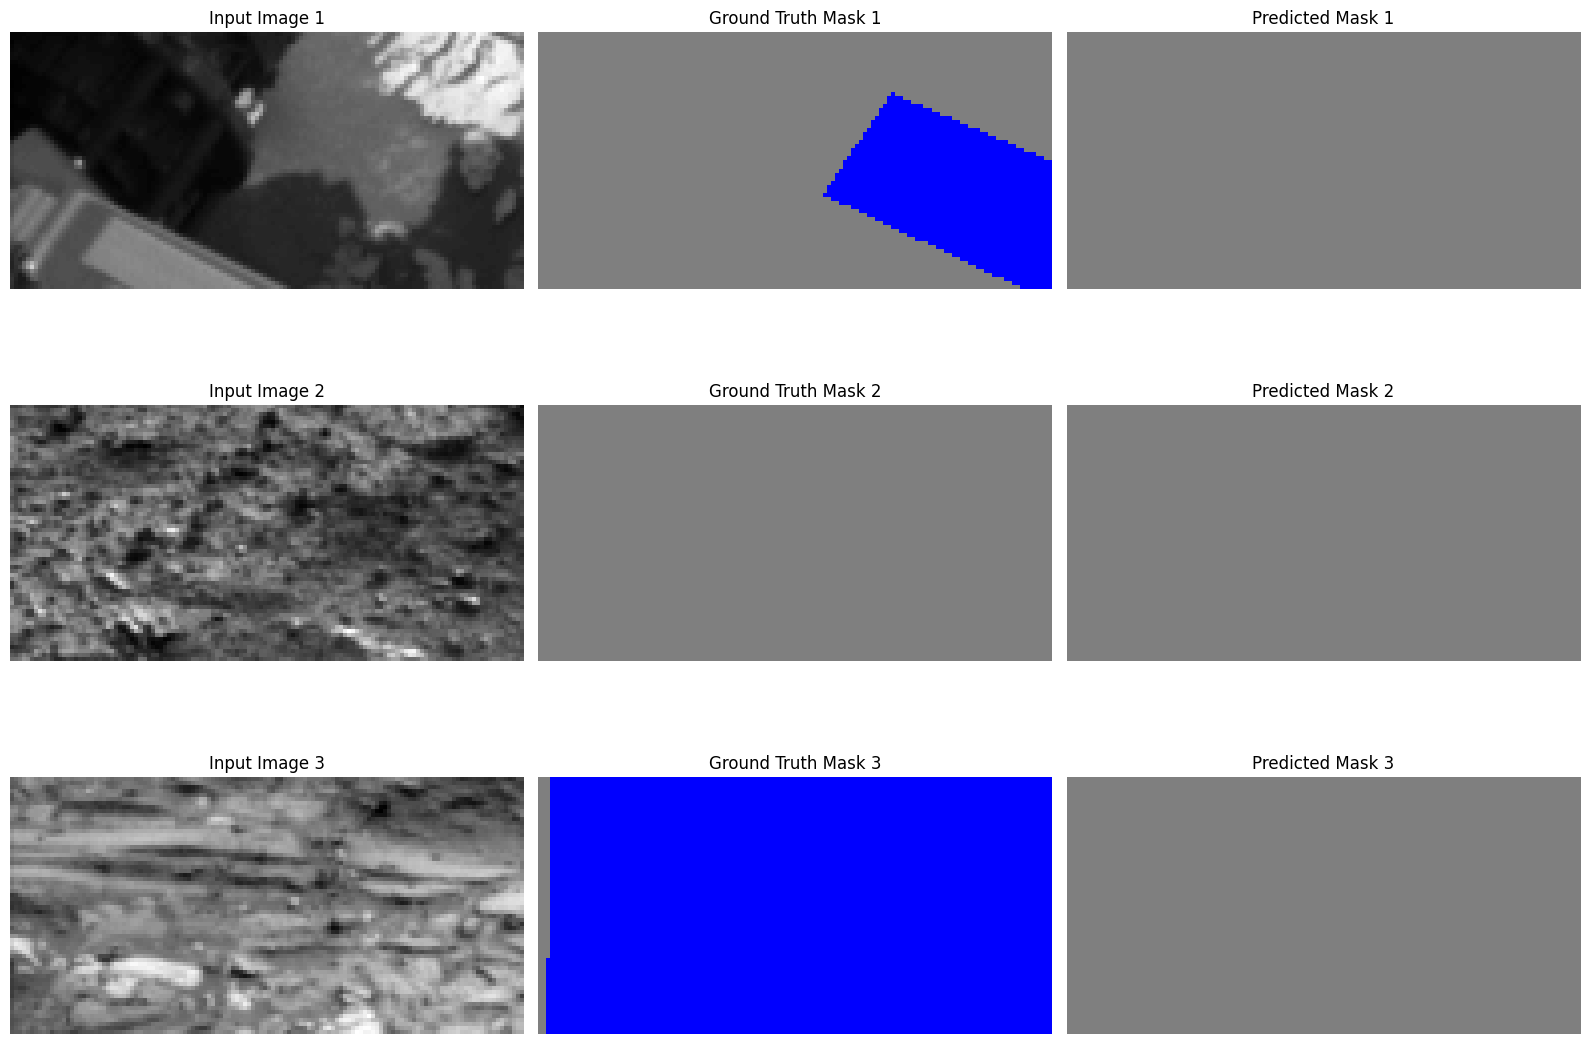


Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.5357 - loss: 1.4061 - mean_iou: 0.4509 - val_accuracy: 0.1979 - val_loss: 2.3793 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 12/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.5291 - loss: 1.3907 - mean_iou: 0.4430 - val_accuracy: 0.1980 - val_loss: 2.3555 - val_mean_iou: 0.0658 - learning_rate: 5.0000e-04
Epoch 13/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.5791 - loss: 1.3419 - mean_iou: 0.5004 - val_accuracy: 0.2150 - val_loss: 2.3693 - val_mean_iou: 0.0804 - learning_rate: 5.0000e-04
Epoch 14/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.5799 - loss: 1.3181 - mean_iou: 0.5038 - val_accuracy: 0.2394 - val_loss: 2.3103 - val_mean_iou: 0.1040 - learning_rate: 5.0000e-04
Epoch 15/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.5833 - loss: 1.3024 - mean_iou: 0.5067 - val_accuracy: 0.2622 - val_los

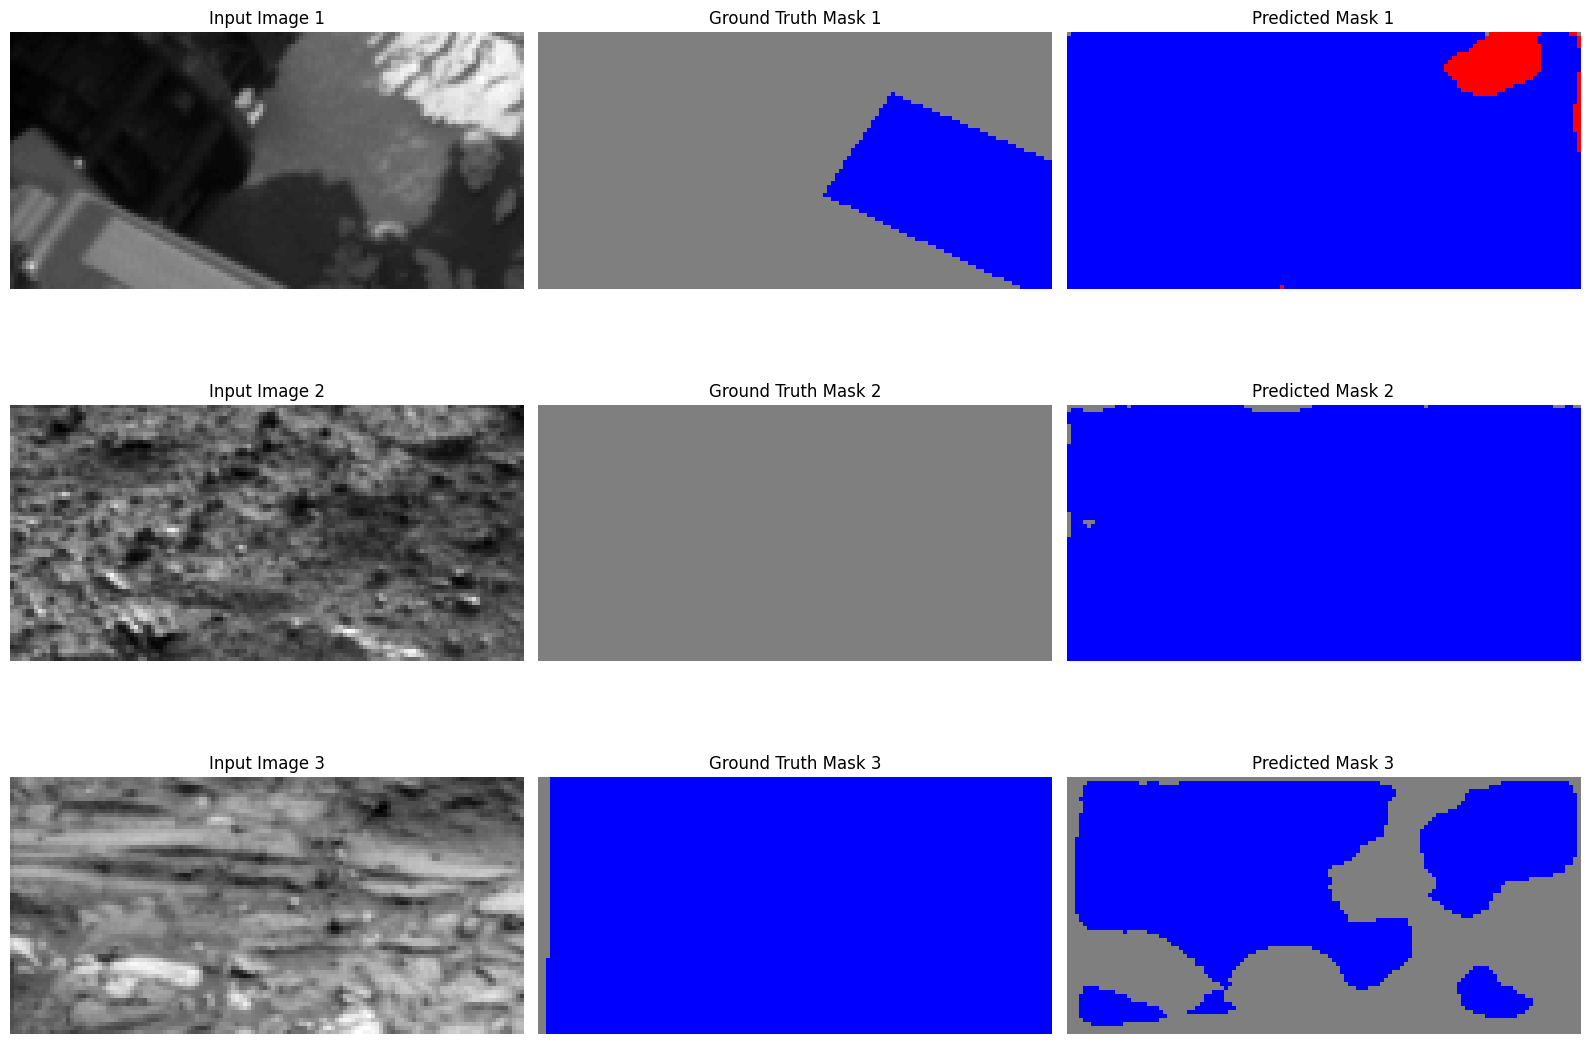

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.5569 - loss: 1.3173 - mean_iou: 0.4748 - val_accuracy: 0.3008 - val_loss: 2.0403 - val_mean_iou: 0.1739 - learning_rate: 5.0000e-04
Epoch 17/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.5614 - loss: 1.3107 - mean_iou: 0.4821 - val_accuracy: 0.2676 - val_loss: 2.1153 - val_mean_iou: 0.1355 - learning_rate: 5.0000e-04
Epoch 18/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.5884 - loss: 1.2806 - mean_iou: 0.5130 - val_accuracy: 0.3626 - val_loss: 2.0570 - val_mean_iou: 0.2273 - learning_rate: 5.0000e-04
Epoch 19/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.5877 - loss: 1.2675 - mean_iou: 0.5123 - val_accuracy: 0.4006 - val_loss: 1.7025 - val_mean_iou: 0.2864 - learning_rate: 5.0000e-04
Epoch 20/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.5941 - loss: 1.2520 - mean_iou: 0.5228 - val_accuracy: 0.4529 - val_loss: 1.5979 - val_mean_iou: 0.3379 - learning_rate: 5.0000e-04
Epoch 21/500


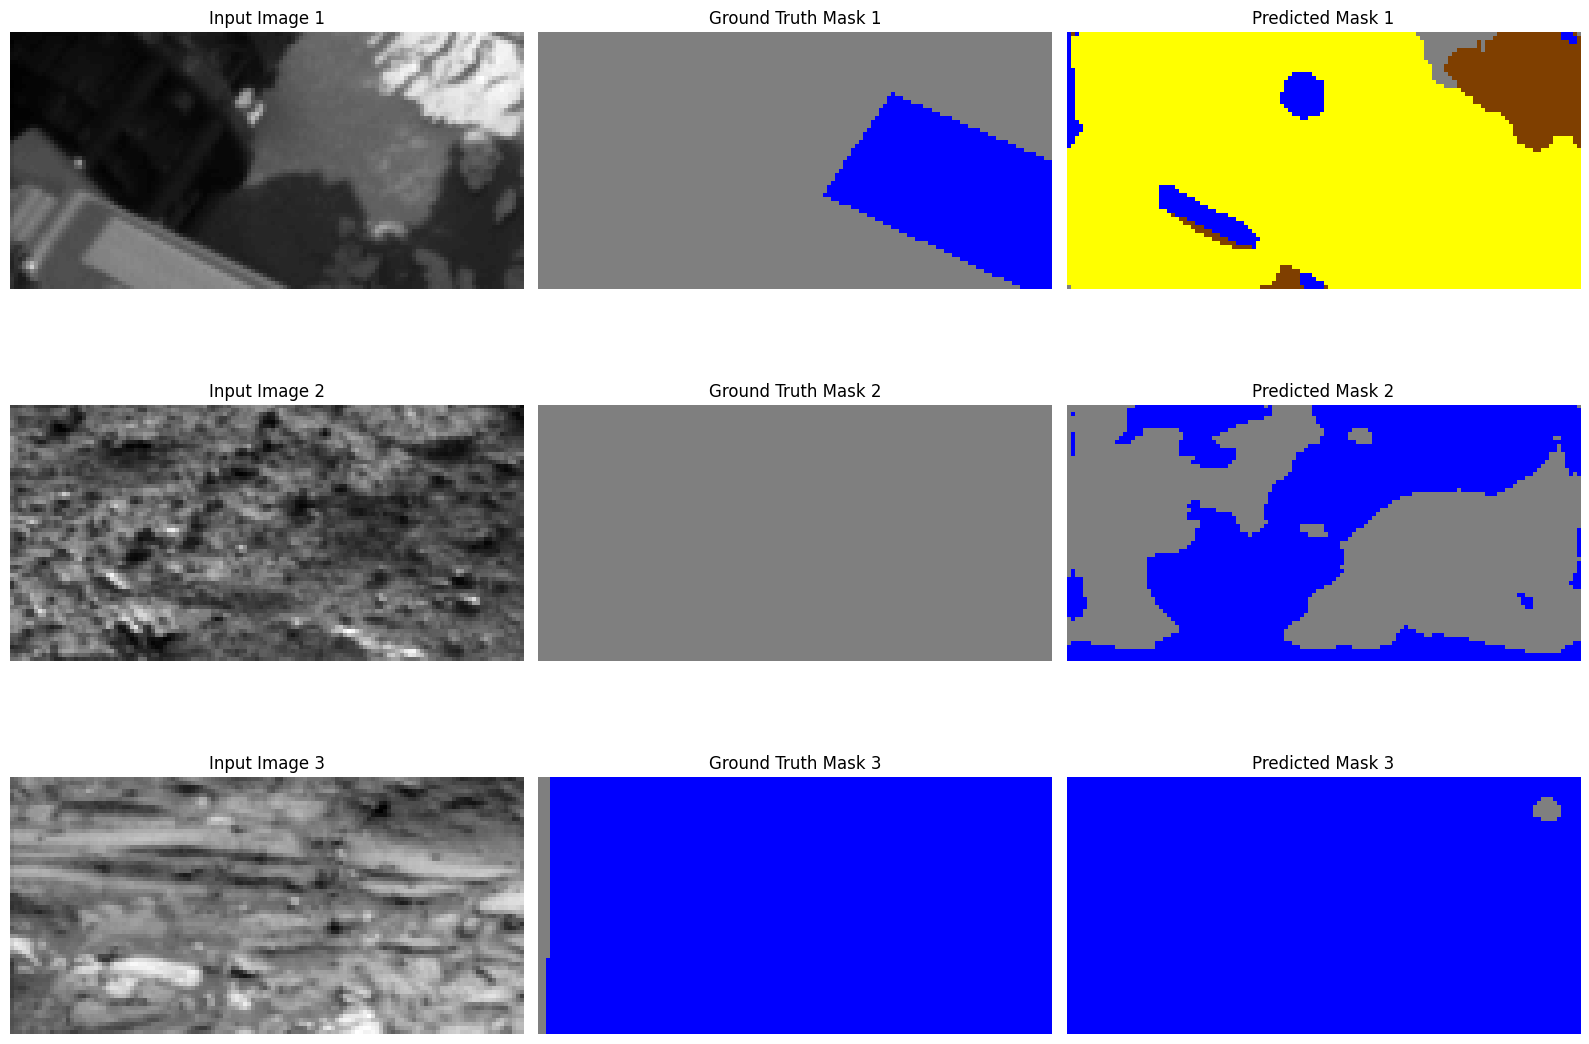

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.5970 - loss: 1.2254 - mean_iou: 0.5263 - val_accuracy: 0.5698 - val_loss: 1.3732 - val_mean_iou: 0.4909 - learning_rate: 5.0000e-04
Epoch 22/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.6004 - loss: 1.2130 - mean_iou: 0.5308 - val_accuracy: 0.5972 - val_loss: 1.3095 - val_mean_iou: 0.5296 - learning_rate: 5.0000e-04
Epoch 23/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6103 - loss: 1.1977 - mean_iou: 0.5458 - val_accuracy: 0.5776 - val_loss: 1.3523 - val_mean_iou: 0.4999 - learning_rate: 5.0000e-04
Epoch 24/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6103 - loss: 1.1836 - mean_iou: 0.5501 - val_accuracy: 0.5894 - val_loss: 1.3224 - val_mean_iou: 0.4974 - learning_rate: 5.0000e-04
Epoch 25/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.6250 - loss: 1.1663 - mean_iou: 0.5725 - val_accuracy: 0.5888 - val_loss: 1.3428 - val_mean_iou: 0.4919 - learning_rate: 5.0000e-04
Epoch 26/500


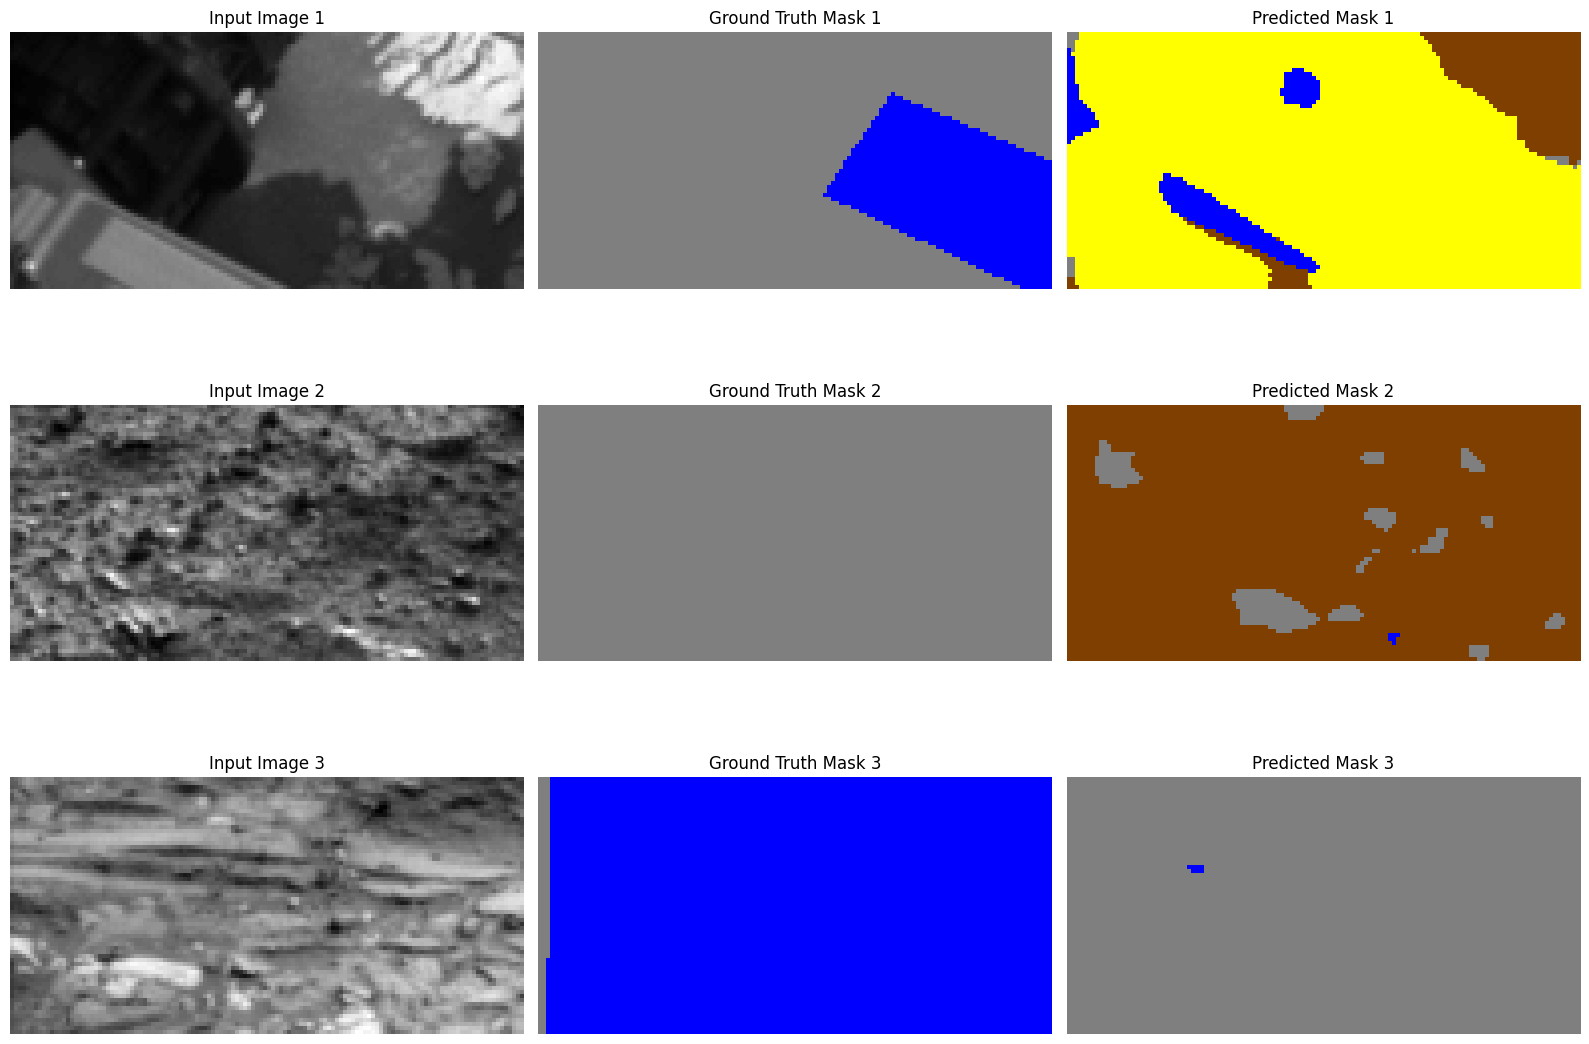

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.6191 - loss: 1.1702 - mean_iou: 0.5604 - val_accuracy: 0.5394 - val_loss: 1.3466 - val_mean_iou: 0.4326 - learning_rate: 5.0000e-04
Epoch 27/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.6248 - loss: 1.1561 - mean_iou: 0.5703 - val_accuracy: 0.5501 - val_loss: 1.3359 - val_mean_iou: 0.4512 - learning_rate: 5.0000e-04
Epoch 28/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6065 - loss: 1.1790 - mean_iou: 0.5431 - val_accuracy: 0.4067 - val_loss: 1.6063 - val_mean_iou: 0.3140 - learning_rate: 5.0000e-04
Epoch 29/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.6270 - loss: 1.1349 - mean_iou: 0.5796 - val_accuracy: 0.5788 - val_loss: 1.2482 - val_mean_iou: 0.4889 - learning_rate: 5.0000e-04
Epoch 30/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6087 - loss: 1.1550 - mean_iou: 0.5480 - val_accuracy: 0.5976 - val_loss: 1.2744 - val_mean_iou: 0.5198 - learning_rate: 5.0000e-04
Epoch 31/500


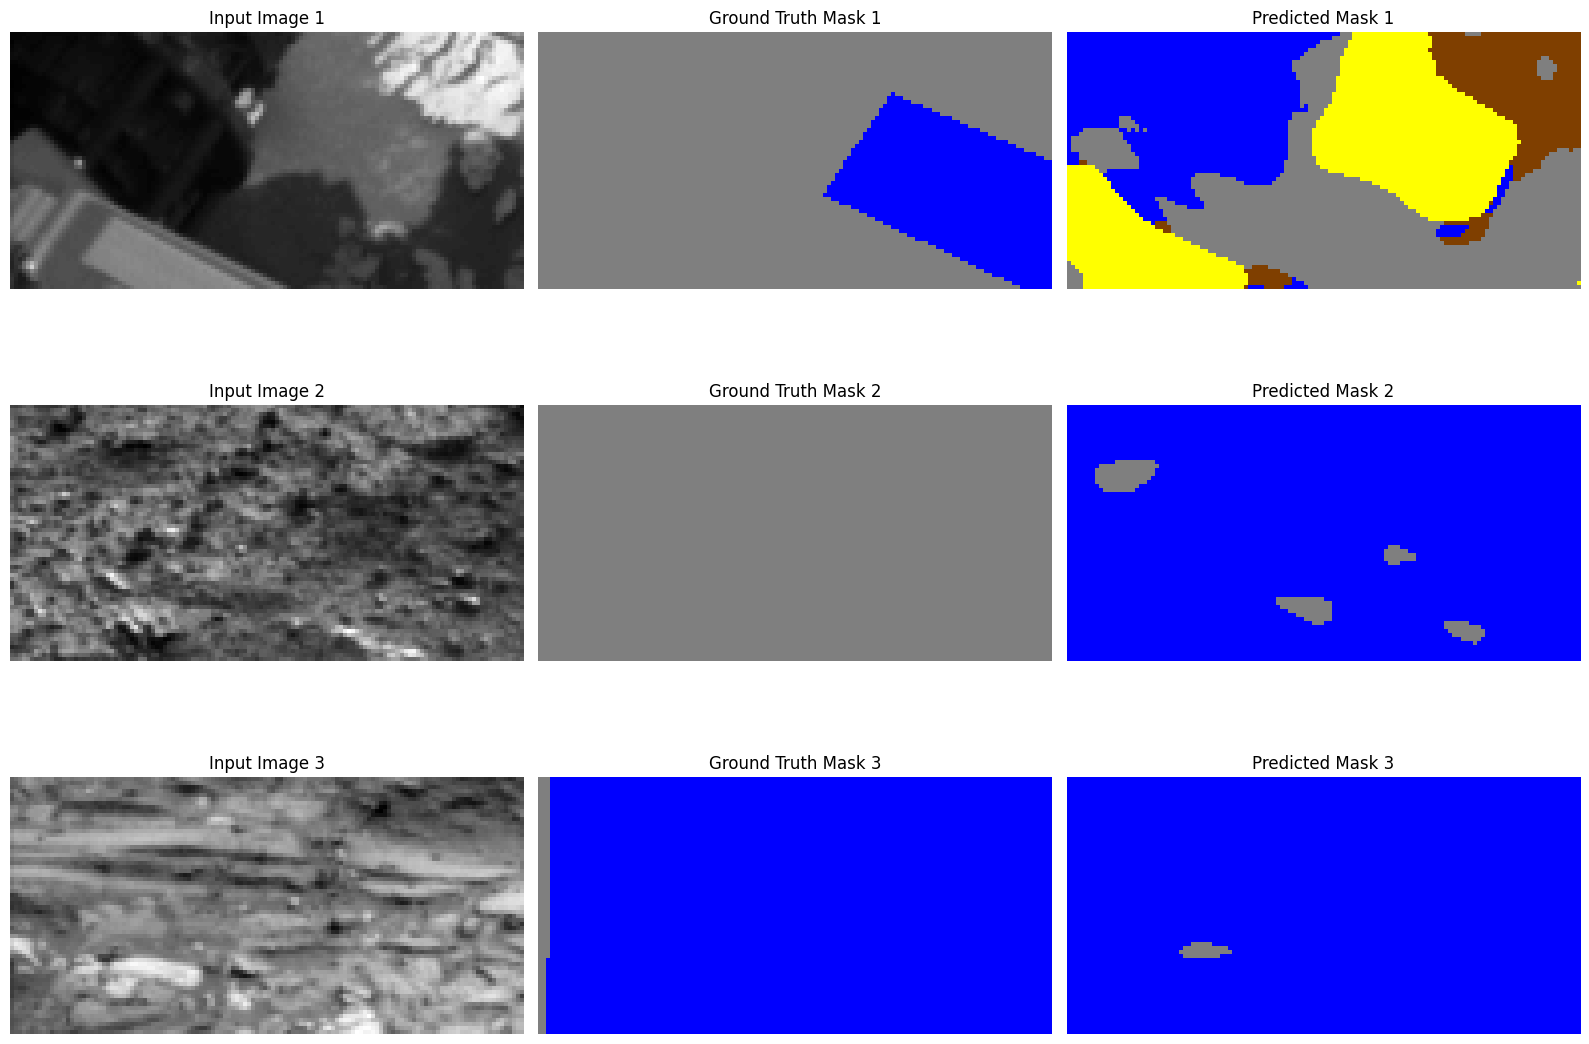

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.6165 - loss: 1.1821 - mean_iou: 0.5530 - val_accuracy: 0.5274 - val_loss: 1.3400 - val_mean_iou: 0.4335 - learning_rate: 5.0000e-04
Epoch 32/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6219 - loss: 1.1549 - mean_iou: 0.5668 - val_accuracy: 0.5247 - val_loss: 1.2948 - val_mean_iou: 0.4333 - learning_rate: 5.0000e-04
Epoch 33/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.6291 - loss: 1.1199 - mean_iou: 0.5808 - val_accuracy: 0.5889 - val_loss: 1.2917 - val_mean_iou: 0.5243 - learning_rate: 5.0000e-04
Epoch 34/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.6344 - loss: 1.1003 - mean_iou: 0.5909 - val_accuracy: 0.5777 - val_loss: 1.3032 - val_mean_iou: 0.4830 - learning_rate: 5.0000e-04
Epoch 35/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.6170 - loss: 1.1231 - mean_iou: 0.5581 - val_accuracy: 0.4219 - val_loss: 1.5057 - val_mean_iou: 0.3669 - learning_rate: 5.0000e-04
Epoch 36/500


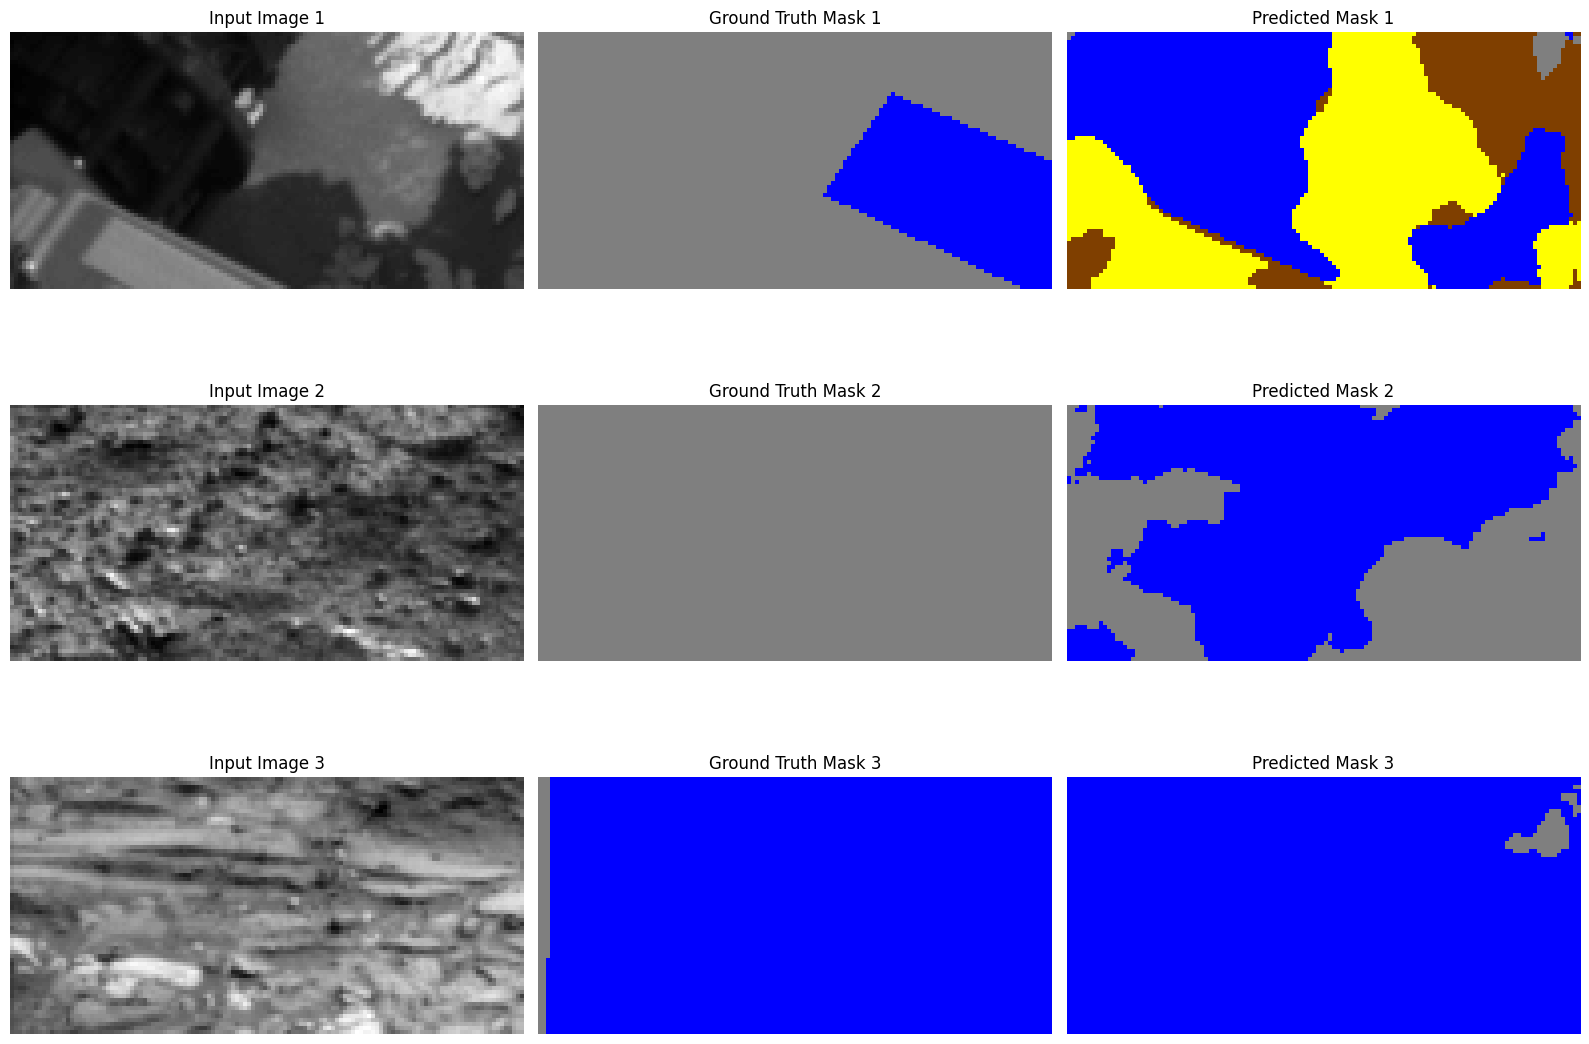

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.6306 - loss: 1.0859 - mean_iou: 0.5826 - val_accuracy: 0.5944 - val_loss: 1.2936 - val_mean_iou: 0.5128 - learning_rate: 5.0000e-04
Epoch 37/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6299 - loss: 1.1086 - mean_iou: 0.5786 - val_accuracy: 0.4867 - val_loss: 1.3652 - val_mean_iou: 0.3946 - learning_rate: 5.0000e-04
Epoch 38/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.6430 - loss: 1.0902 - mean_iou: 0.6054 - val_accuracy: 0.5884 - val_loss: 1.2176 - val_mean_iou: 0.5237 - learning_rate: 5.0000e-04
Epoch 39/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.6524 - loss: 1.0373 - mean_iou: 0.6293 - val_accuracy: 0.6042 - val_loss: 1.2928 - val_mean_iou: 0.5559 - learning_rate: 5.0000e-04
Epoch 40/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.6546 - loss: 1.0211 - mean_iou: 0.6325 - val_accuracy: 0.5866 - val_loss: 1.3145 - val_mean_iou: 0.5458 - learning_rate: 5.0000e-04
Epoch 41/500


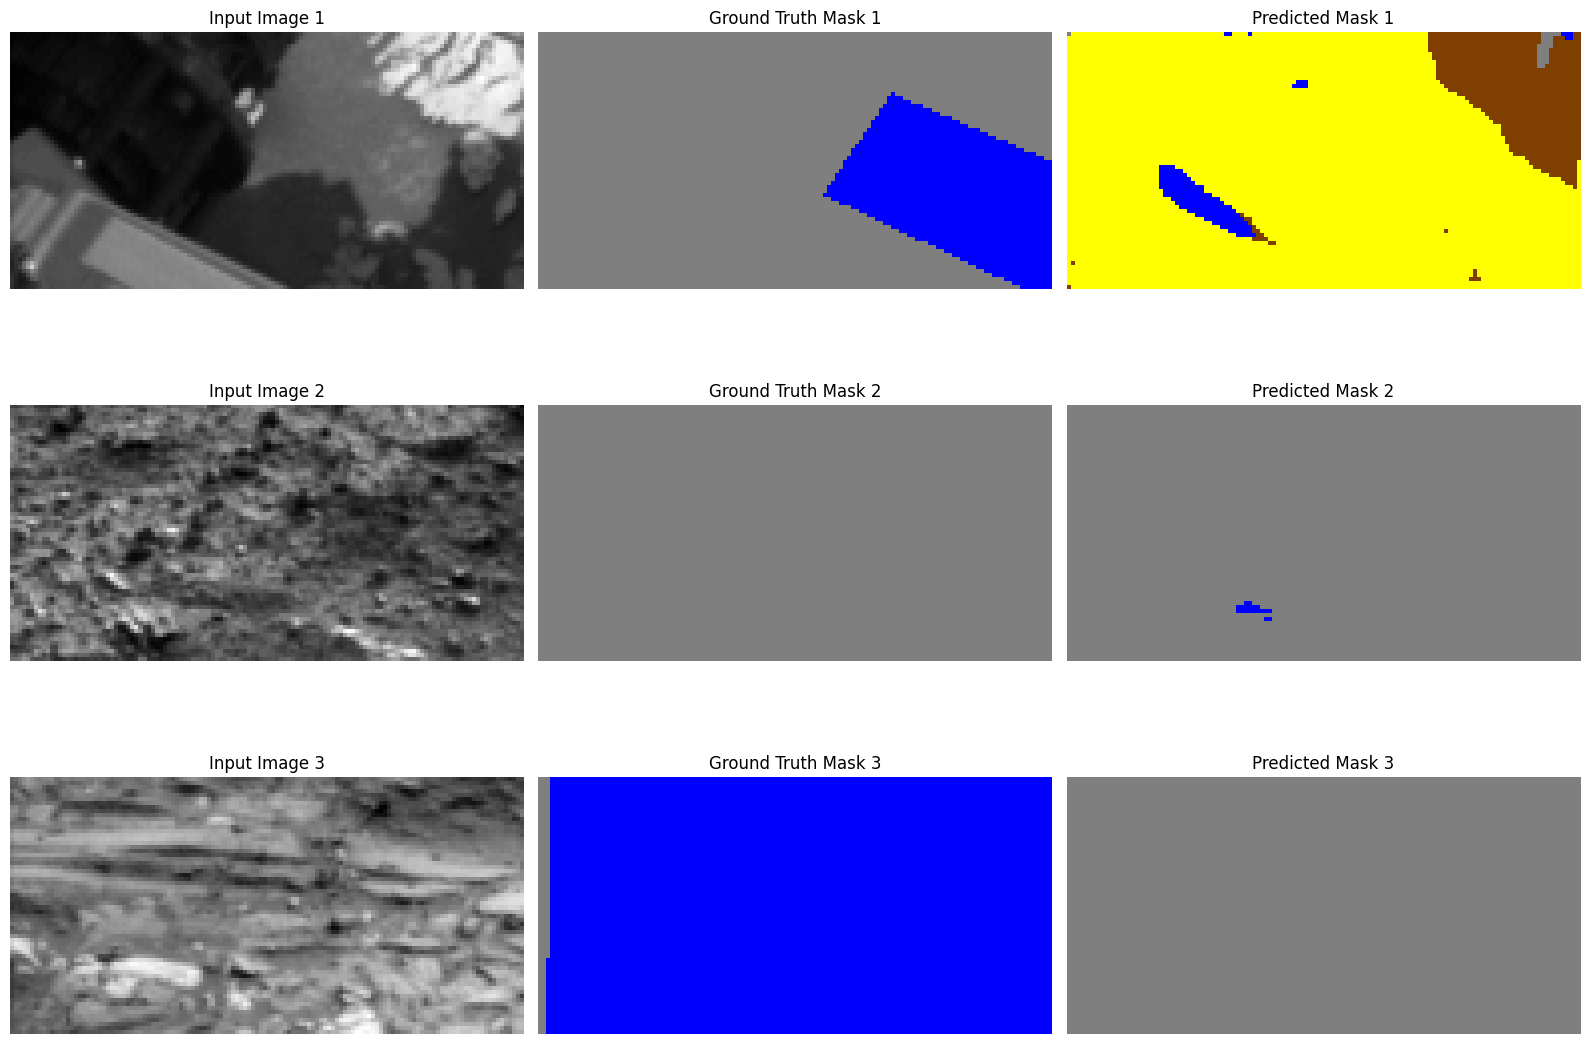

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.6549 - loss: 1.0050 - mean_iou: 0.6361 - val_accuracy: 0.6255 - val_loss: 1.2512 - val_mean_iou: 0.5925 - learning_rate: 5.0000e-04
Epoch 42/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.6638 - loss: 0.9853 - mean_iou: 0.6702 - val_accuracy: 0.6290 - val_loss: 1.2258 - val_mean_iou: 0.5681 - learning_rate: 5.0000e-04
Epoch 43/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6471 - loss: 1.0020 - mean_iou: 0.6179 - val_accuracy: 0.5242 - val_loss: 1.4548 - val_mean_iou: 0.4193 - learning_rate: 5.0000e-04
Epoch 44/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6399 - loss: 1.0335 - mean_iou: 0.6001 - val_accuracy: 0.4673 - val_loss: 1.4507 - val_mean_iou: 0.3549 - learning_rate: 5.0000e-04
Epoch 45/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.5956 - loss: 1.0778 - mean_iou: 0.5307 - val_accuracy: 0.3568 - val_loss: 1.5050 - val_mean_iou: 0.2511 - learning_rate: 5.0000e-04
Epoch 46/500


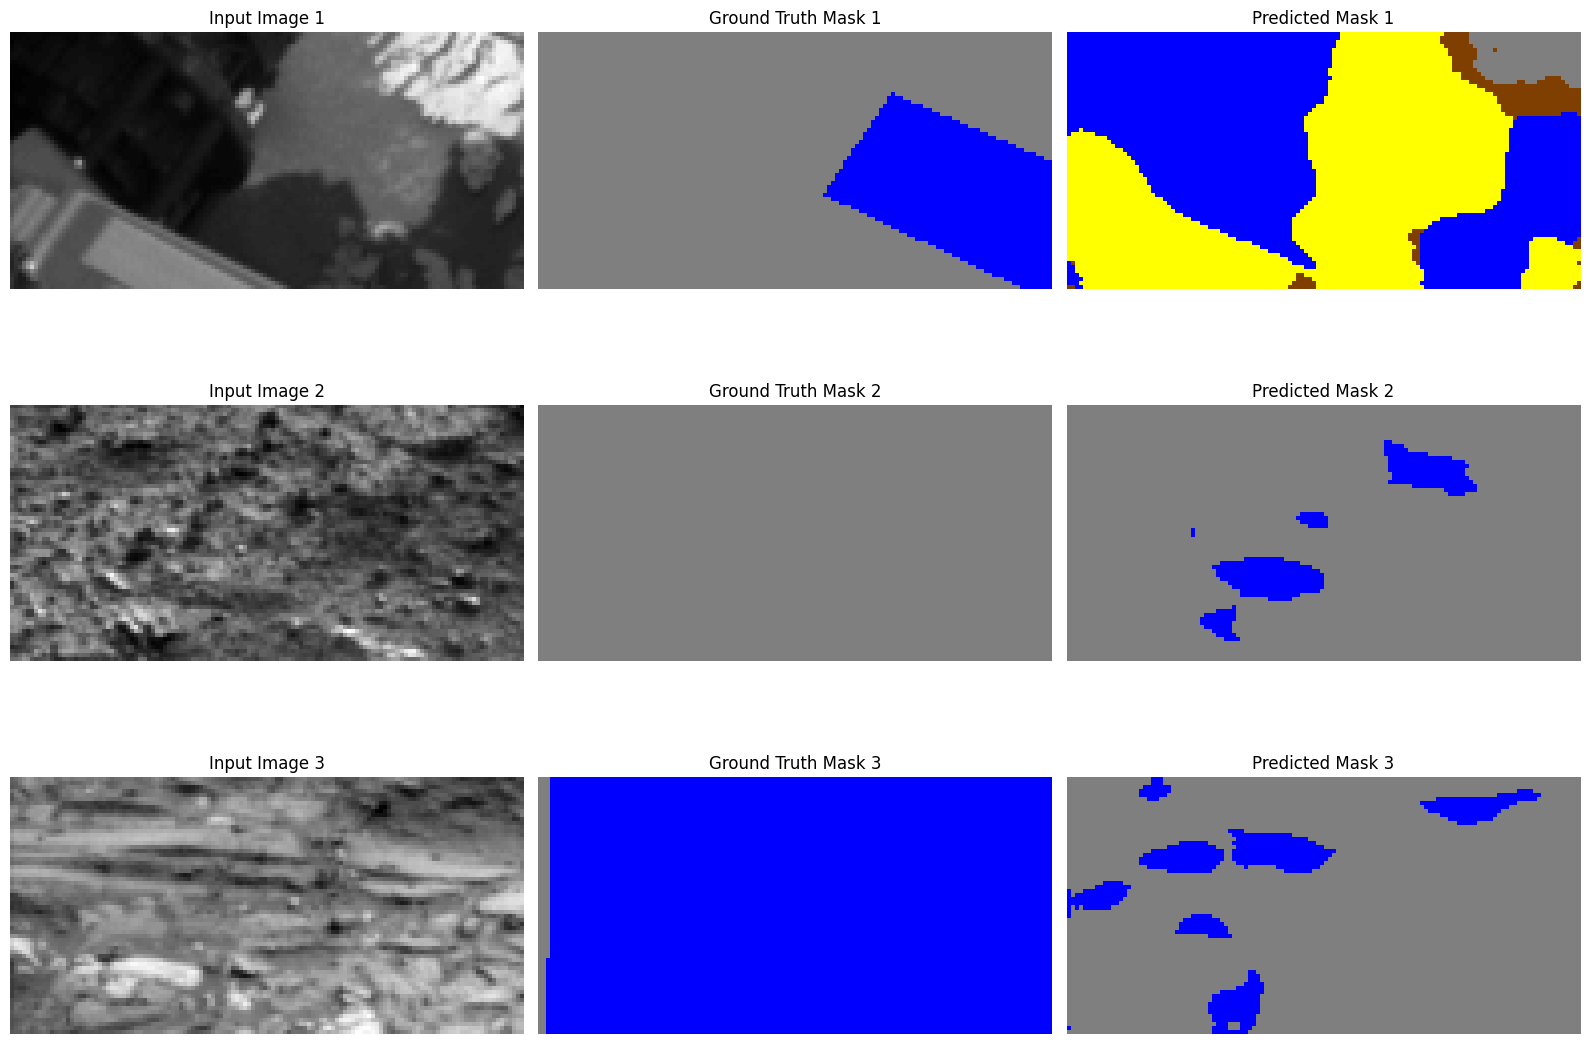

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.6138 - loss: 1.0519 - mean_iou: 0.5520 - val_accuracy: 0.5196 - val_loss: 1.3419 - val_mean_iou: 0.3870 - learning_rate: 5.0000e-04
Epoch 47/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6461 - loss: 0.9759 - mean_iou: 0.6046 - val_accuracy: 0.6215 - val_loss: 1.1568 - val_mean_iou: 0.5489 - learning_rate: 5.0000e-04
Epoch 48/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6521 - loss: 0.9577 - mean_iou: 0.6214 - val_accuracy: 0.5910 - val_loss: 1.2745 - val_mean_iou: 0.5027 - learning_rate: 5.0000e-04
Epoch 49/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.6492 - loss: 0.9403 - mean_iou: 0.6174 - val_accuracy: 0.6111 - val_loss: 1.1774 - val_mean_iou: 0.5586 - learning_rate: 5.0000e-04
Epoch 50/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6581 - loss: 0.9173 - mean_iou: 0.6447 - val_accuracy: 0.5998 - val_loss: 1.2810 - val_mean_iou: 0.5271 - learning_rate: 5.0000e-04
Epoch 51/500


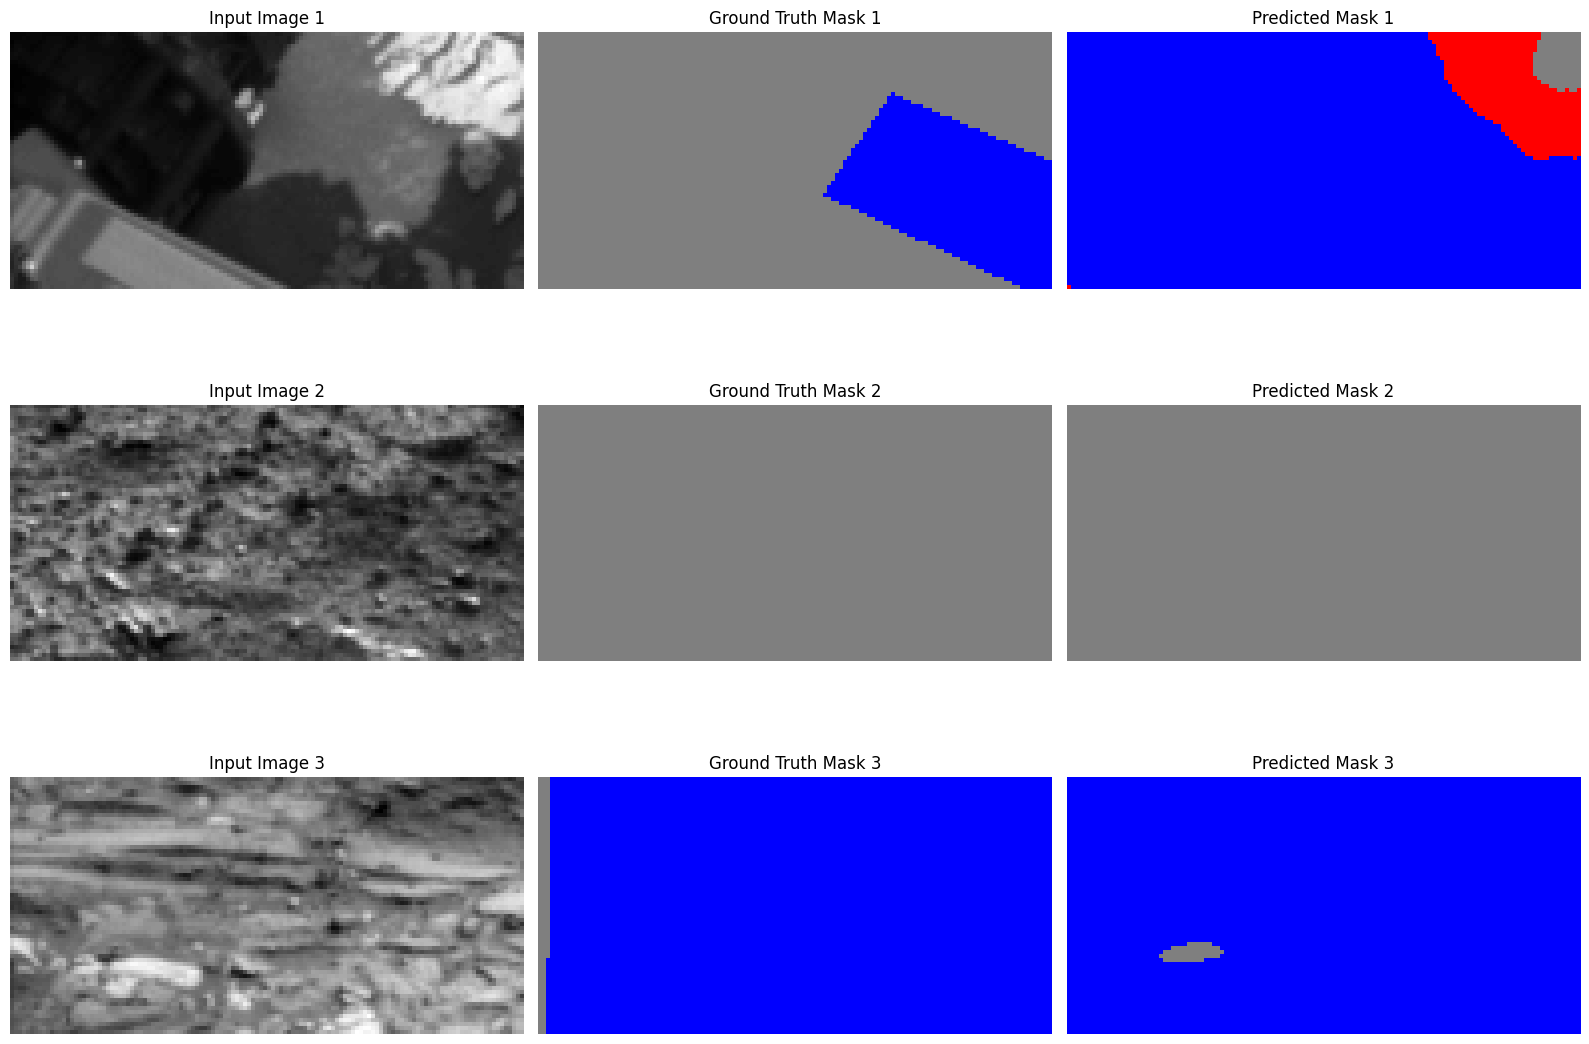

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.6607 - loss: 0.9042 - mean_iou: 0.6571 - val_accuracy: 0.6023 - val_loss: 1.1872 - val_mean_iou: 0.5799 - learning_rate: 5.0000e-04
Epoch 52/500
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.6372 - loss: 0.9329 - mean_iou: 0.6136
Epoch 52: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6368 - loss: 0.9350 - mean_iou: 0.6112 - val_accuracy: 0.4491 - val_loss: 1.3264 - val_mean_iou: 0.3473 - learning_rate: 5.0000e-04
Epoch 53/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.6313 - loss: 0.9669 - mean_iou: 0.5814 - val_accuracy: 0.5302 - val_loss: 1.2064 - val_mean_iou: 0.4299 - learning_rate: 2.5000e-04
Epoch 54/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6523 - loss: 0.8999 - mean_iou: 0.6258 - val_accuracy: 0.6145 - val_loss: 1.1132 - val_mean_iou: 0.5458 - learning_rate: 2.5000e-04
Epoch 55/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s

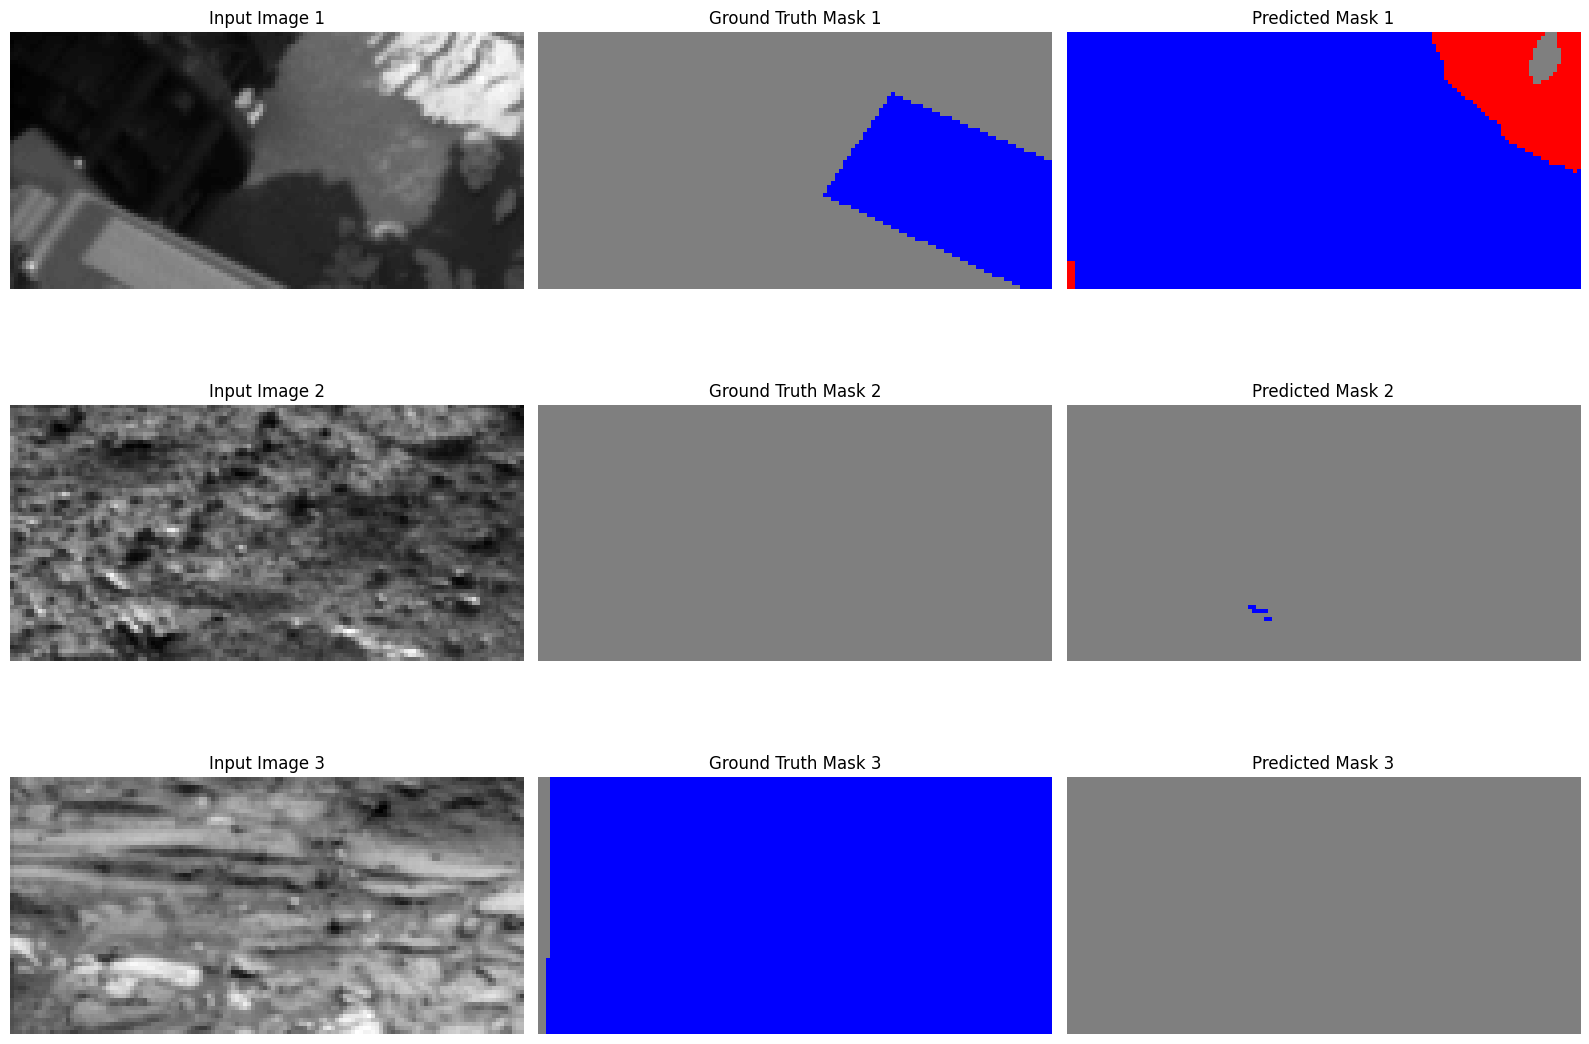

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.6704 - loss: 0.8488 - mean_iou: 0.6799 - val_accuracy: 0.6259 - val_loss: 1.1135 - val_mean_iou: 0.5851 - learning_rate: 2.5000e-04
Epoch 57/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6723 - loss: 0.8361 - mean_iou: 0.6987 - val_accuracy: 0.6299 - val_loss: 1.1336 - val_mean_iou: 0.6087 - learning_rate: 2.5000e-04
Epoch 58/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.6745 - loss: 0.8256 - mean_iou: 0.7057 - val_accuracy: 0.6358 - val_loss: 1.1235 - val_mean_iou: 0.6261 - learning_rate: 2.5000e-04
Epoch 59/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.6735 - loss: 0.8198 - mean_iou: 0.7145 - val_accuracy: 0.6437 - val_loss: 1.1302 - val_mean_iou: 0.6519 - learning_rate: 2.5000e-04
Epoch 60/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.6756 - loss: 0.8089 - mean_iou: 0.7202 - val_accuracy: 0.6571 - val_loss: 1.1440 - val_mean_iou: 0.6611 - learning_rate: 2.5000e-04
Epoch 61/500


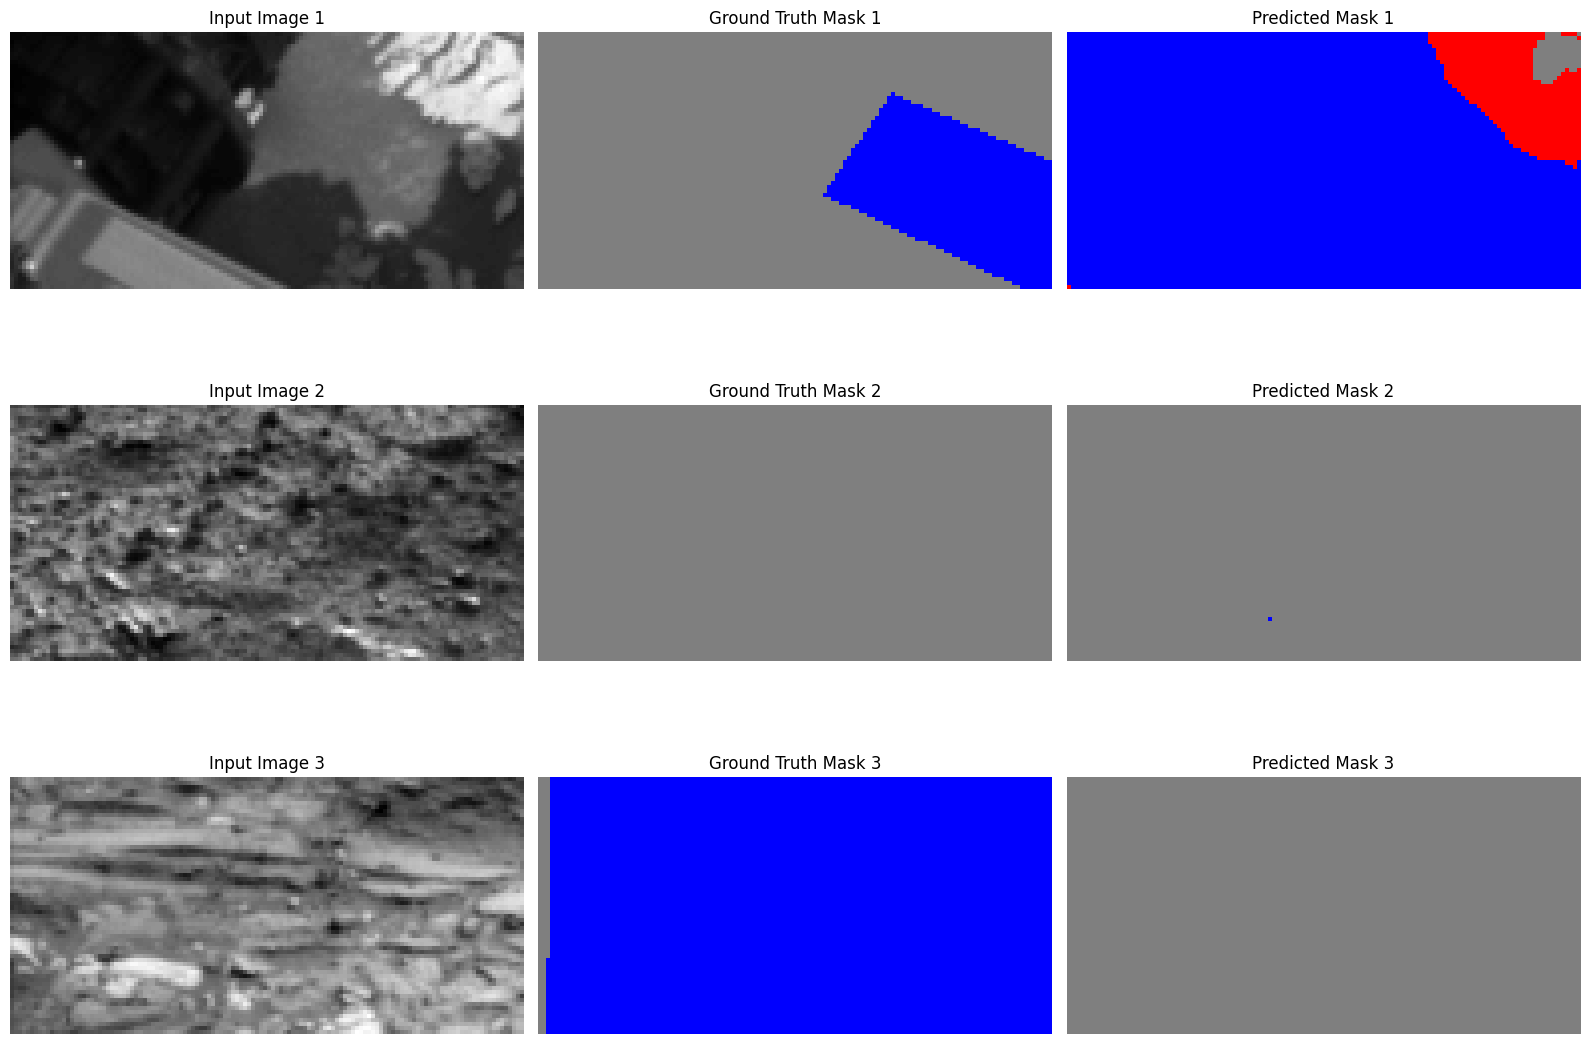

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.6786 - loss: 0.8029 - mean_iou: 0.7241 - val_accuracy: 0.6382 - val_loss: 1.2008 - val_mean_iou: 0.6152 - learning_rate: 2.5000e-04
Epoch 62/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6783 - loss: 0.7940 - mean_iou: 0.7302 - val_accuracy: 0.6520 - val_loss: 1.1528 - val_mean_iou: 0.6419 - learning_rate: 2.5000e-04
Epoch 63/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.6772 - loss: 0.7999 - mean_iou: 0.7211 - val_accuracy: 0.6466 - val_loss: 1.0965 - val_mean_iou: 0.6226 - learning_rate: 2.5000e-04
Epoch 64/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6794 - loss: 0.7868 - mean_iou: 0.7221 - val_accuracy: 0.6549 - val_loss: 1.1116 - val_mean_iou: 0.6337 - learning_rate: 2.5000e-04
Epoch 65/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.6811 - loss: 0.7753 - mean_iou: 0.7235 - val_accuracy: 0.6469 - val_loss: 1.2312 - val_mean_iou: 0.6561 - learning_rate: 2.5000e-04
Epoch 66/500


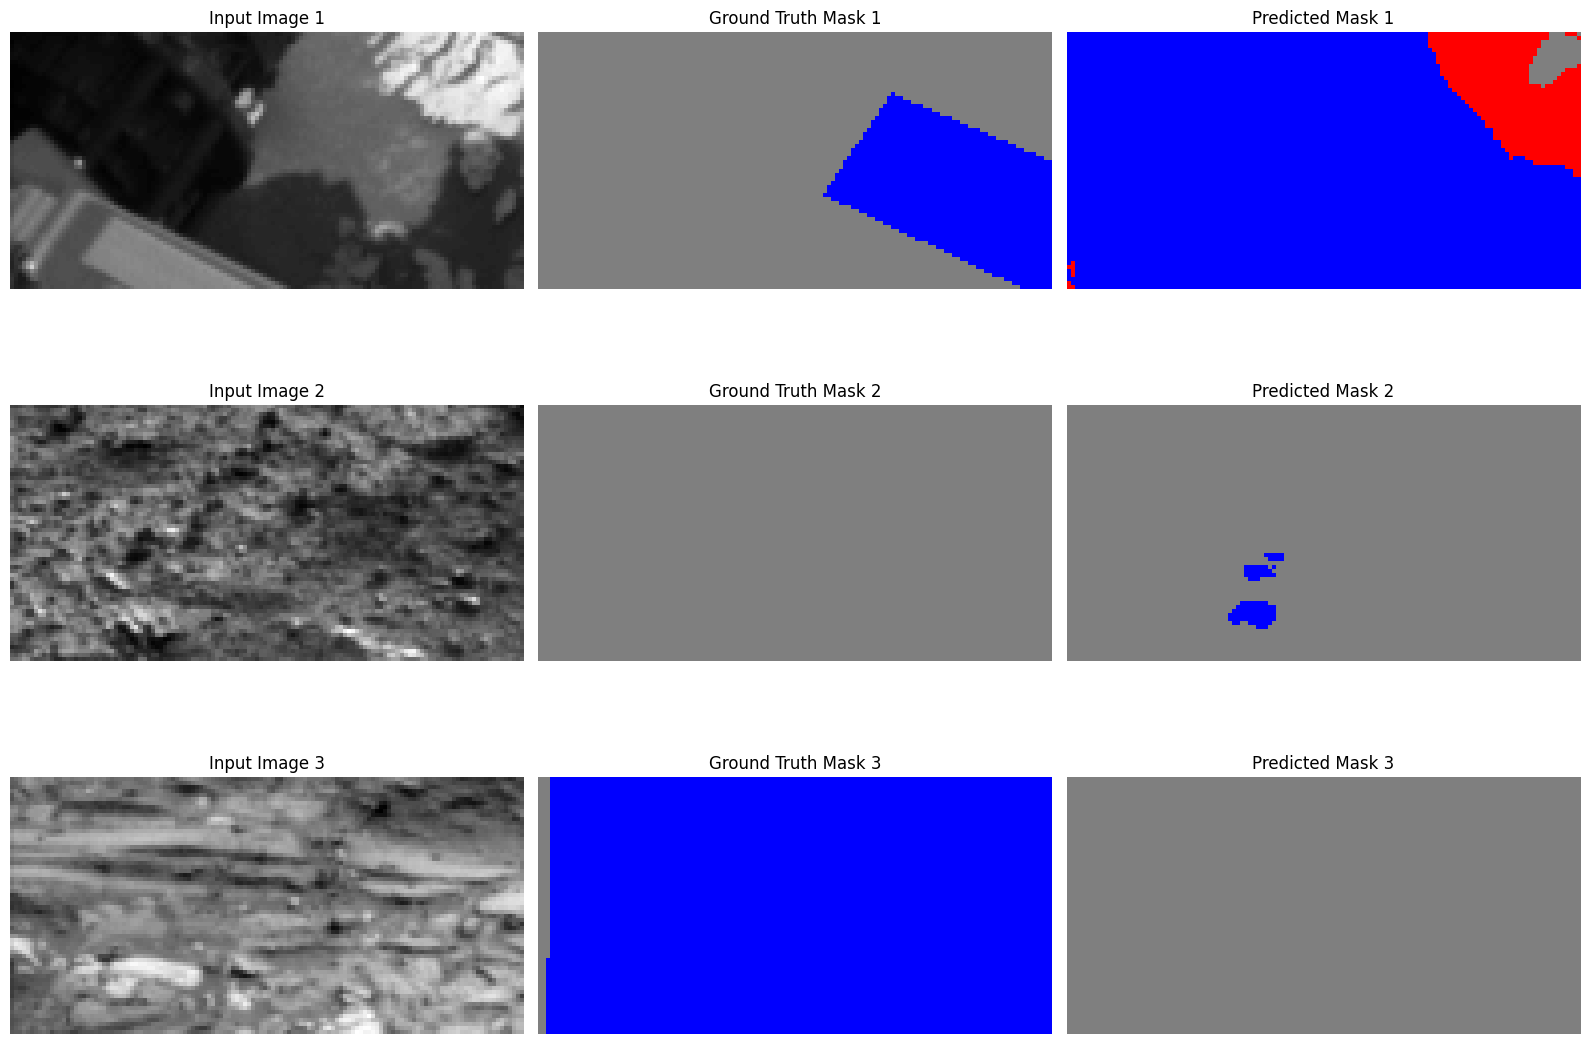

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.6834 - loss: 0.7678 - mean_iou: 0.7342 - val_accuracy: 0.6354 - val_loss: 1.1138 - val_mean_iou: 0.6180 - learning_rate: 2.5000e-04
Epoch 67/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6832 - loss: 0.7634 - mean_iou: 0.7396 - val_accuracy: 0.6481 - val_loss: 1.1520 - val_mean_iou: 0.6347 - learning_rate: 2.5000e-04
Epoch 68/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.6821 - loss: 0.7540 - mean_iou: 0.7412 - val_accuracy: 0.6391 - val_loss: 1.1802 - val_mean_iou: 0.6127 - learning_rate: 2.5000e-04
Epoch 69/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.6836 - loss: 0.7474 - mean_iou: 0.7462 - val_accuracy: 0.6553 - val_loss: 1.1547 - val_mean_iou: 0.6378 - learning_rate: 2.5000e-04
Epoch 70/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.6820 - loss: 0.7438 - mean_iou: 0.7353 - val_accuracy: 0.6584 - val_loss: 1.0909 - val_mean_iou: 0.6542 - learning_rate: 2.5000e-04
Epoch 71/500


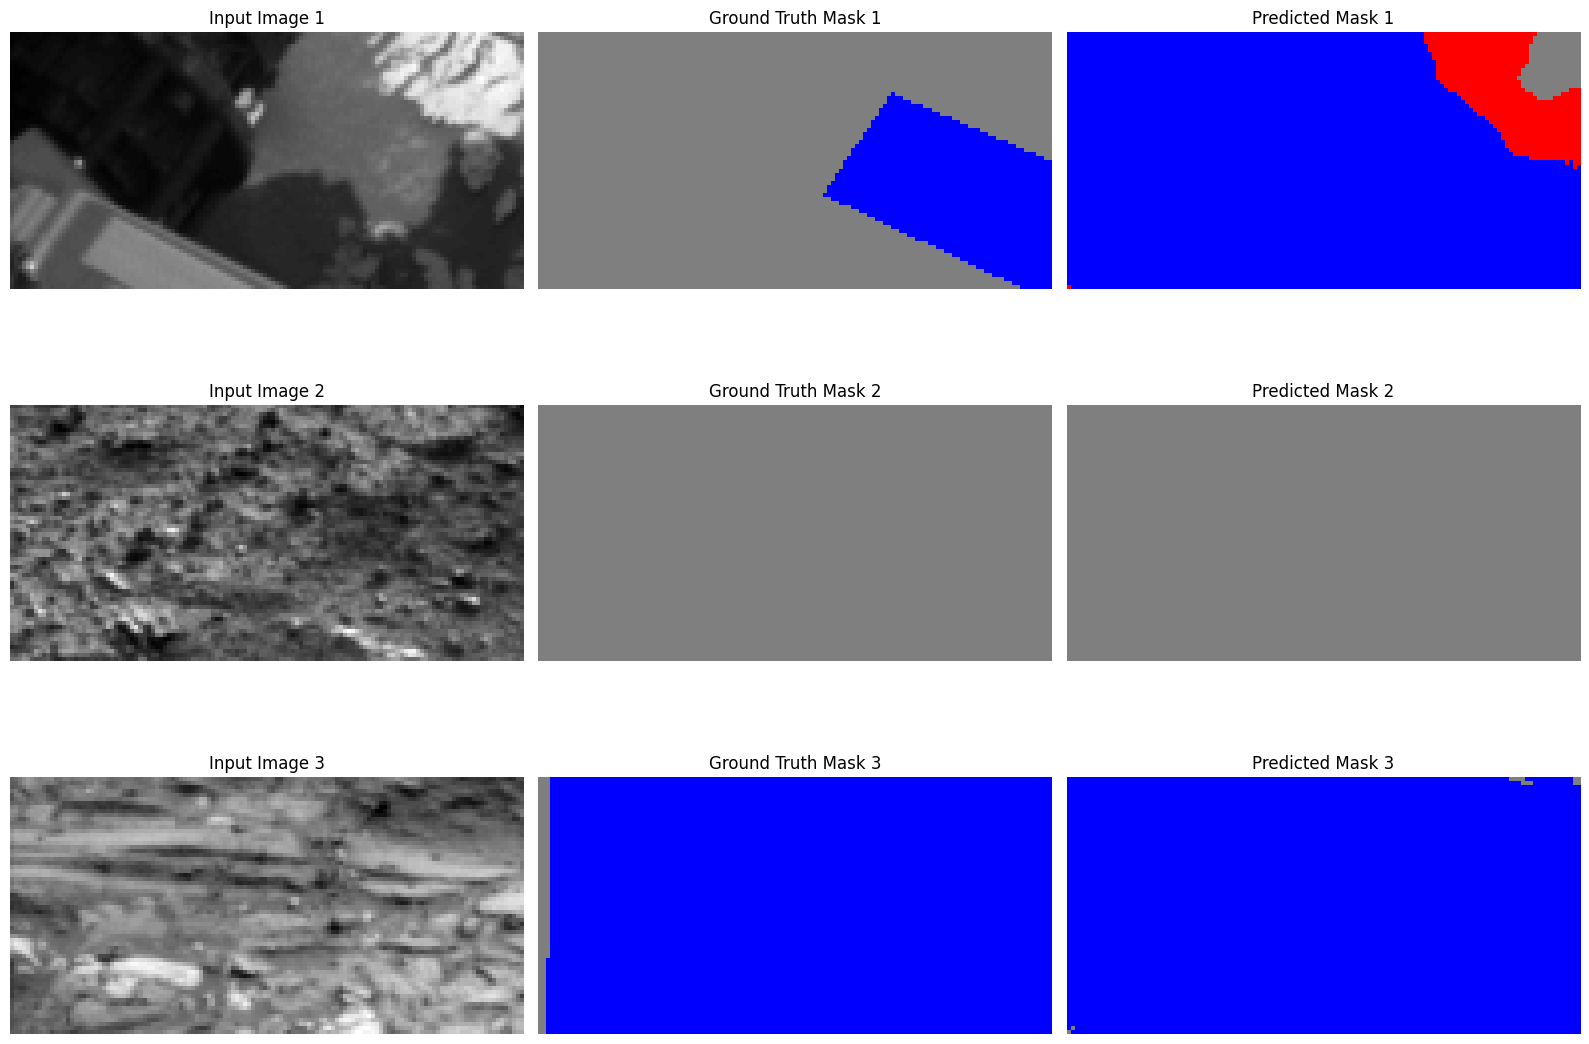

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.6861 - loss: 0.7342 - mean_iou: 0.7416 - val_accuracy: 0.6239 - val_loss: 1.2292 - val_mean_iou: 0.5875 - learning_rate: 2.5000e-04
Epoch 72/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.6792 - loss: 0.7360 - mean_iou: 0.6904 - val_accuracy: 0.6311 - val_loss: 1.2608 - val_mean_iou: 0.6031 - learning_rate: 2.5000e-04
Epoch 73/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6851 - loss: 0.7227 - mean_iou: 0.7428 - val_accuracy: 0.6549 - val_loss: 1.1066 - val_mean_iou: 0.6435 - learning_rate: 2.5000e-04
Epoch 74/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.6869 - loss: 0.7146 - mean_iou: 0.7333 - val_accuracy: 0.6496 - val_loss: 1.1203 - val_mean_iou: 0.6206 - learning_rate: 2.5000e-04
Epoch 75/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.6904 - loss: 0.7157 - mean_iou: 0.7545 - val_accuracy: 0.6572 - val_loss: 1.2494 - val_mean_iou: 0.6653 - learning_rate: 2.5000e-04
Epoch 76/500


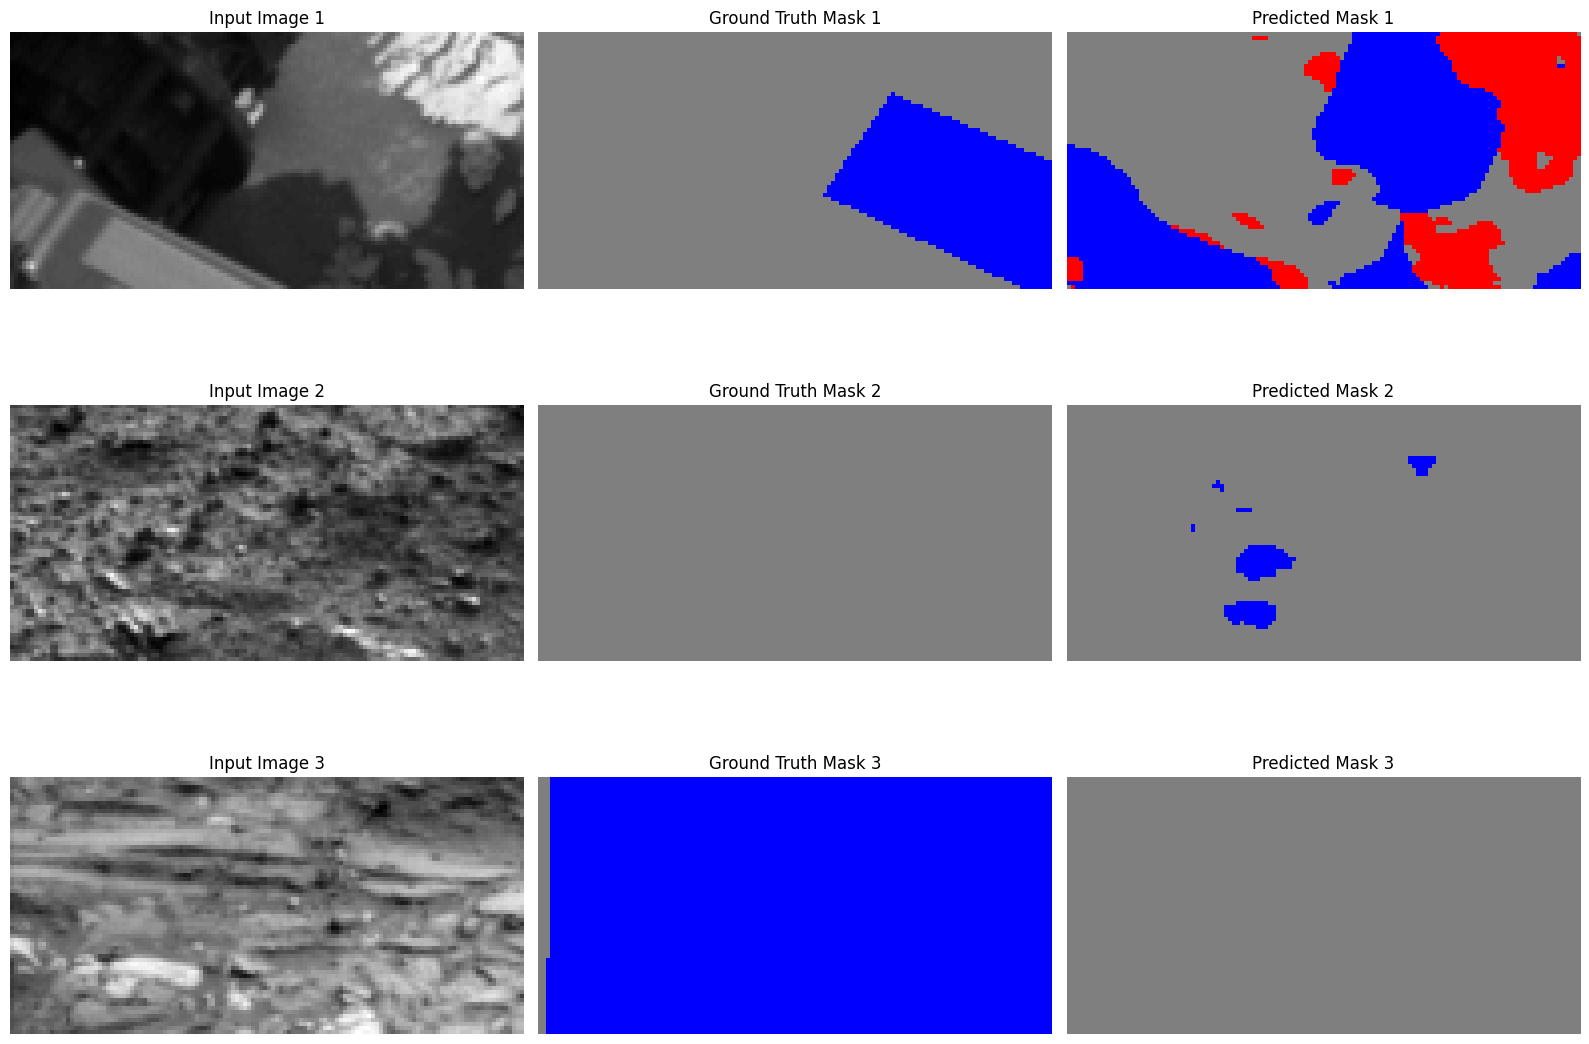

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.6857 - loss: 0.7369 - mean_iou: 0.7426 - val_accuracy: 0.6080 - val_loss: 1.1586 - val_mean_iou: 0.5773 - learning_rate: 2.5000e-04
Epoch 77/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.6838 - loss: 0.7306 - mean_iou: 0.7245 - val_accuracy: 0.6456 - val_loss: 1.1778 - val_mean_iou: 0.6083 - learning_rate: 2.5000e-04
Epoch 78/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6887 - loss: 0.7030 - mean_iou: 0.7441 - val_accuracy: 0.6321 - val_loss: 1.2272 - val_mean_iou: 0.5969 - learning_rate: 2.5000e-04
Epoch 79/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.6926 - loss: 0.6886 - mean_iou: 0.7583 - val_accuracy: 0.6297 - val_loss: 1.2044 - val_mean_iou: 0.5968 - learning_rate: 2.5000e-04
Epoch 80/500
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.6868 - loss: 0.6940 - mean_iou: 0.7609
Epoch 80: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s

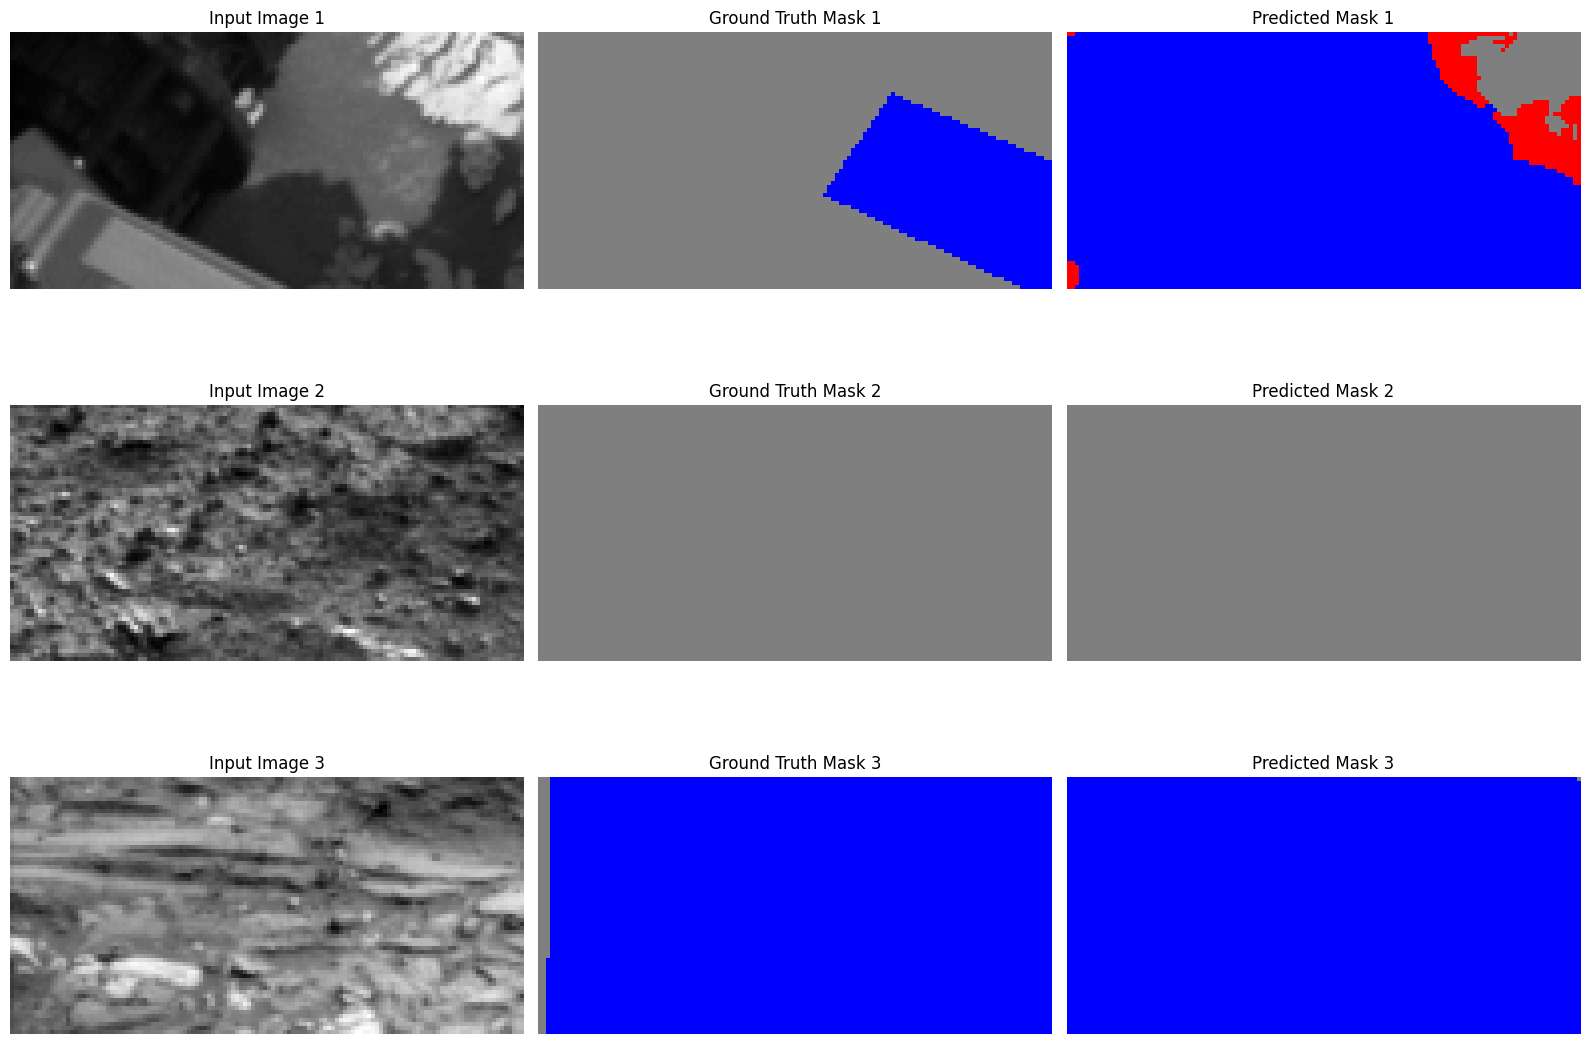

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.6901 - loss: 0.6871 - mean_iou: 0.7461 - val_accuracy: 0.6241 - val_loss: 1.2148 - val_mean_iou: 0.5904 - learning_rate: 1.2500e-04
Epoch 82/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.6922 - loss: 0.6757 - mean_iou: 0.7575 - val_accuracy: 0.6478 - val_loss: 1.1663 - val_mean_iou: 0.6561 - learning_rate: 1.2500e-04
Epoch 83/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6955 - loss: 0.6658 - mean_iou: 0.7834 - val_accuracy: 0.6558 - val_loss: 1.1442 - val_mean_iou: 0.6647 - learning_rate: 1.2500e-04
Epoch 84/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6958 - loss: 0.6593 - mean_iou: 0.7936 - val_accuracy: 0.6603 - val_loss: 1.1155 - val_mean_iou: 0.6829 - learning_rate: 1.2500e-04
Epoch 85/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.6953 - loss: 0.6563 - mean_iou: 0.7964 - val_accuracy: 0.6584 - val_loss: 1.1271 - val_mean_iou: 0.6664 - learning_rate: 1.2500e-04
Epoch 86/500


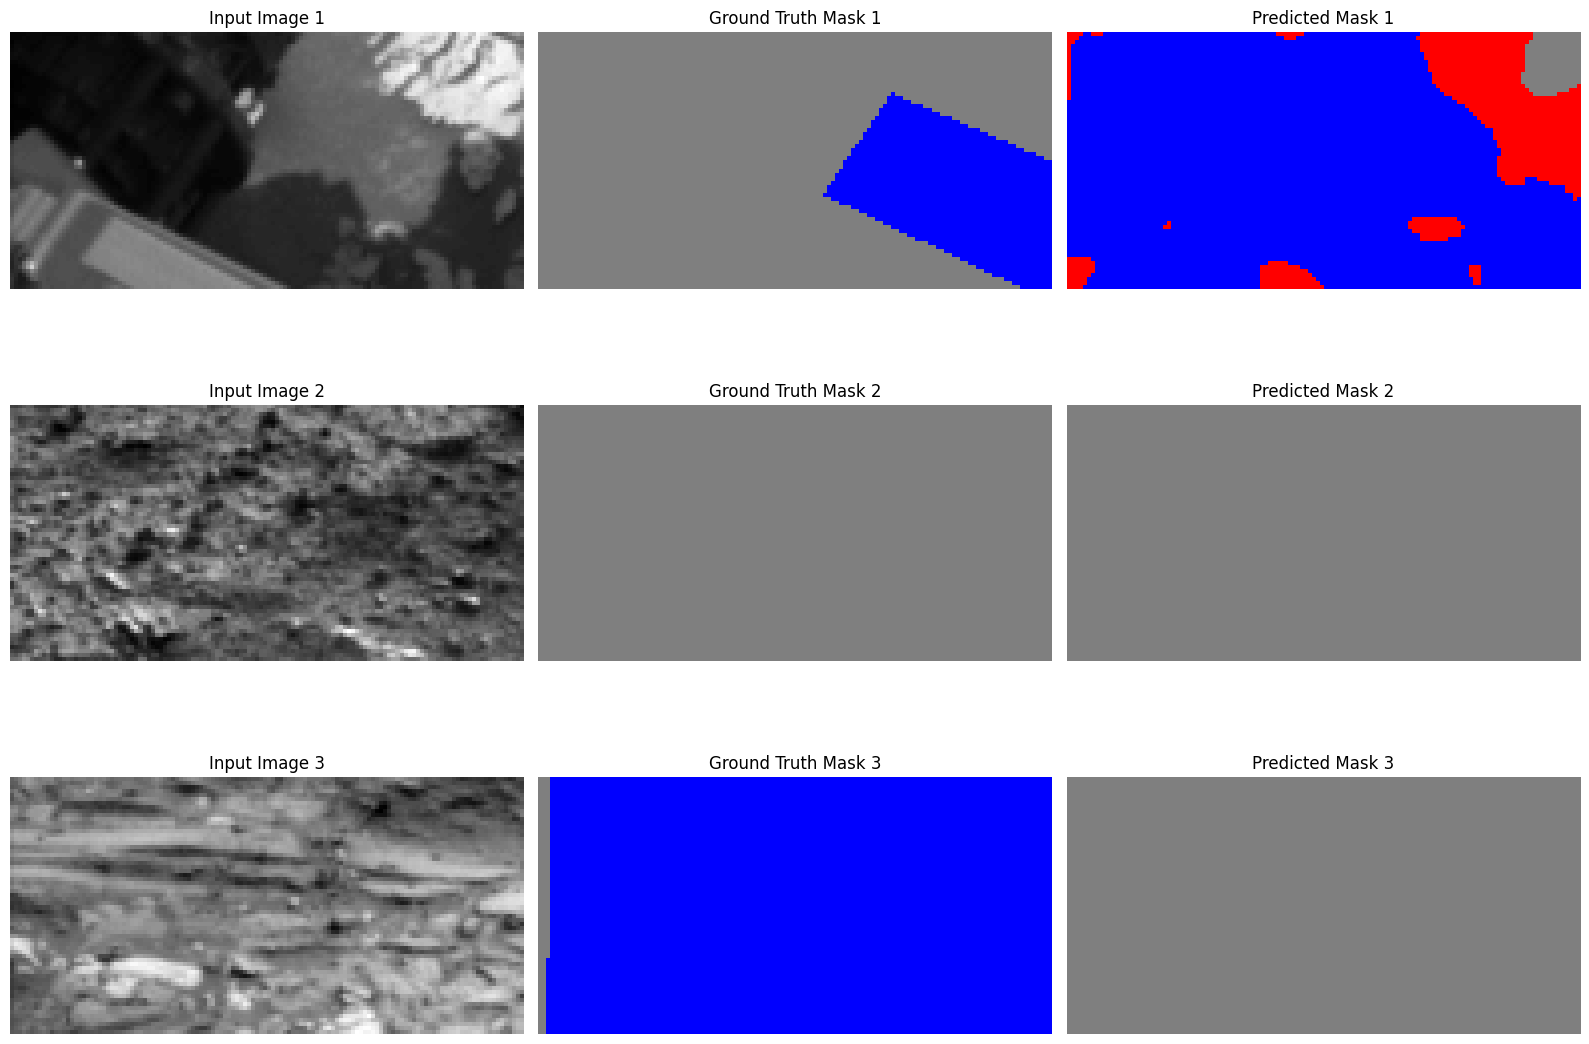

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.6966 - loss: 0.6511 - mean_iou: 0.7970 - val_accuracy: 0.6612 - val_loss: 1.1309 - val_mean_iou: 0.6731 - learning_rate: 1.2500e-04
Epoch 87/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.6960 - loss: 0.6500 - mean_iou: 0.8009 - val_accuracy: 0.6610 - val_loss: 1.1361 - val_mean_iou: 0.6774 - learning_rate: 1.2500e-04
Epoch 88/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.6994 - loss: 0.6426 - mean_iou: 0.7936 - val_accuracy: 0.6622 - val_loss: 1.1266 - val_mean_iou: 0.6688 - learning_rate: 1.2500e-04
Epoch 89/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6995 - loss: 0.6392 - mean_iou: 0.8036 - val_accuracy: 0.6609 - val_loss: 1.1522 - val_mean_iou: 0.6695 - learning_rate: 1.2500e-04
Epoch 90/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.7007 - loss: 0.6350 - mean_iou: 0.8077 - val_accuracy: 0.6625 - val_loss: 1.1303 - val_mean_iou: 0.6619 - learning_rate: 1.2500e-04
Epoch 91/500


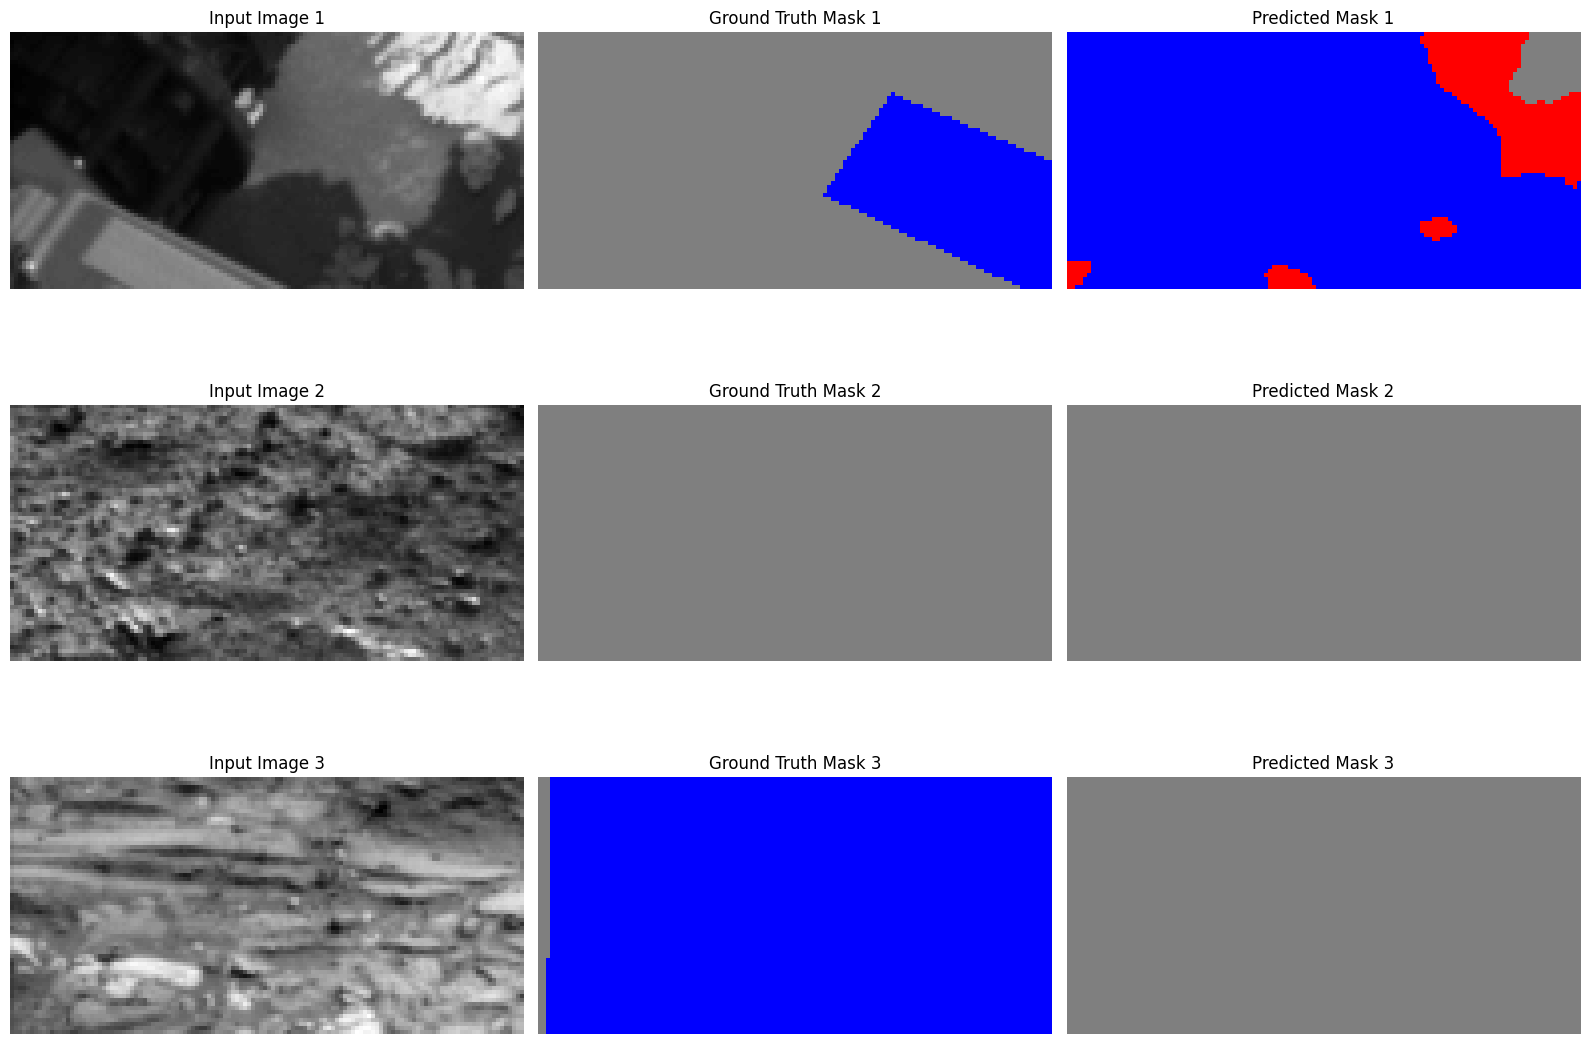

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.7005 - loss: 0.6324 - mean_iou: 0.8062 - val_accuracy: 0.6643 - val_loss: 1.1577 - val_mean_iou: 0.6882 - learning_rate: 1.2500e-04
Epoch 92/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7013 - loss: 0.6286 - mean_iou: 0.8099 - val_accuracy: 0.6635 - val_loss: 1.1071 - val_mean_iou: 0.6552 - learning_rate: 1.2500e-04
Epoch 93/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7012 - loss: 0.6275 - mean_iou: 0.8051 - val_accuracy: 0.6642 - val_loss: 1.1550 - val_mean_iou: 0.6687 - learning_rate: 1.2500e-04
Epoch 94/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7021 - loss: 0.6234 - mean_iou: 0.8121 - val_accuracy: 0.6608 - val_loss: 1.1754 - val_mean_iou: 0.6747 - learning_rate: 1.2500e-04
Epoch 95/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7030 - loss: 0.6198 - mean_iou: 0.8144 - val_accuracy: 0.6629 - val_loss: 1.1212 - val_mean_iou: 0.6665 - learning_rate: 1.2500e-04
Epoch 96/500


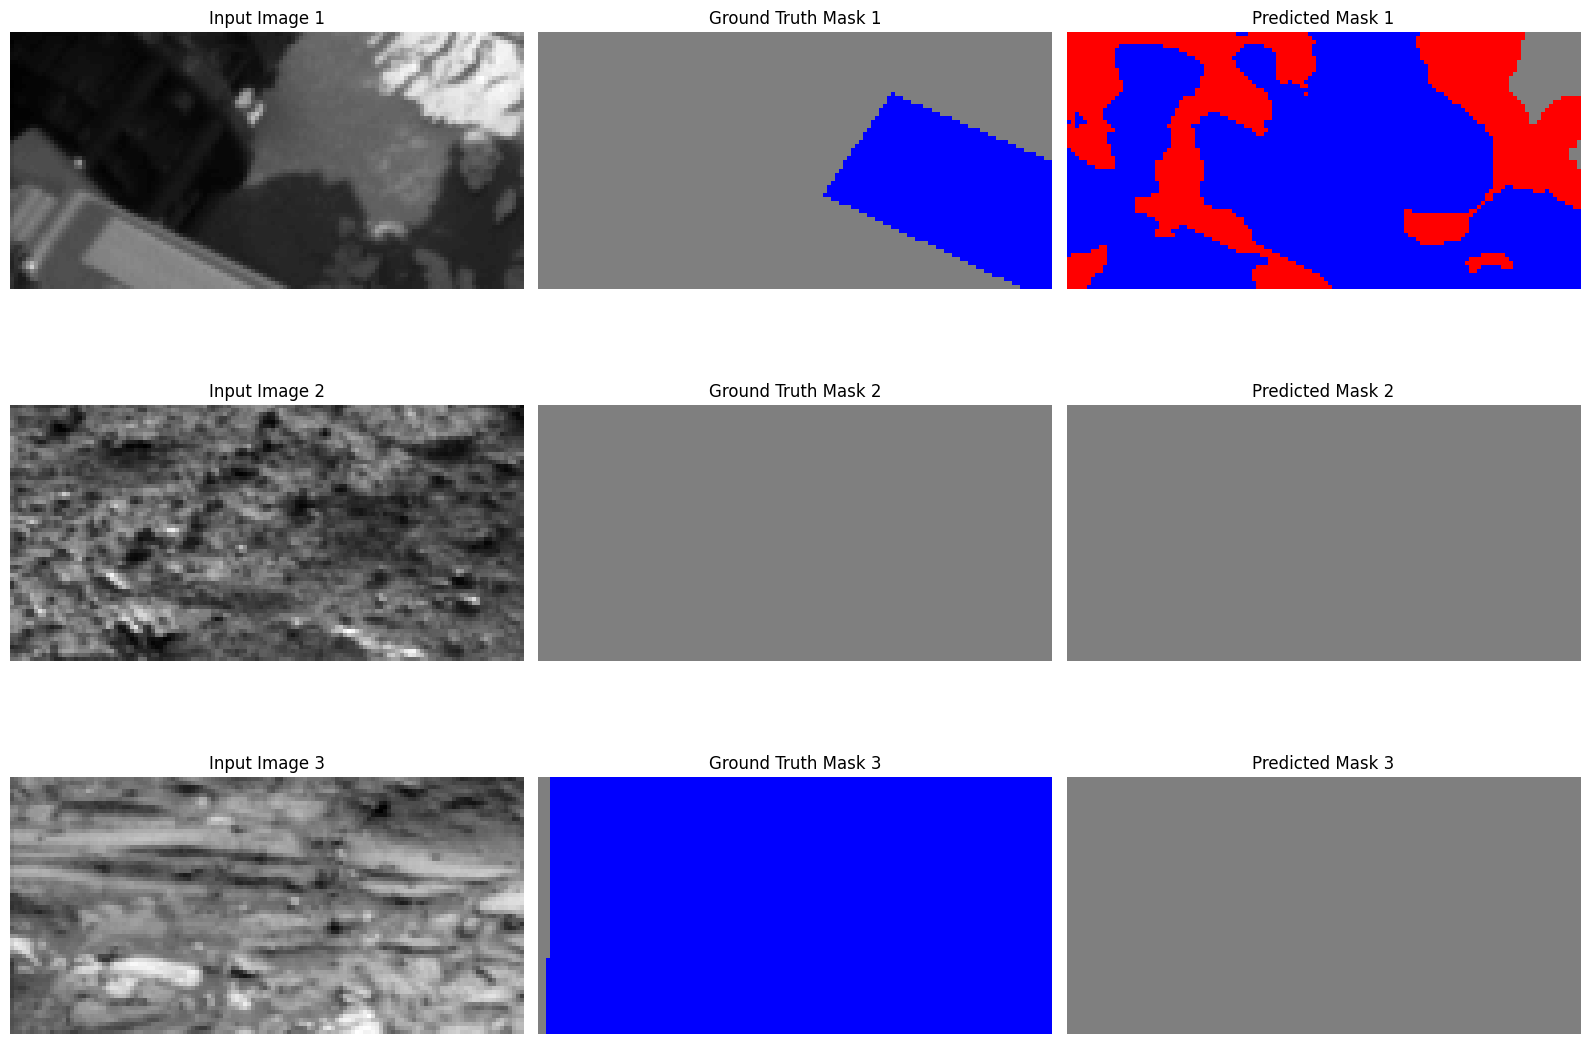

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.7037 - loss: 0.6169 - mean_iou: 0.8145 - val_accuracy: 0.6635 - val_loss: 1.1156 - val_mean_iou: 0.6623 - learning_rate: 1.2500e-04
Epoch 97/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7030 - loss: 0.6148 - mean_iou: 0.8101 - val_accuracy: 0.6556 - val_loss: 1.1677 - val_mean_iou: 0.6487 - learning_rate: 1.2500e-04
Epoch 98/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7034 - loss: 0.6119 - mean_iou: 0.8121 - val_accuracy: 0.6571 - val_loss: 1.2100 - val_mean_iou: 0.6336 - learning_rate: 1.2500e-04
Epoch 99/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6985 - loss: 0.6324 - mean_iou: 0.7699 - val_accuracy: 0.6479 - val_loss: 1.0268 - val_mean_iou: 0.6154 - learning_rate: 1.2500e-04
Epoch 100/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7006 - loss: 0.6205 - mean_iou: 0.7840 - val_accuracy: 0.6653 - val_loss: 1.0059 - val_mean_iou: 0.6795 - learning_rate: 1.2500e-04
Epoch 101/50

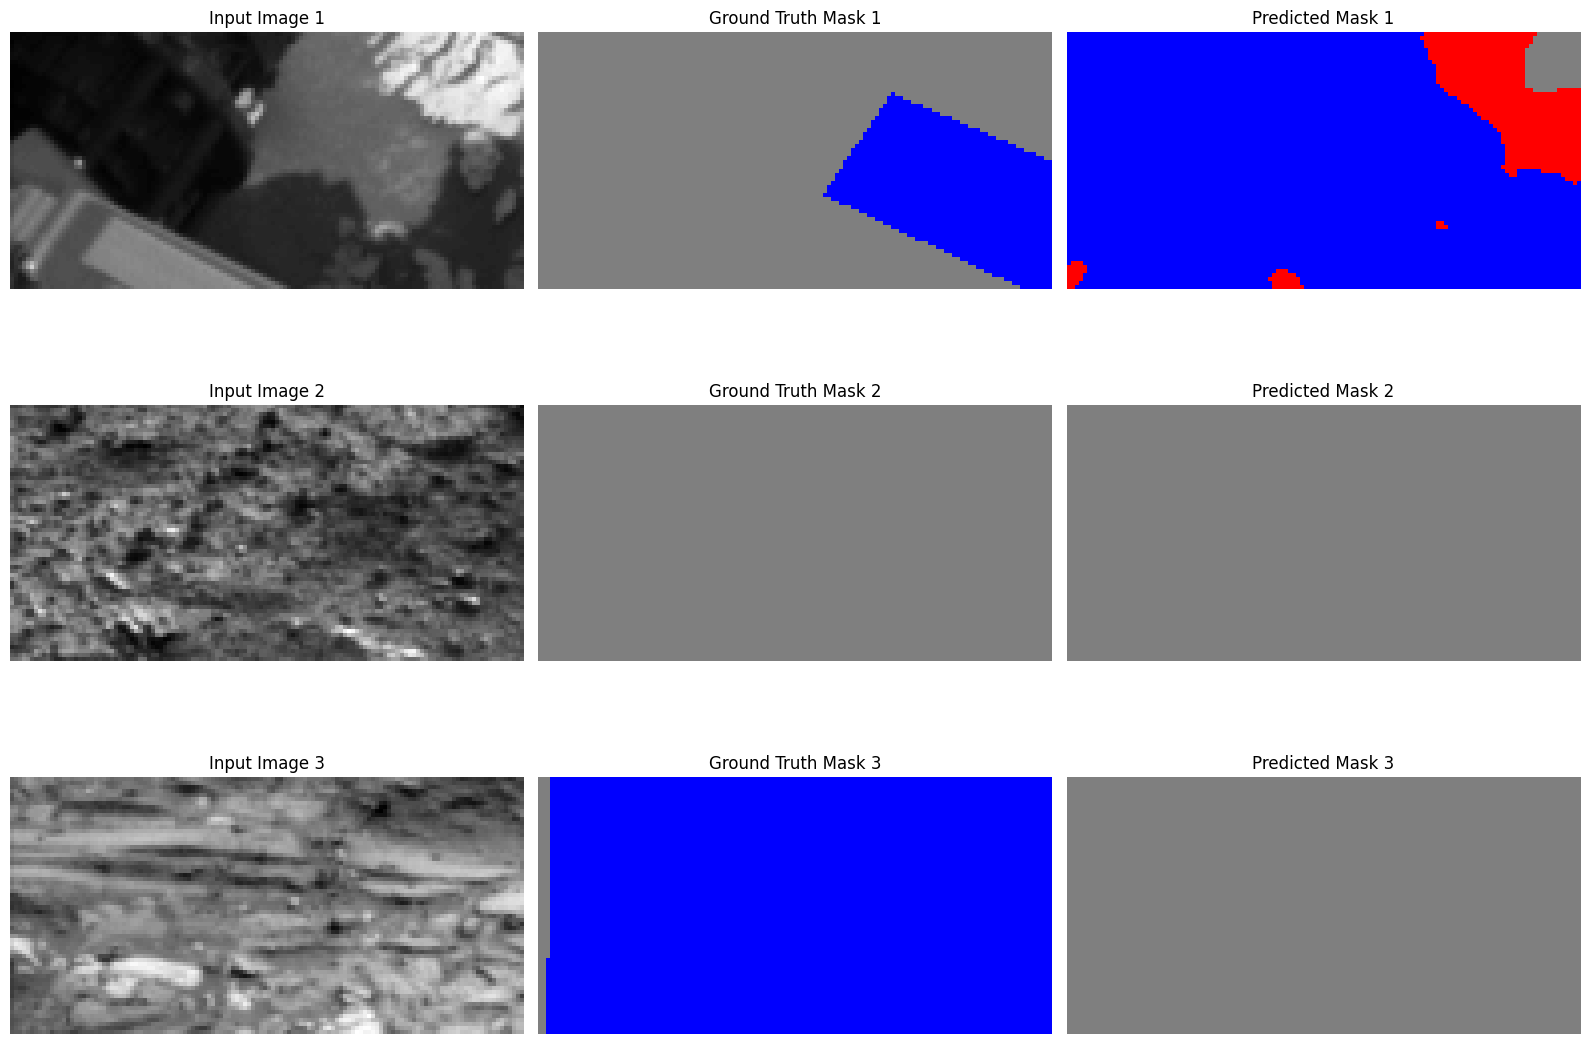

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.7043 - loss: 0.6080 - mean_iou: 0.8089 - val_accuracy: 0.6620 - val_loss: 1.0600 - val_mean_iou: 0.6579 - learning_rate: 1.2500e-04
Epoch 102/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7026 - loss: 0.6075 - mean_iou: 0.8064 - val_accuracy: 0.6520 - val_loss: 1.2331 - val_mean_iou: 0.6678 - learning_rate: 1.2500e-04
Epoch 103/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7049 - loss: 0.6019 - mean_iou: 0.8113 - val_accuracy: 0.6572 - val_loss: 1.1586 - val_mean_iou: 0.6584 - learning_rate: 1.2500e-04
Epoch 104/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7045 - loss: 0.5987 - mean_iou: 0.8186 - val_accuracy: 0.6645 - val_loss: 1.1230 - val_mean_iou: 0.6765 - learning_rate: 1.2500e-04
Epoch 105/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7061 - loss: 0.5938 - mean_iou: 0.8252 - val_accuracy: 0.6393 - val_loss: 1.2340 - val_mean_iou: 0.6085 - learning_rate: 1.2500e-04
Epoch 106

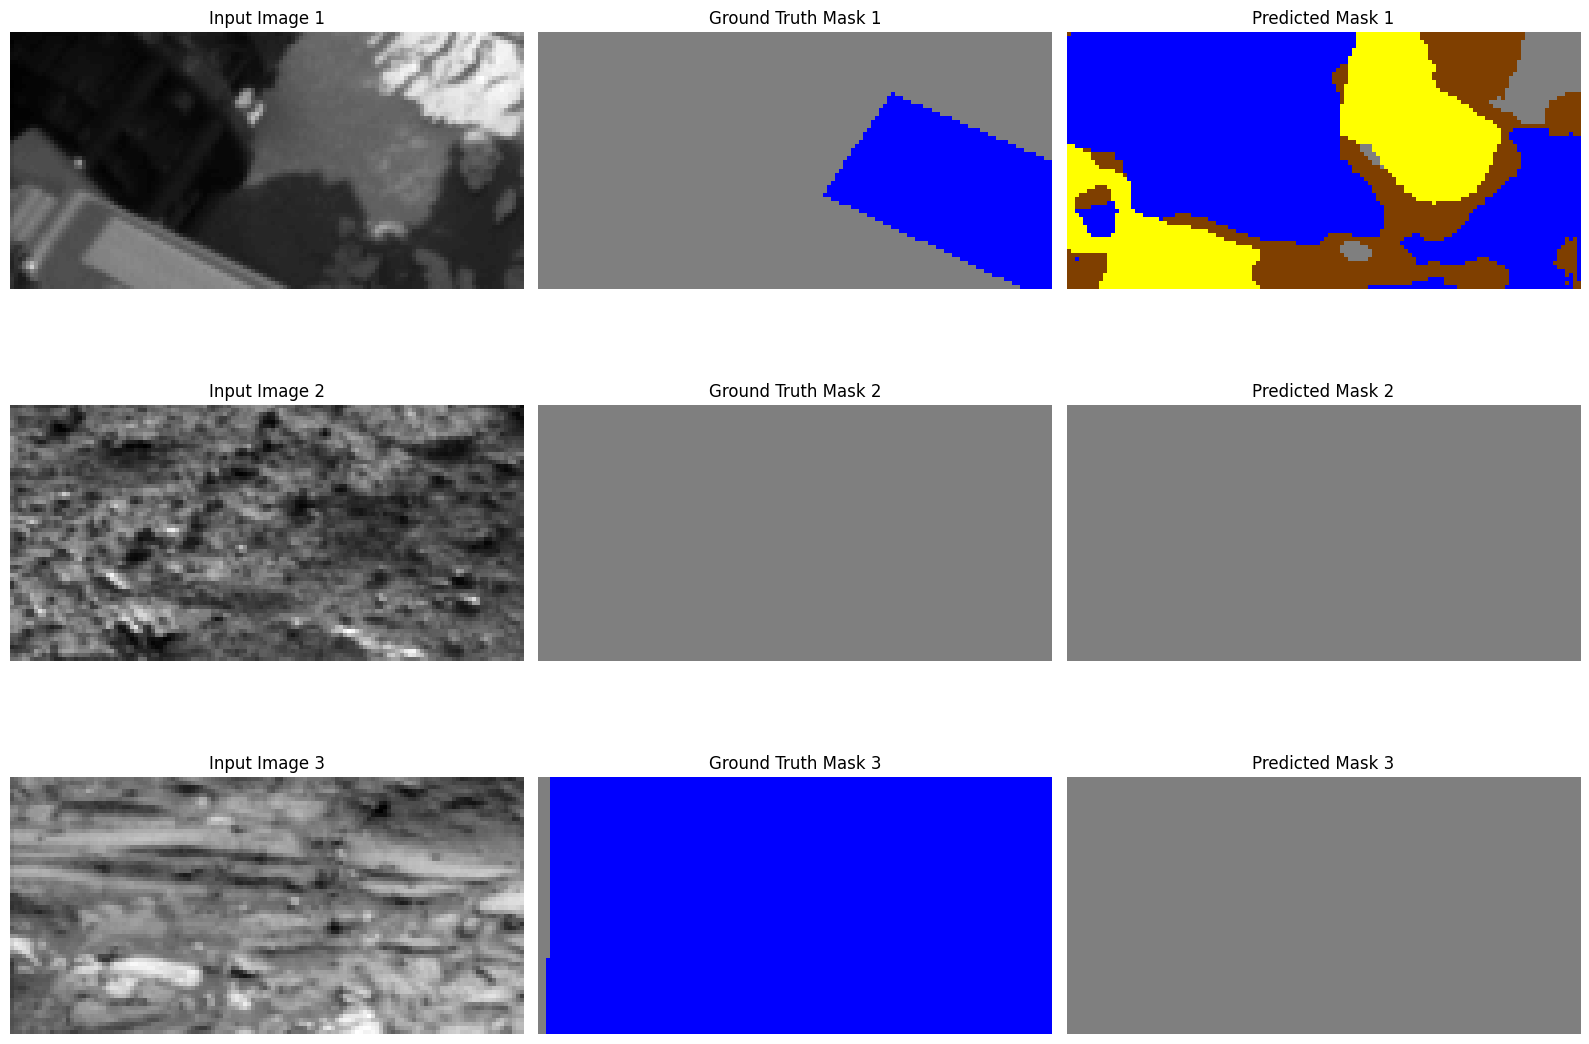

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.6961 - loss: 0.6312 - mean_iou: 0.7823 - val_accuracy: 0.6344 - val_loss: 1.2002 - val_mean_iou: 0.5865 - learning_rate: 1.2500e-04
Epoch 107/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7012 - loss: 0.6107 - mean_iou: 0.7843 - val_accuracy: 0.6522 - val_loss: 1.1206 - val_mean_iou: 0.6397 - learning_rate: 1.2500e-04
Epoch 108/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7059 - loss: 0.5940 - mean_iou: 0.8228 - val_accuracy: 0.6447 - val_loss: 1.1721 - val_mean_iou: 0.6496 - learning_rate: 1.2500e-04
Epoch 109/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7070 - loss: 0.5896 - mean_iou: 0.8238 - val_accuracy: 0.6624 - val_loss: 1.0519 - val_mean_iou: 0.6512 - learning_rate: 1.2500e-04
Epoch 110/500
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.7070 - loss: 0.5849 - mean_iou: 0.8313
Epoch 110: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
32/32 ━━━━━━━━━━━━━━━━━━━

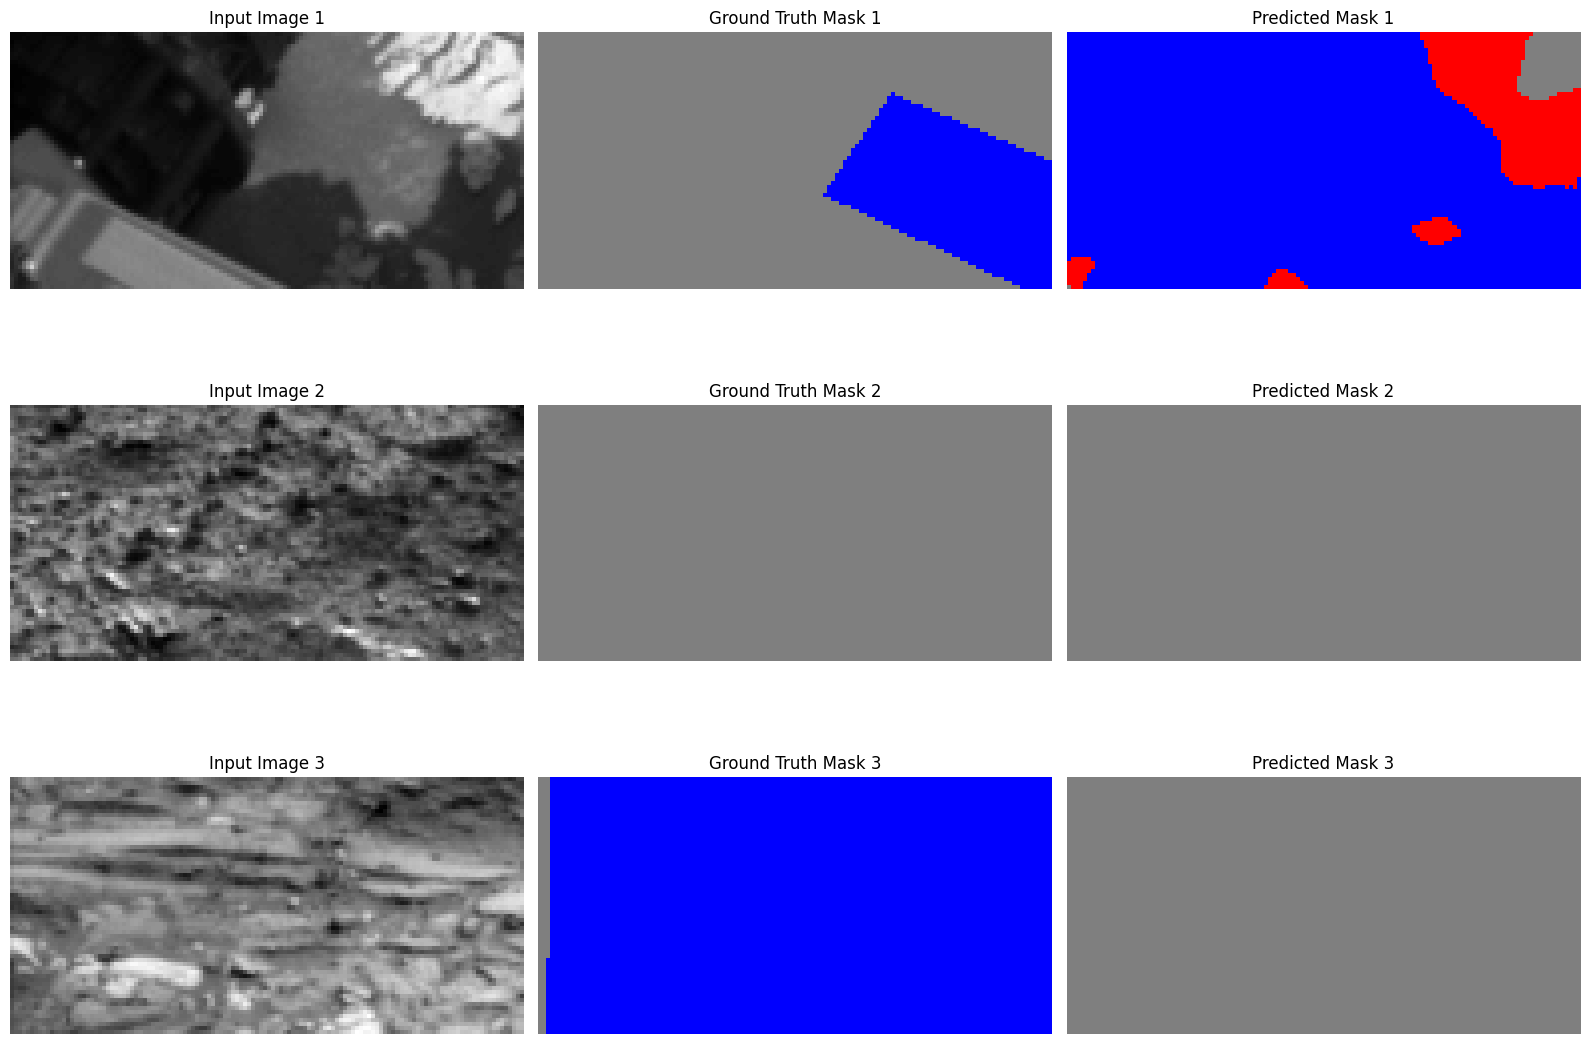

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.7086 - loss: 0.5804 - mean_iou: 0.8245 - val_accuracy: 0.6696 - val_loss: 1.0734 - val_mean_iou: 0.6914 - learning_rate: 6.2500e-05
Epoch 112/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7085 - loss: 0.5768 - mean_iou: 0.8273 - val_accuracy: 0.6724 - val_loss: 1.1266 - val_mean_iou: 0.7139 - learning_rate: 6.2500e-05
Epoch 113/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7090 - loss: 0.5751 - mean_iou: 0.8350 - val_accuracy: 0.6711 - val_loss: 1.1214 - val_mean_iou: 0.6952 - learning_rate: 6.2500e-05
Epoch 114/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7096 - loss: 0.5732 - mean_iou: 0.8344 - val_accuracy: 0.6724 - val_loss: 1.1197 - val_mean_iou: 0.7032 - learning_rate: 6.2500e-05
Epoch 115/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.7106 - loss: 0.5700 - mean_iou: 0.8416 - val_accuracy: 0.6745 - val_loss: 1.0944 - val_mean_iou: 0.6886 - learning_rate: 6.2500e-05
Epoch 116

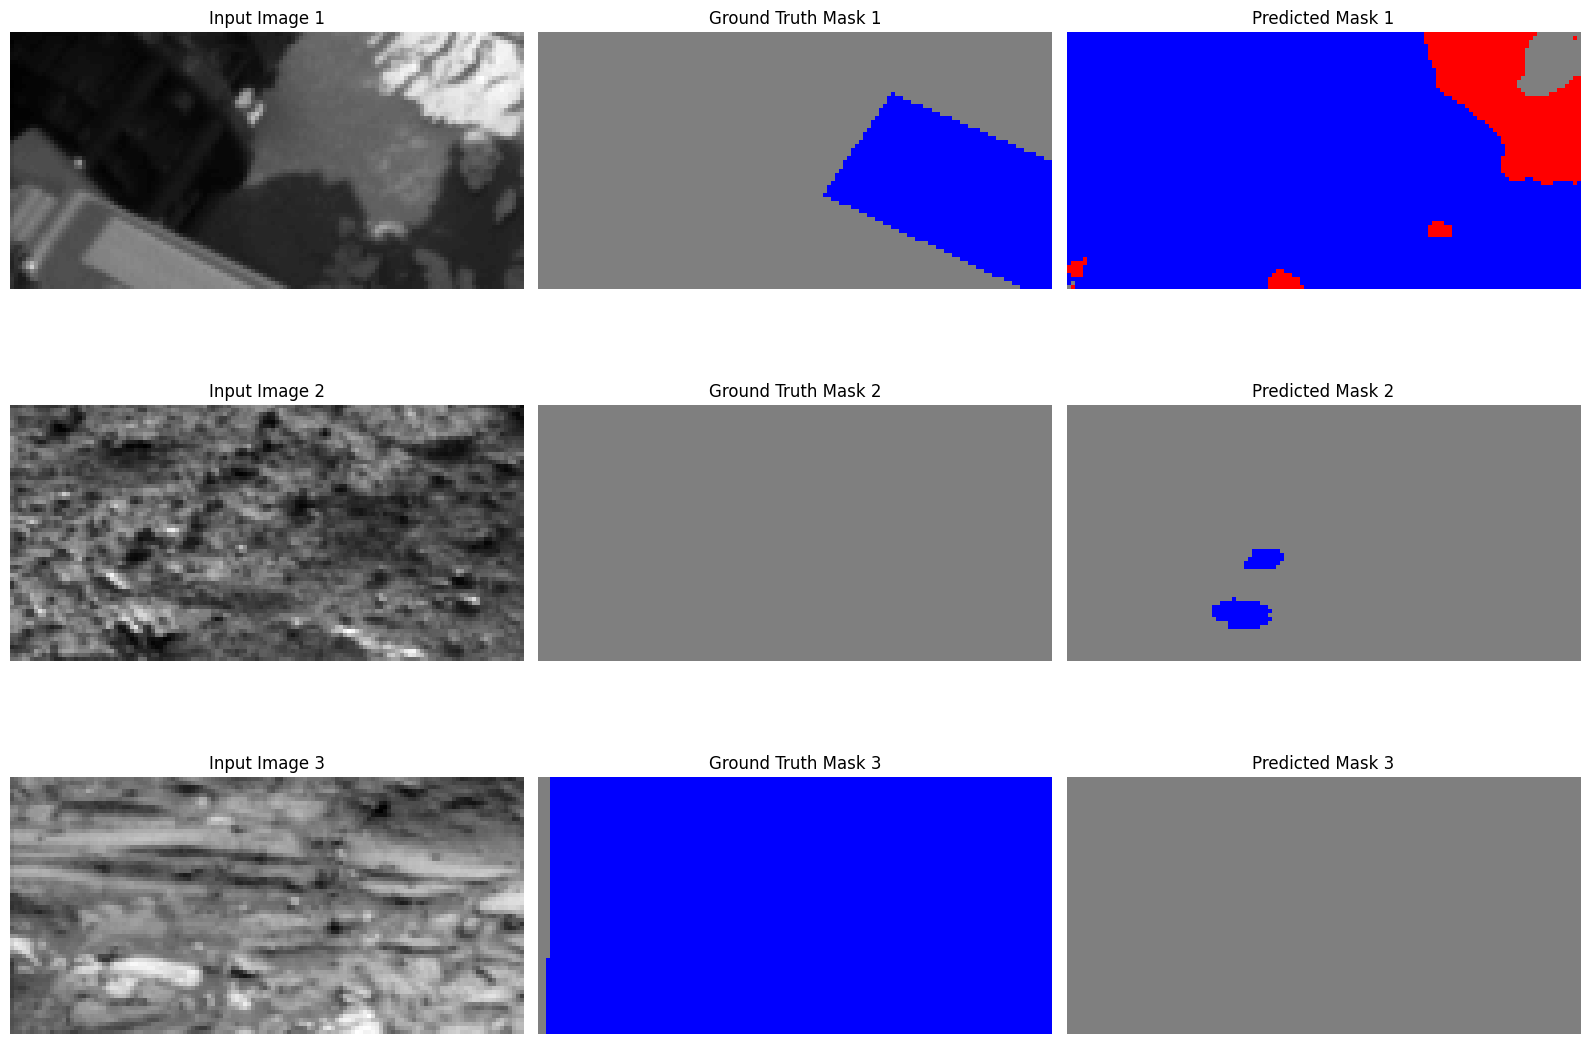

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.7111 - loss: 0.5681 - mean_iou: 0.8391 - val_accuracy: 0.6752 - val_loss: 1.0897 - val_mean_iou: 0.6988 - learning_rate: 6.2500e-05
Epoch 117/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.7121 - loss: 0.5656 - mean_iou: 0.8448 - val_accuracy: 0.6754 - val_loss: 1.1097 - val_mean_iou: 0.6948 - learning_rate: 6.2500e-05
Epoch 118/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7123 - loss: 0.5647 - mean_iou: 0.8432 - val_accuracy: 0.6753 - val_loss: 1.1320 - val_mean_iou: 0.7007 - learning_rate: 6.2500e-05
Epoch 119/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7122 - loss: 0.5641 - mean_iou: 0.8406 - val_accuracy: 0.6771 - val_loss: 1.0909 - val_mean_iou: 0.6886 - learning_rate: 6.2500e-05
Epoch 120/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7125 - loss: 0.5630 - mean_iou: 0.8391 - val_accuracy: 0.6716 - val_loss: 1.1067 - val_mean_iou: 0.6772 - learning_rate: 6.2500e-05
Epoch 121

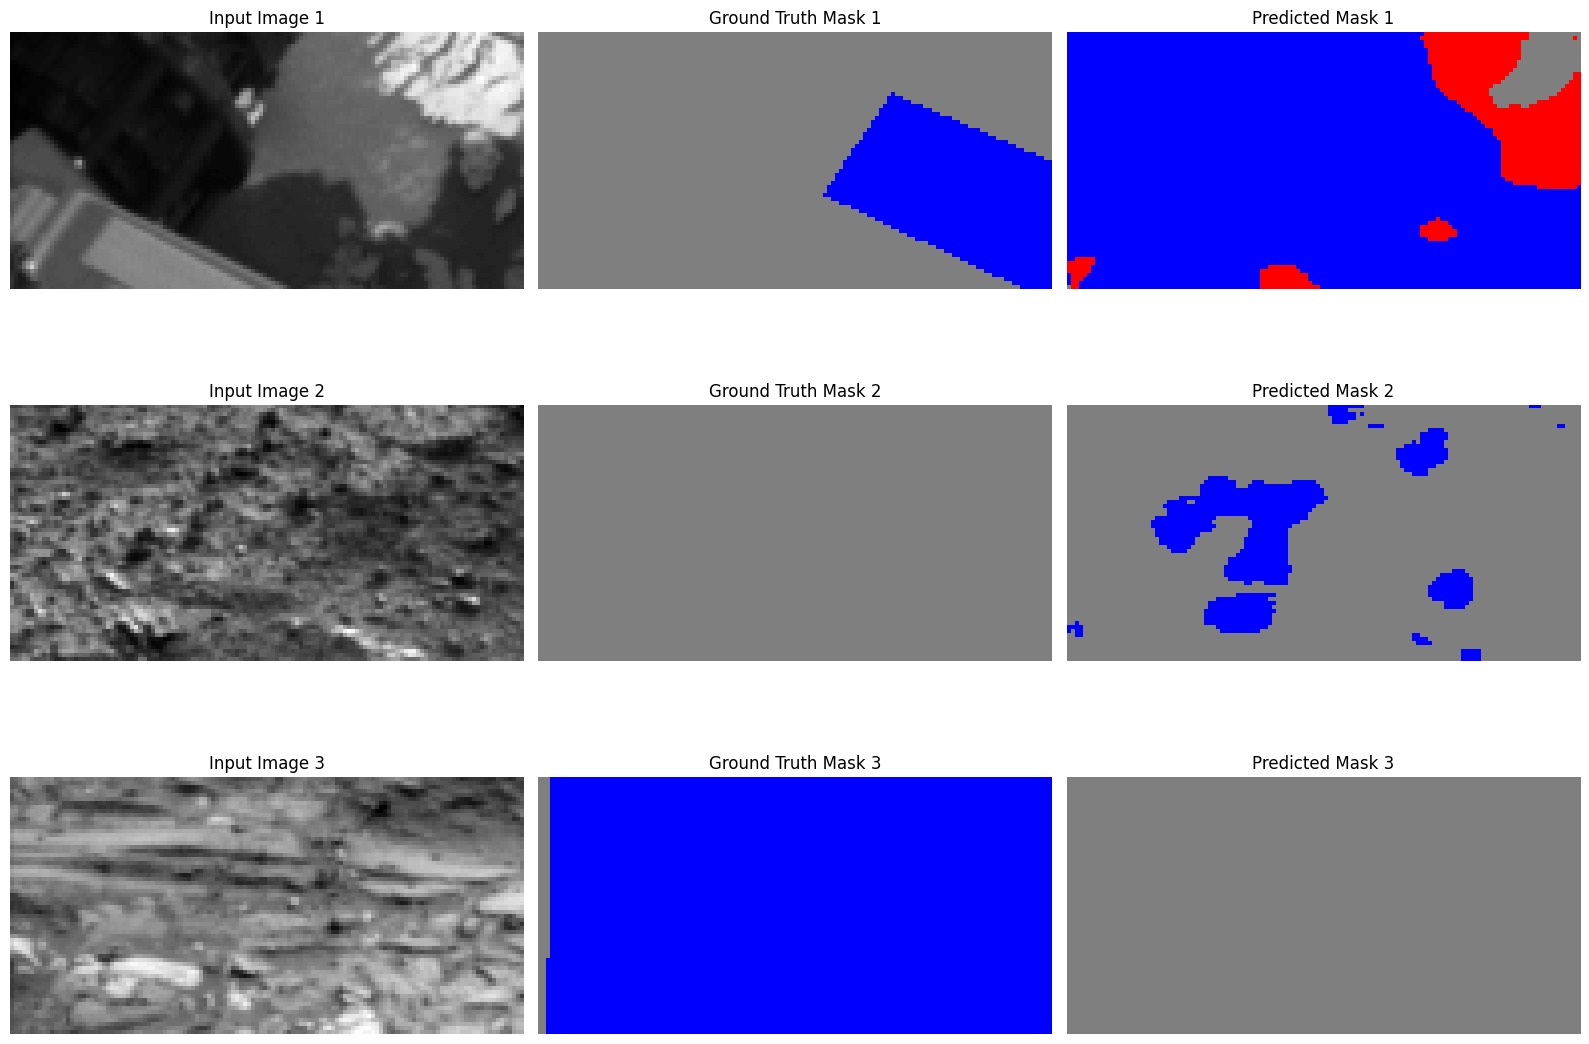

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.7117 - loss: 0.5628 - mean_iou: 0.8345 - val_accuracy: 0.6774 - val_loss: 1.1377 - val_mean_iou: 0.7014 - learning_rate: 6.2500e-05
Epoch 122/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7130 - loss: 0.5591 - mean_iou: 0.8389 - val_accuracy: 0.6759 - val_loss: 1.1509 - val_mean_iou: 0.6923 - learning_rate: 6.2500e-05
Epoch 123/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7134 - loss: 0.5580 - mean_iou: 0.8454 - val_accuracy: 0.6750 - val_loss: 1.1697 - val_mean_iou: 0.6896 - learning_rate: 6.2500e-05
Epoch 124/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7132 - loss: 0.5564 - mean_iou: 0.8424 - val_accuracy: 0.6745 - val_loss: 1.1480 - val_mean_iou: 0.6858 - learning_rate: 6.2500e-05
Epoch 125/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7137 - loss: 0.5553 - mean_iou: 0.8439 - val_accuracy: 0.6755 - val_loss: 1.1498 - val_mean_iou: 0.6885 - learning_rate: 6.2500e-05
Epoch 126

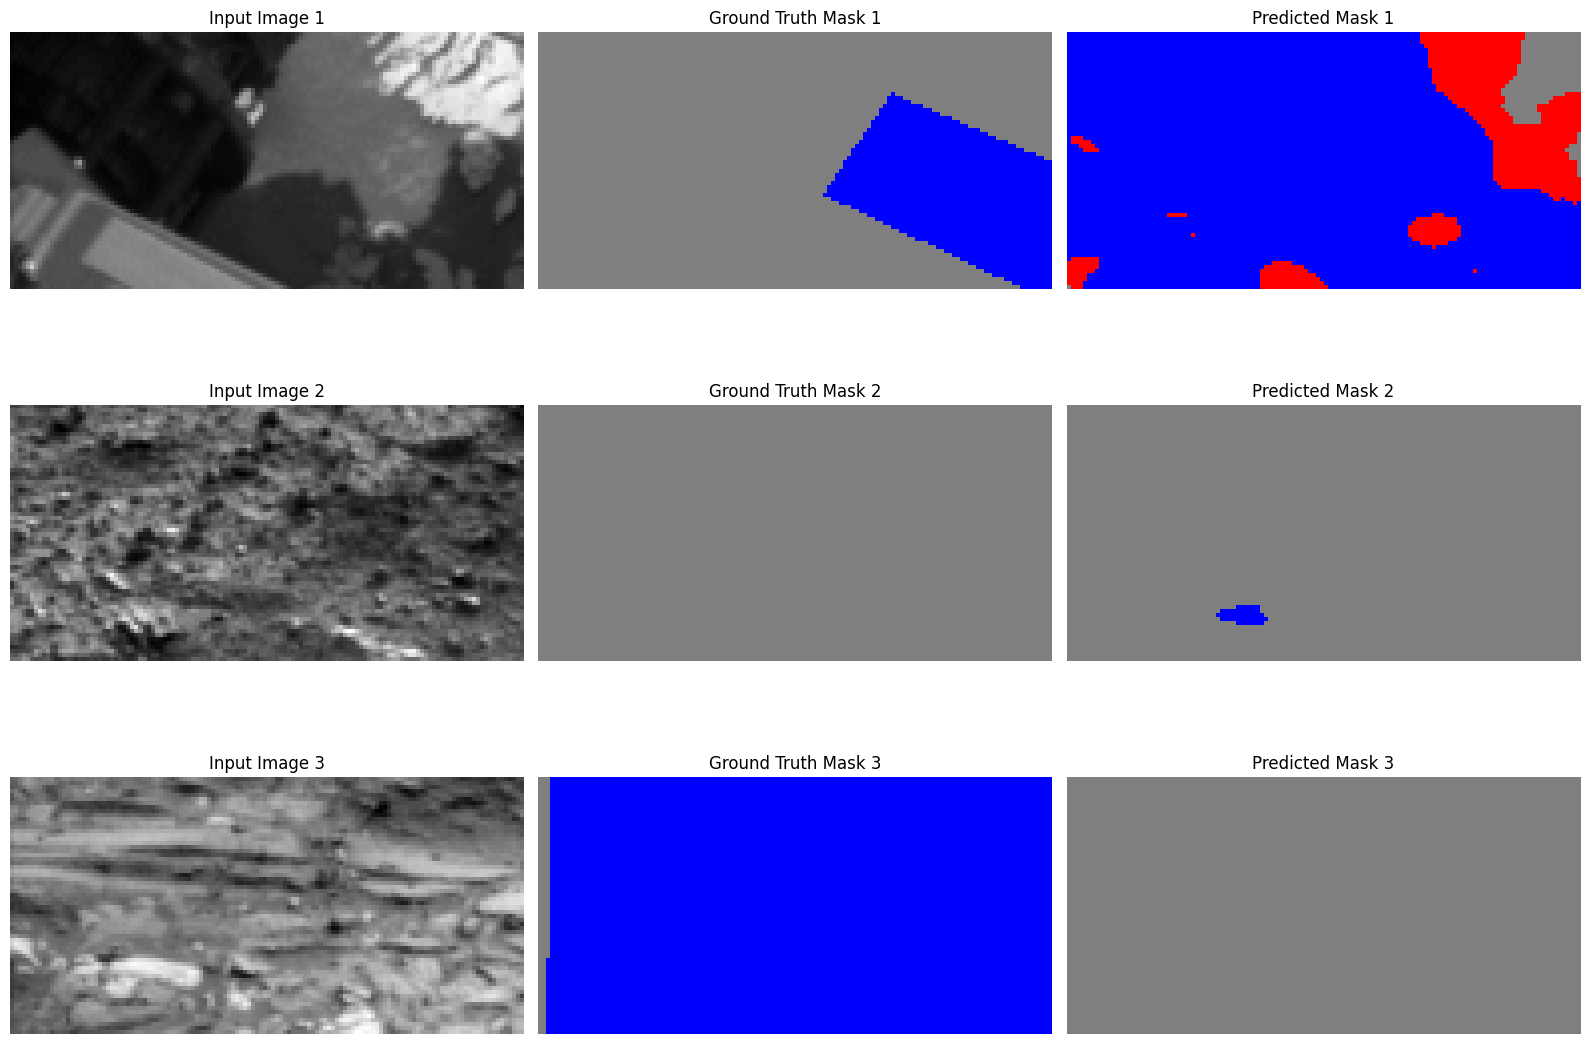

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.7145 - loss: 0.5521 - mean_iou: 0.8496 - val_accuracy: 0.6769 - val_loss: 1.1734 - val_mean_iou: 0.6790 - learning_rate: 6.2500e-05
Epoch 127/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7143 - loss: 0.5522 - mean_iou: 0.8474 - val_accuracy: 0.6787 - val_loss: 1.1317 - val_mean_iou: 0.6859 - learning_rate: 6.2500e-05
Epoch 128/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7143 - loss: 0.5519 - mean_iou: 0.8488 - val_accuracy: 0.6732 - val_loss: 1.1448 - val_mean_iou: 0.6741 - learning_rate: 6.2500e-05
Epoch 129/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7131 - loss: 0.5525 - mean_iou: 0.8466 - val_accuracy: 0.6786 - val_loss: 1.1430 - val_mean_iou: 0.6874 - learning_rate: 6.2500e-05
Epoch 130/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7145 - loss: 0.5479 - mean_iou: 0.8524 - val_accuracy: 0.6782 - val_loss: 1.1900 - val_mean_iou: 0.6809 - learning_rate: 6.2500e-05
Epoch 131

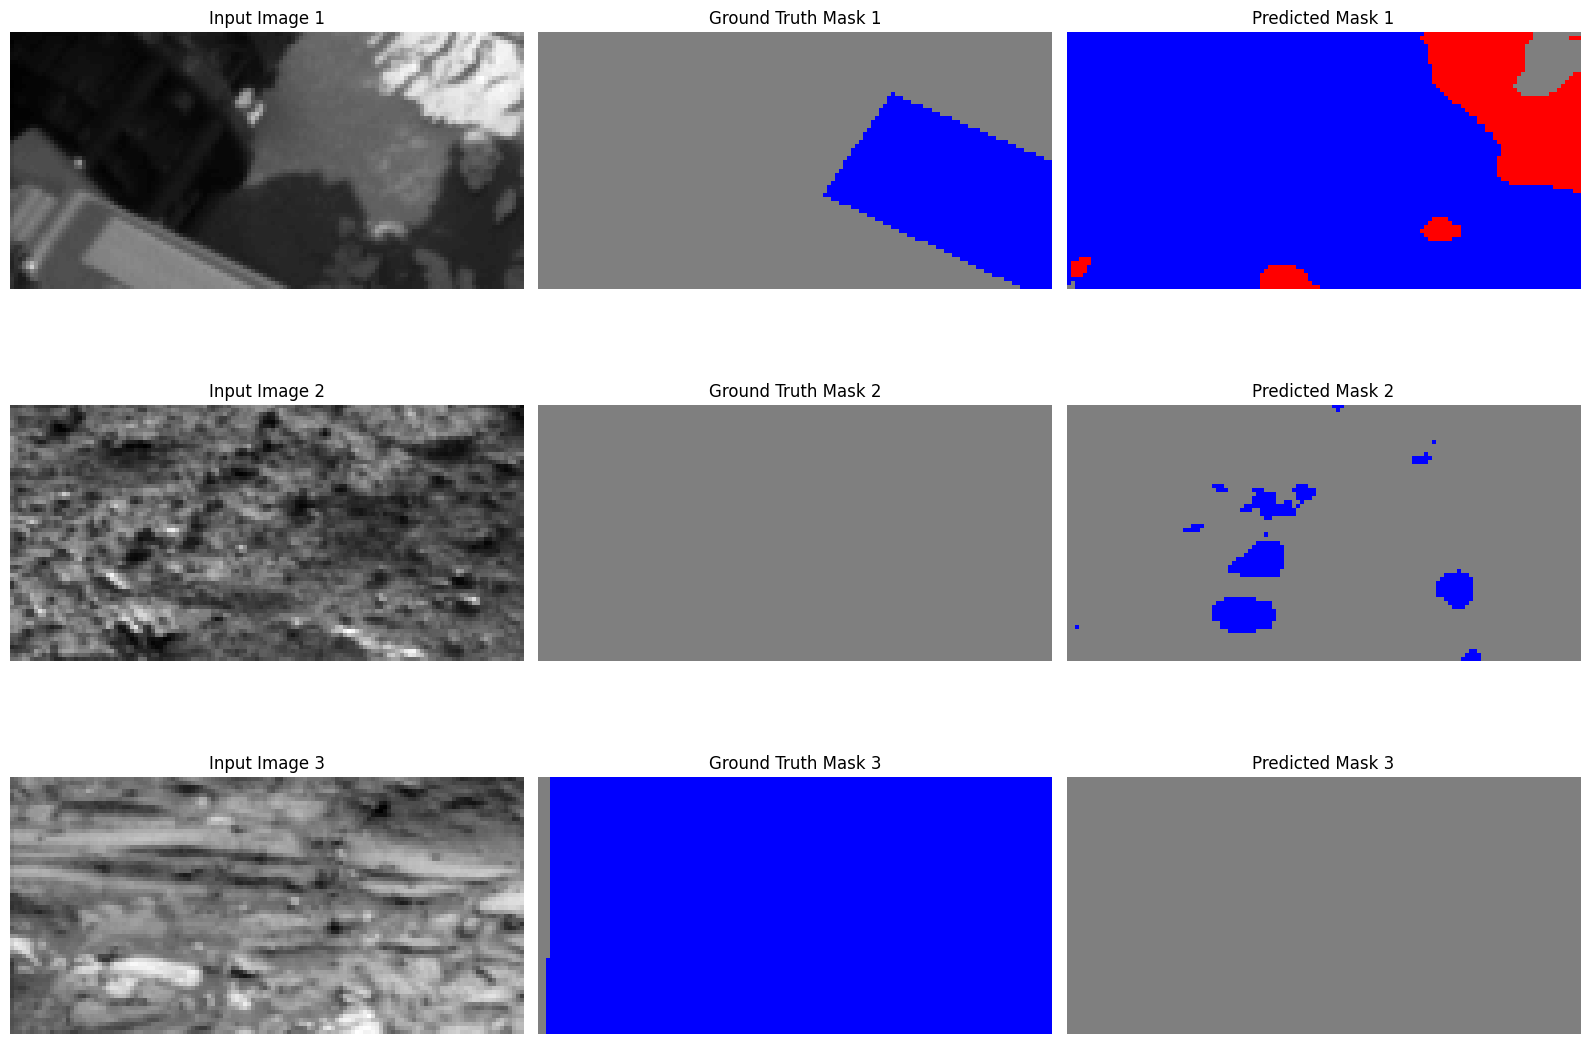

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.7157 - loss: 0.5462 - mean_iou: 0.8554 - val_accuracy: 0.6766 - val_loss: 1.1639 - val_mean_iou: 0.6813 - learning_rate: 6.2500e-05
Epoch 132/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7157 - loss: 0.5446 - mean_iou: 0.8564 - val_accuracy: 0.6759 - val_loss: 1.2011 - val_mean_iou: 0.6884 - learning_rate: 6.2500e-05
Epoch 133/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7160 - loss: 0.5439 - mean_iou: 0.8555 - val_accuracy: 0.6717 - val_loss: 1.1749 - val_mean_iou: 0.6743 - learning_rate: 6.2500e-05
Epoch 134/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7092 - loss: 0.5655 - mean_iou: 0.8360 - val_accuracy: 0.6712 - val_loss: 1.1364 - val_mean_iou: 0.6672 - learning_rate: 6.2500e-05
Epoch 135/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7132 - loss: 0.5493 - mean_iou: 0.8411 - val_accuracy: 0.6745 - val_loss: 1.2064 - val_mean_iou: 0.6756 - learning_rate: 6.2500e-05
Epoch 136

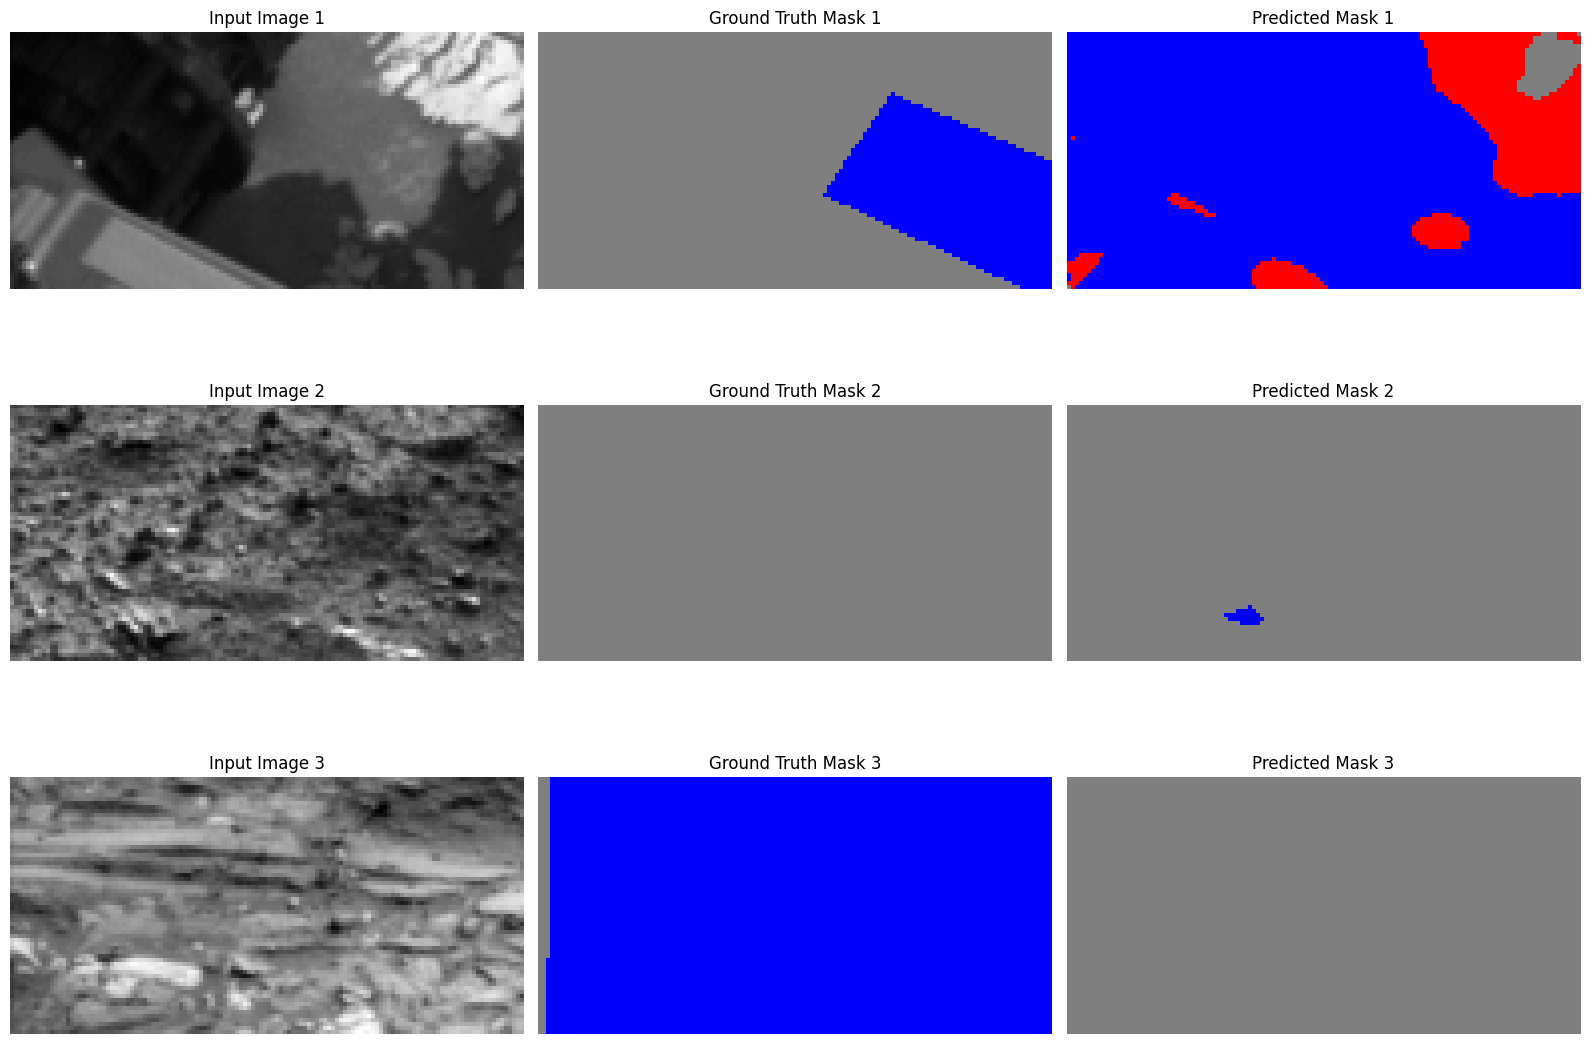

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.7138 - loss: 0.5496 - mean_iou: 0.8234 - val_accuracy: 0.6715 - val_loss: 1.0700 - val_mean_iou: 0.6588 - learning_rate: 6.2500e-05
Epoch 137/500
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.7146 - loss: 0.5434 - mean_iou: 0.8456
Epoch 137: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7153 - loss: 0.5427 - mean_iou: 0.8465 - val_accuracy: 0.6720 - val_loss: 1.1720 - val_mean_iou: 0.6857 - learning_rate: 6.2500e-05
Epoch 138/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.7160 - loss: 0.5393 - mean_iou: 0.8490 - val_accuracy: 0.6788 - val_loss: 1.1837 - val_mean_iou: 0.6940 - learning_rate: 3.1250e-05
Epoch 139/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.7169 - loss: 0.5368 - mean_iou: 0.8556 - val_accuracy: 0.6789 - val_loss: 1.2018 - val_mean_iou: 0.6943 - learning_rate: 3.1250e-05
Epoch 140/500
32/32 ━━━━━━━━━━━━━━━━━━

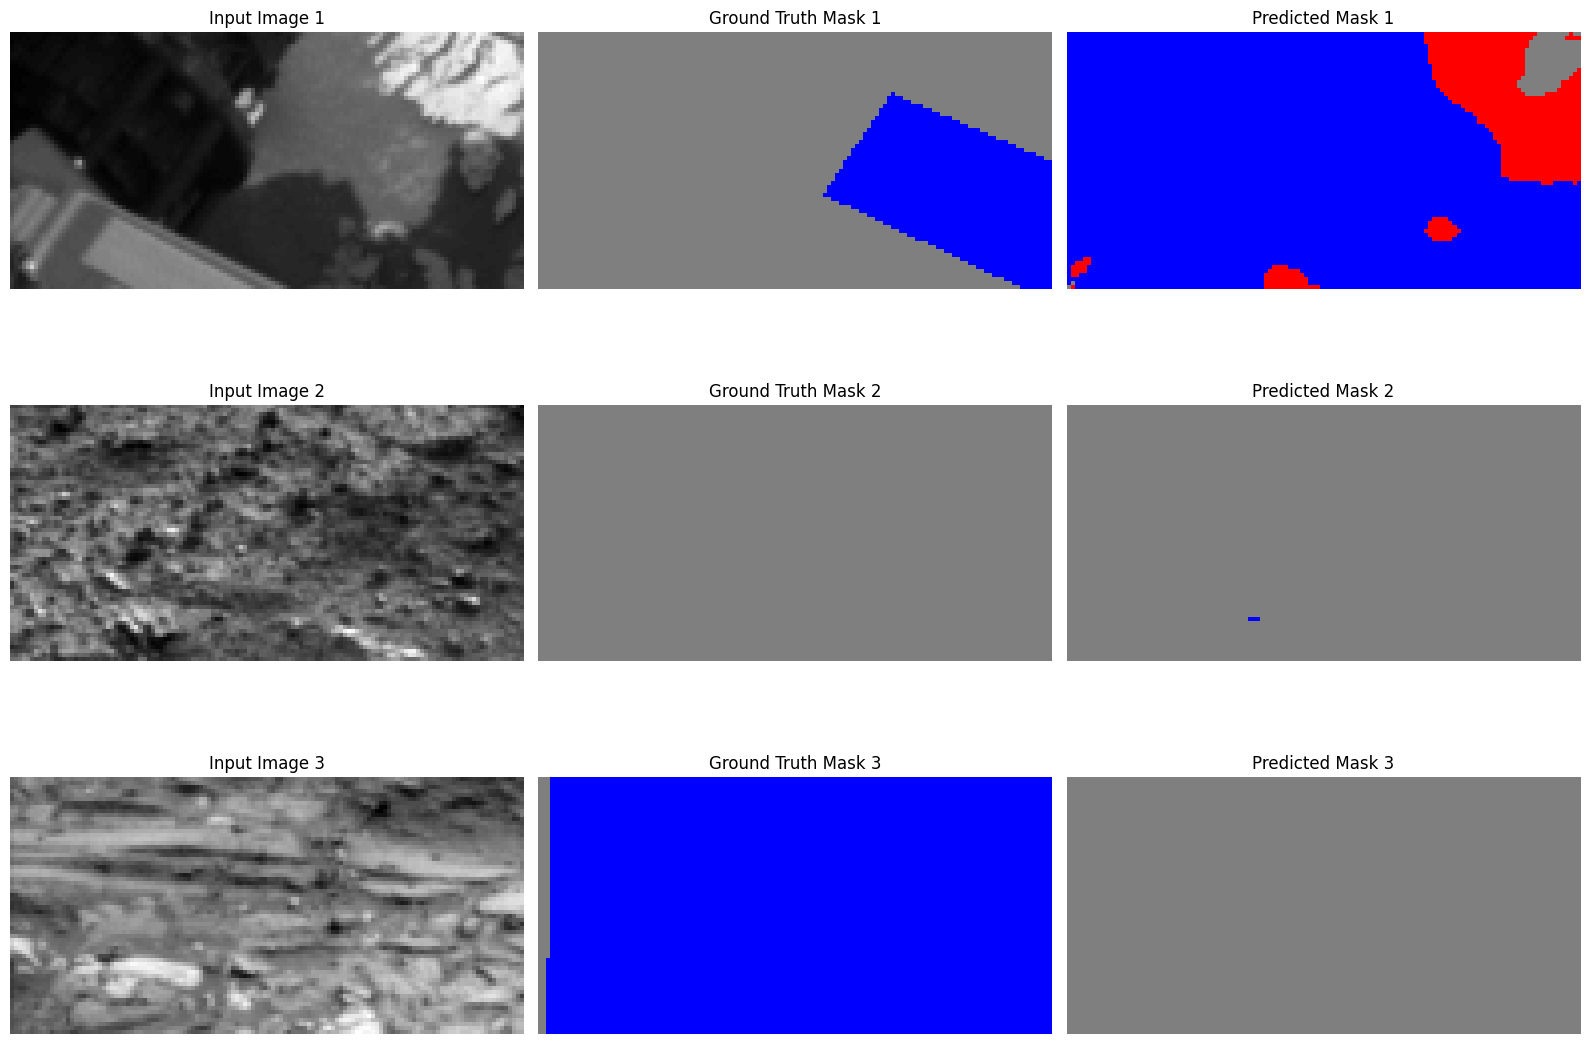

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.7171 - loss: 0.5349 - mean_iou: 0.8577 - val_accuracy: 0.6780 - val_loss: 1.2174 - val_mean_iou: 0.6906 - learning_rate: 3.1250e-05
Epoch 142/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7174 - loss: 0.5334 - mean_iou: 0.8587 - val_accuracy: 0.6779 - val_loss: 1.2240 - val_mean_iou: 0.6886 - learning_rate: 3.1250e-05
Epoch 143/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7175 - loss: 0.5329 - mean_iou: 0.8619 - val_accuracy: 0.6782 - val_loss: 1.2024 - val_mean_iou: 0.6933 - learning_rate: 3.1250e-05
Epoch 144/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7176 - loss: 0.5319 - mean_iou: 0.8608 - val_accuracy: 0.6790 - val_loss: 1.1984 - val_mean_iou: 0.6933 - learning_rate: 3.1250e-05
Epoch 145/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7177 - loss: 0.5318 - mean_iou: 0.8622 - val_accuracy: 0.6789 - val_loss: 1.2023 - val_mean_iou: 0.6917 - learning_rate: 3.1250e-05
Epoch 146

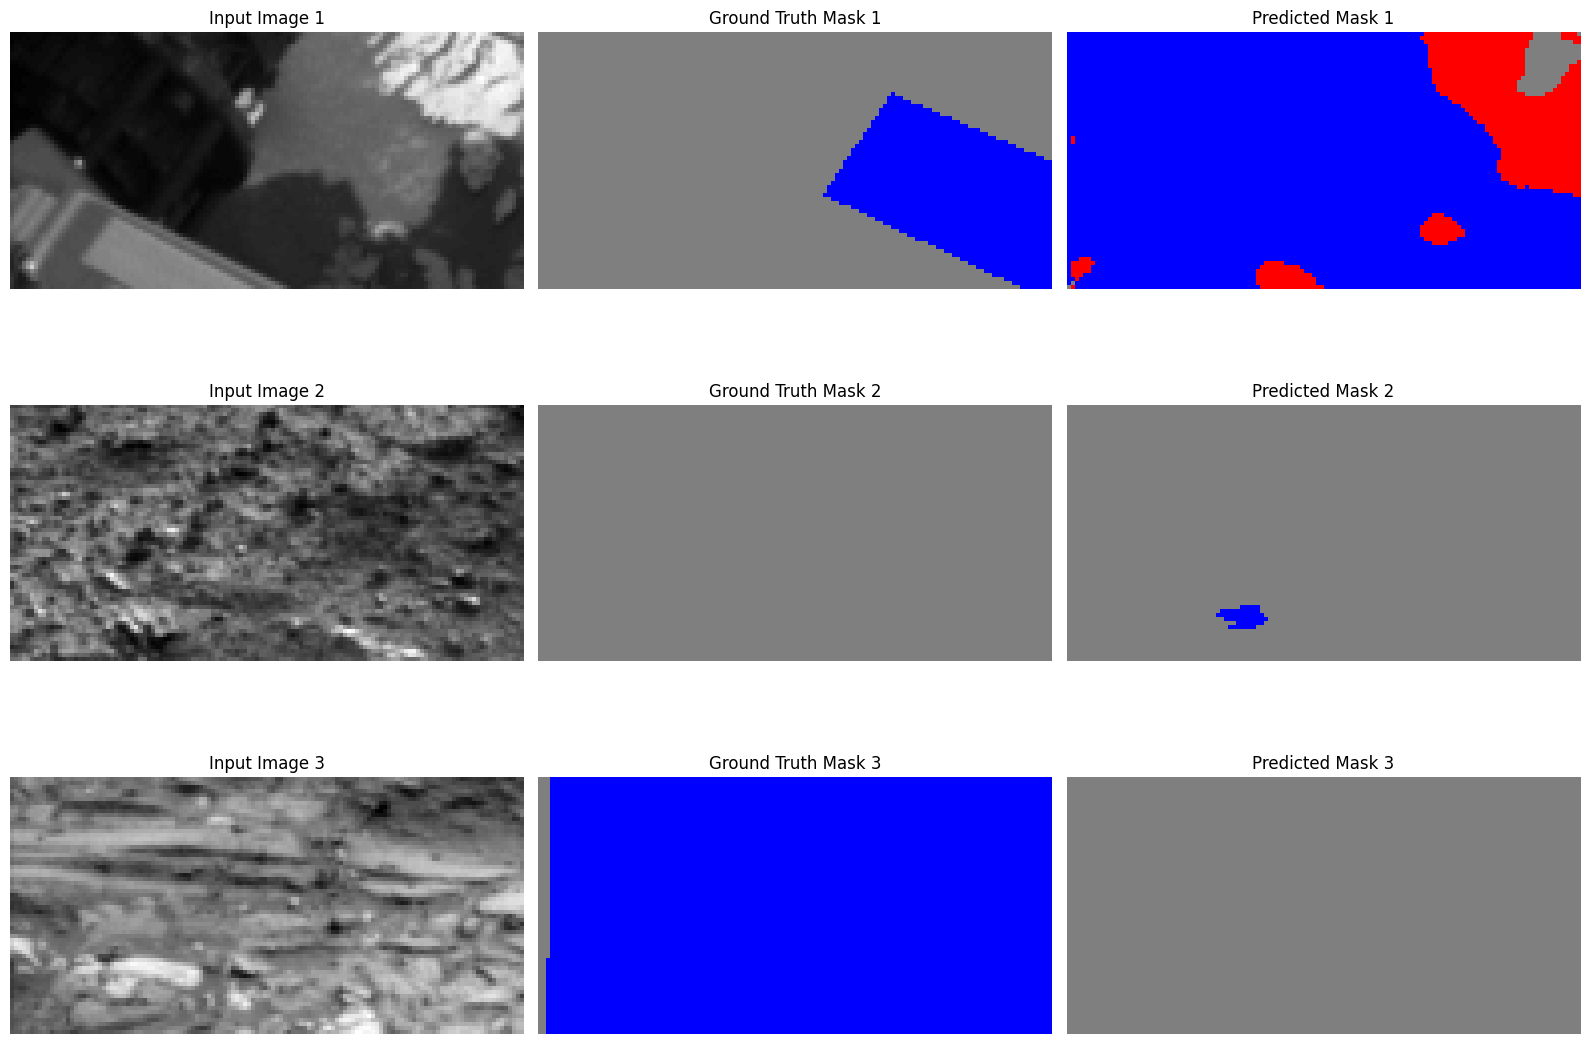

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.7176 - loss: 0.5307 - mean_iou: 0.8609 - val_accuracy: 0.6793 - val_loss: 1.2117 - val_mean_iou: 0.6943 - learning_rate: 3.1250e-05
Epoch 147/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7180 - loss: 0.5300 - mean_iou: 0.8622 - val_accuracy: 0.6786 - val_loss: 1.2247 - val_mean_iou: 0.6909 - learning_rate: 3.1250e-05
Epoch 148/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7179 - loss: 0.5292 - mean_iou: 0.8607 - val_accuracy: 0.6792 - val_loss: 1.2172 - val_mean_iou: 0.6948 - learning_rate: 3.1250e-05
Epoch 149/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.7178 - loss: 0.5289 - mean_iou: 0.8633 - val_accuracy: 0.6801 - val_loss: 1.1964 - val_mean_iou: 0.6958 - learning_rate: 3.1250e-05
Epoch 150/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7184 - loss: 0.5276 - mean_iou: 0.8644 - val_accuracy: 0.6798 - val_loss: 1.1783 - val_mean_iou: 0.6971 - learning_rate: 3.1250e-05
Epoch 151

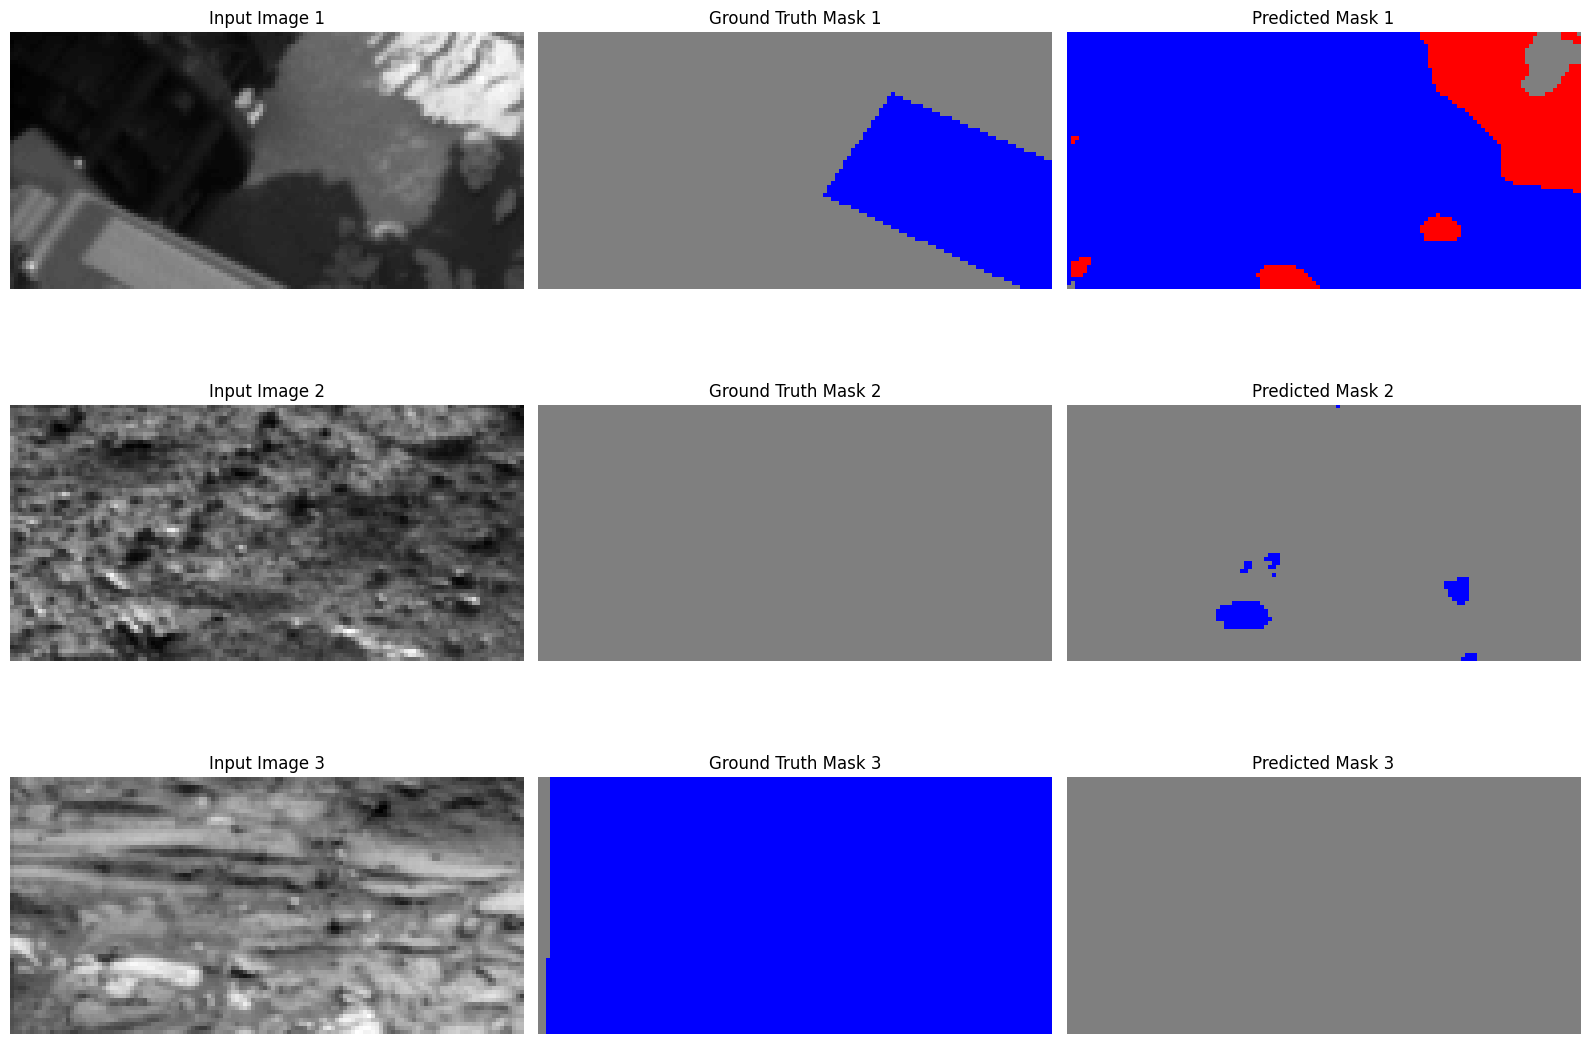

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.7184 - loss: 0.5266 - mean_iou: 0.8651 - val_accuracy: 0.6802 - val_loss: 1.2032 - val_mean_iou: 0.6936 - learning_rate: 3.1250e-05
Epoch 152/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.7187 - loss: 0.5260 - mean_iou: 0.8671 - val_accuracy: 0.6806 - val_loss: 1.2351 - val_mean_iou: 0.6983 - learning_rate: 3.1250e-05
Epoch 153/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.7187 - loss: 0.5258 - mean_iou: 0.8653 - val_accuracy: 0.6813 - val_loss: 1.1908 - val_mean_iou: 0.6936 - learning_rate: 3.1250e-05
Epoch 154/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7188 - loss: 0.5253 - mean_iou: 0.8649 - val_accuracy: 0.6792 - val_loss: 1.2293 - val_mean_iou: 0.6988 - learning_rate: 3.1250e-05
Epoch 155/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7188 - loss: 0.5244 - mean_iou: 0.8652 - val_accuracy: 0.6803 - val_loss: 1.2397 - val_mean_iou: 0.6958 - learning_rate: 3.1250e-05
Epoch 156

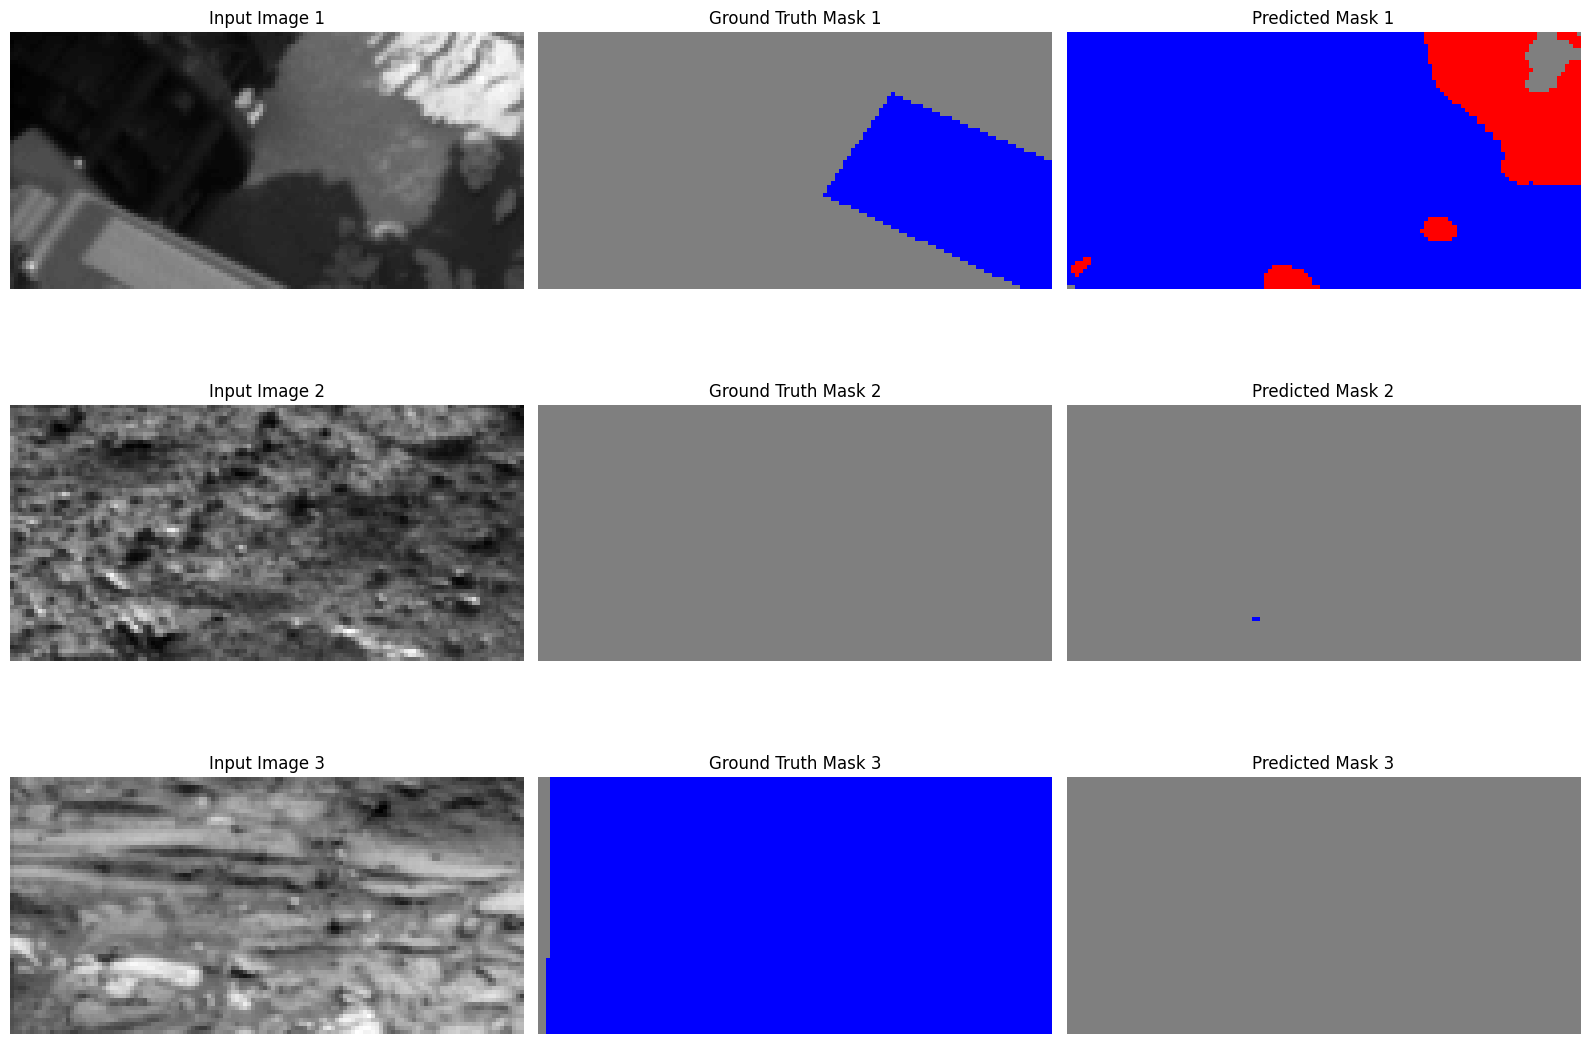

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.7190 - loss: 0.5231 - mean_iou: 0.8688 - val_accuracy: 0.6792 - val_loss: 1.2224 - val_mean_iou: 0.6955 - learning_rate: 3.1250e-05
Epoch 157/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7189 - loss: 0.5230 - mean_iou: 0.8659 - val_accuracy: 0.6806 - val_loss: 1.2359 - val_mean_iou: 0.6997 - learning_rate: 3.1250e-05
Epoch 158/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7193 - loss: 0.5217 - mean_iou: 0.8696 - val_accuracy: 0.6811 - val_loss: 1.2380 - val_mean_iou: 0.7032 - learning_rate: 3.1250e-05
Epoch 159/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7194 - loss: 0.5204 - mean_iou: 0.8713 - val_accuracy: 0.6801 - val_loss: 1.2424 - val_mean_iou: 0.6993 - learning_rate: 3.1250e-05
Epoch 160/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7197 - loss: 0.5196 - mean_iou: 0.8718 - val_accuracy: 0.6818 - val_loss: 1.2264 - val_mean_iou: 0.6934 - learning_rate: 3.1250e-05
Epoch 161

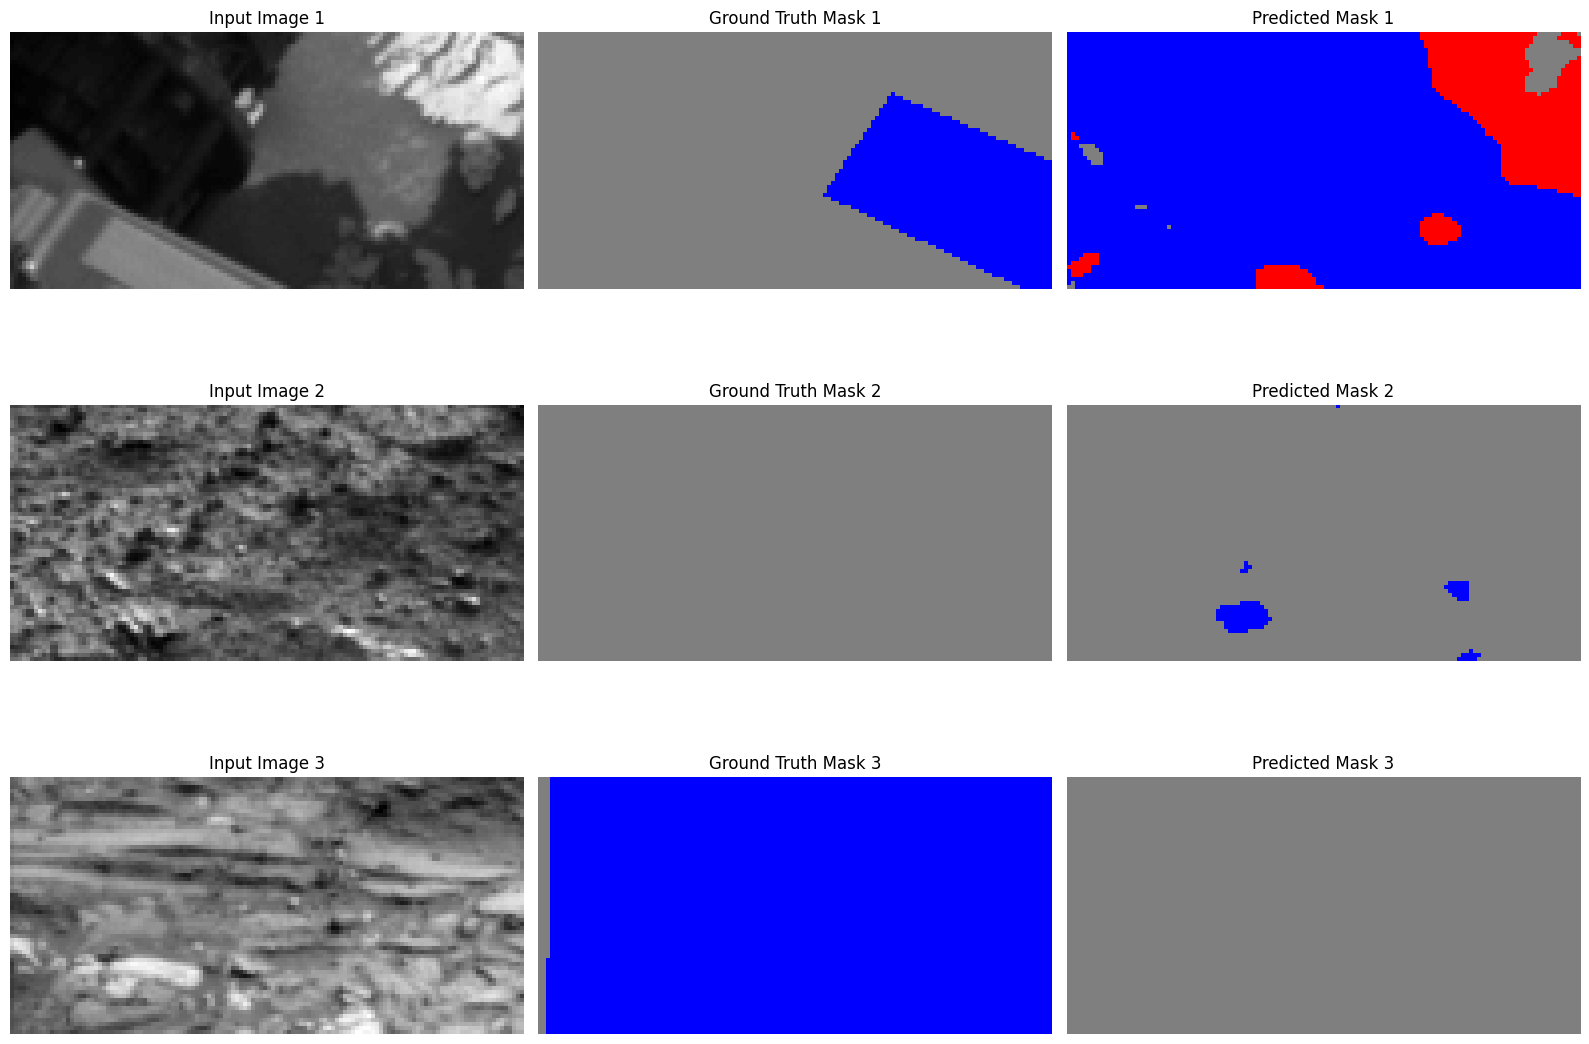

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.7199 - loss: 0.5195 - mean_iou: 0.8698 - val_accuracy: 0.6806 - val_loss: 1.2600 - val_mean_iou: 0.6996 - learning_rate: 3.1250e-05
Epoch 162/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7197 - loss: 0.5195 - mean_iou: 0.8707 - val_accuracy: 0.6810 - val_loss: 1.2545 - val_mean_iou: 0.7024 - learning_rate: 3.1250e-05
Epoch 163/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7197 - loss: 0.5186 - mean_iou: 0.8736 - val_accuracy: 0.6810 - val_loss: 1.2719 - val_mean_iou: 0.7073 - learning_rate: 3.1250e-05
Epoch 164/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7198 - loss: 0.5174 - mean_iou: 0.8720 - val_accuracy: 0.6815 - val_loss: 1.2284 - val_mean_iou: 0.6854 - learning_rate: 3.1250e-05
Epoch 165/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7202 - loss: 0.5173 - mean_iou: 0.8730 - val_accuracy: 0.6809 - val_loss: 1.2758 - val_mean_iou: 0.6990 - learning_rate: 3.1250e-05
Epoch 166

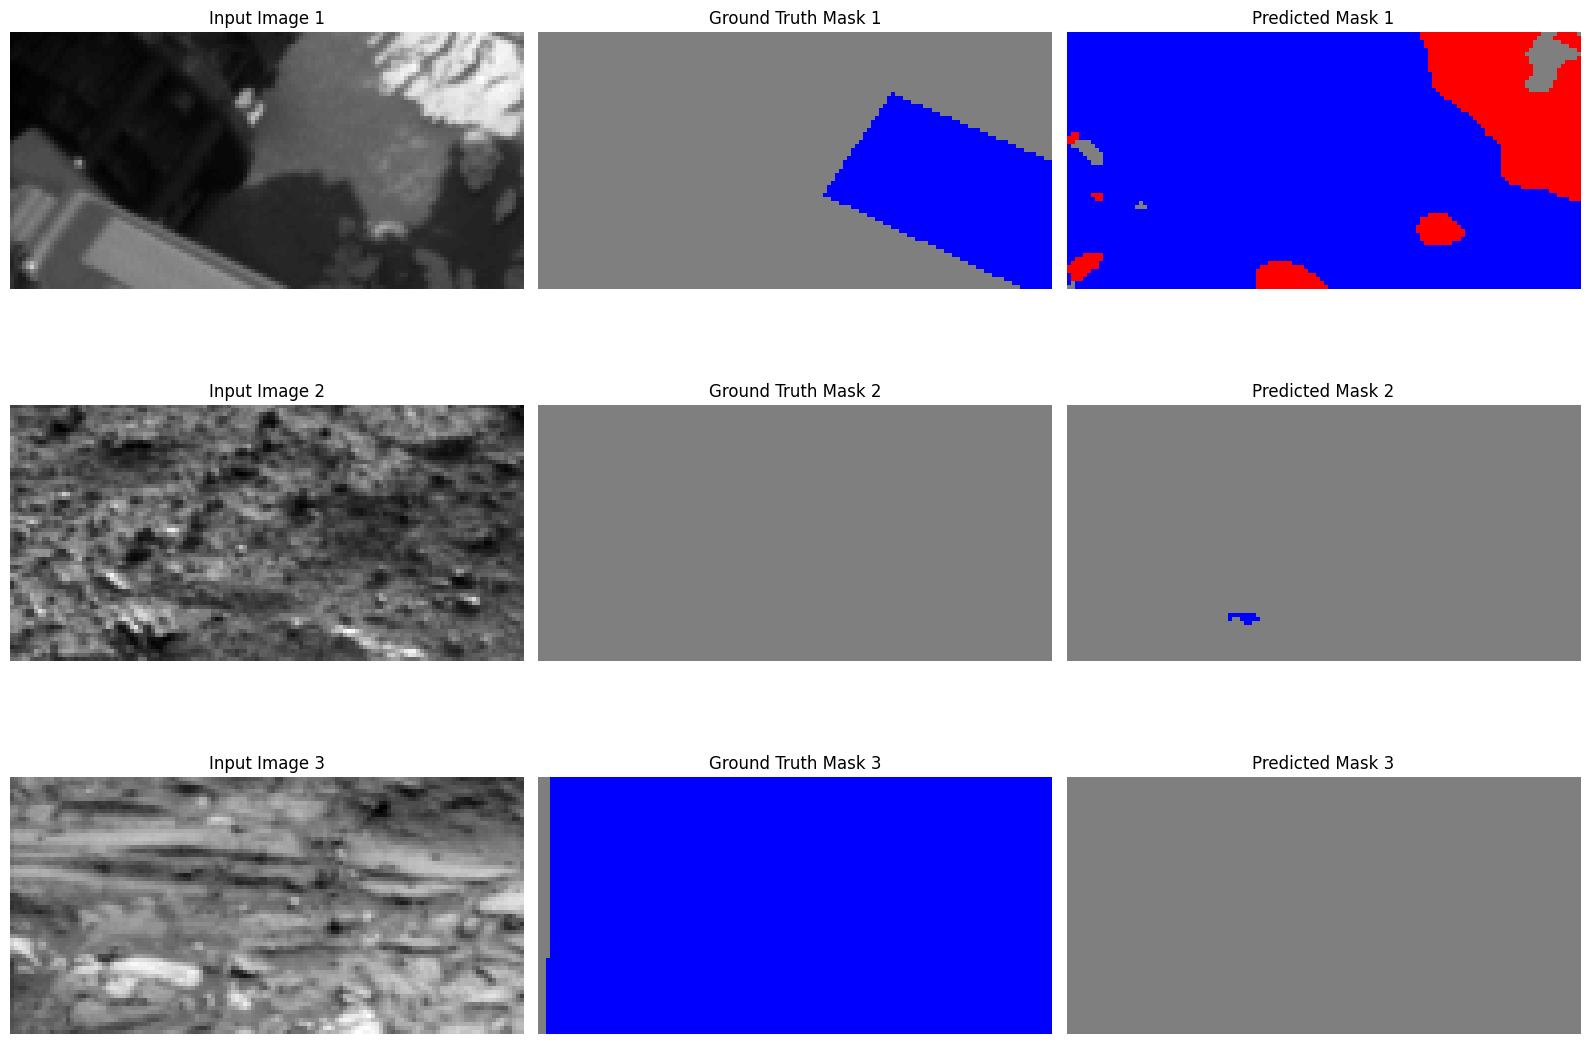

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.7198 - loss: 0.5170 - mean_iou: 0.8705 - val_accuracy: 0.6811 - val_loss: 1.2710 - val_mean_iou: 0.6968 - learning_rate: 3.1250e-05
Epoch 167/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7203 - loss: 0.5152 - mean_iou: 0.8749 - val_accuracy: 0.6820 - val_loss: 1.2757 - val_mean_iou: 0.7030 - learning_rate: 3.1250e-05
Epoch 168/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7204 - loss: 0.5145 - mean_iou: 0.8745 - val_accuracy: 0.6807 - val_loss: 1.2356 - val_mean_iou: 0.6909 - learning_rate: 3.1250e-05
Epoch 169/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7206 - loss: 0.5139 - mean_iou: 0.8771 - val_accuracy: 0.6816 - val_loss: 1.2888 - val_mean_iou: 0.7014 - learning_rate: 3.1250e-05
Epoch 170/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7206 - loss: 0.5135 - mean_iou: 0.8763 - val_accuracy: 0.6802 - val_loss: 1.2353 - val_mean_iou: 0.6938 - learning_rate: 3.1250e-05
Epoch 171

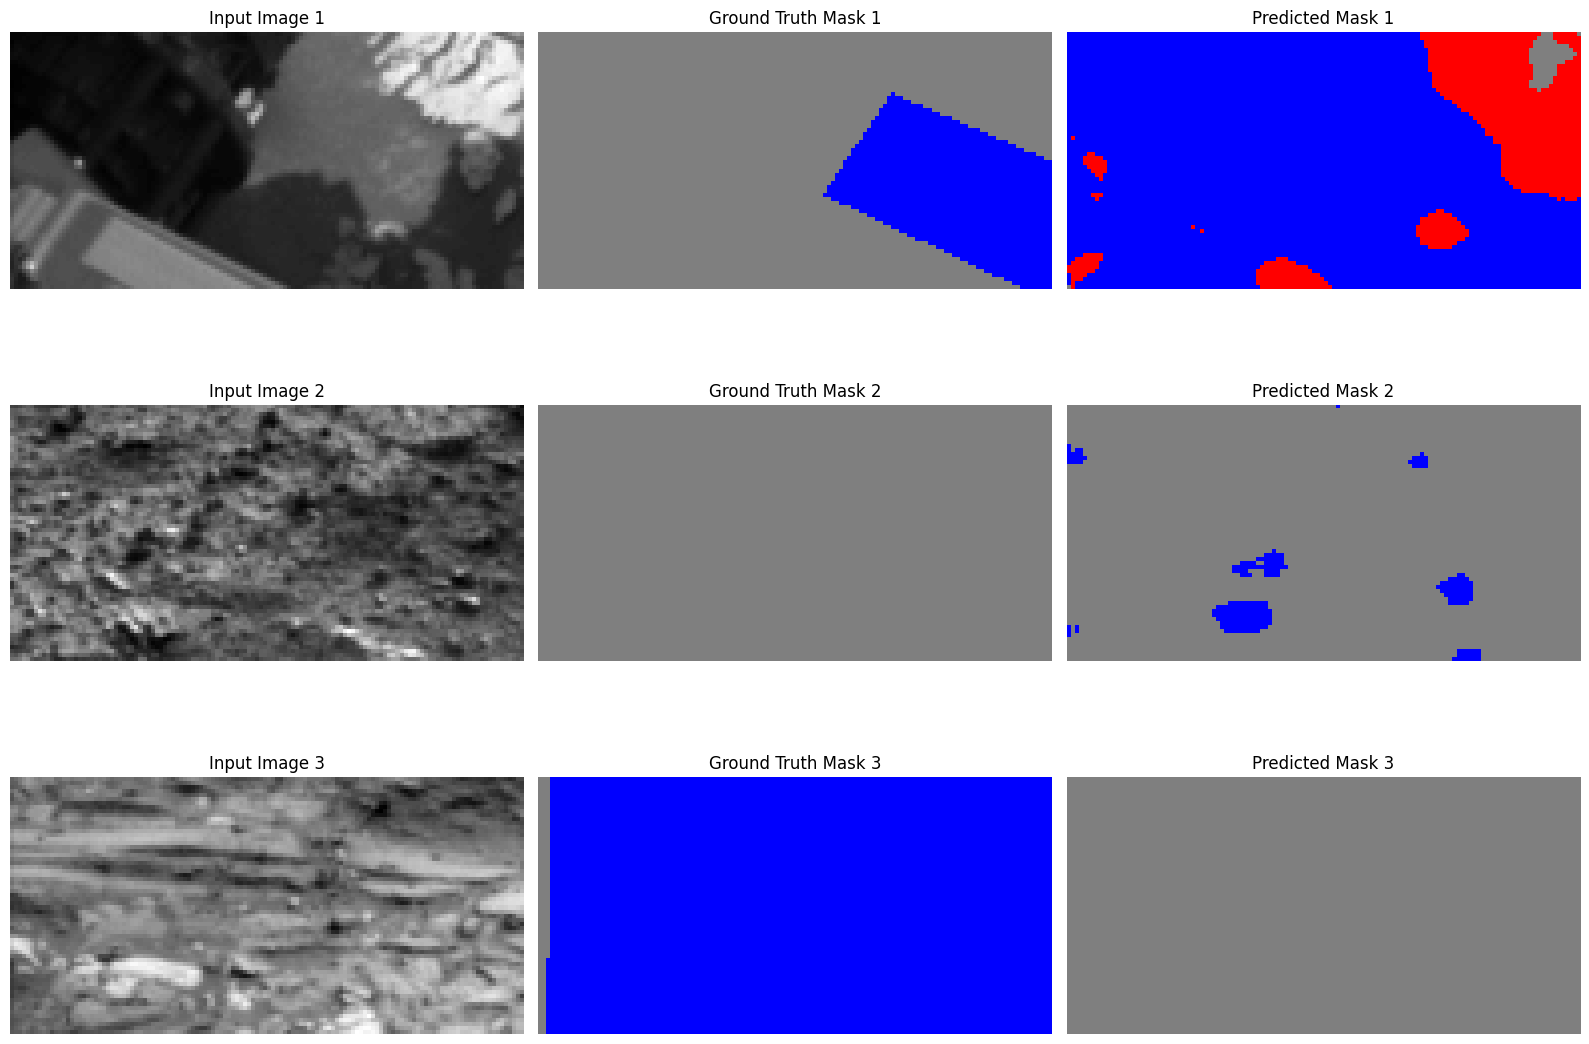

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.7208 - loss: 0.5124 - mean_iou: 0.8754 - val_accuracy: 0.6816 - val_loss: 1.2933 - val_mean_iou: 0.7031 - learning_rate: 3.1250e-05
Epoch 172/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7210 - loss: 0.5115 - mean_iou: 0.8802 - val_accuracy: 0.6813 - val_loss: 1.2506 - val_mean_iou: 0.6983 - learning_rate: 3.1250e-05
Epoch 173/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7207 - loss: 0.5122 - mean_iou: 0.8688 - val_accuracy: 0.6814 - val_loss: 1.2158 - val_mean_iou: 0.6936 - learning_rate: 3.1250e-05
Epoch 174/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7210 - loss: 0.5109 - mean_iou: 0.8763 - val_accuracy: 0.6810 - val_loss: 1.2886 - val_mean_iou: 0.7110 - learning_rate: 3.1250e-05
Epoch 175/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7213 - loss: 0.5099 - mean_iou: 0.8797 - val_accuracy: 0.6804 - val_loss: 1.3151 - val_mean_iou: 0.7020 - learning_rate: 3.1250e-05
Epoch 176

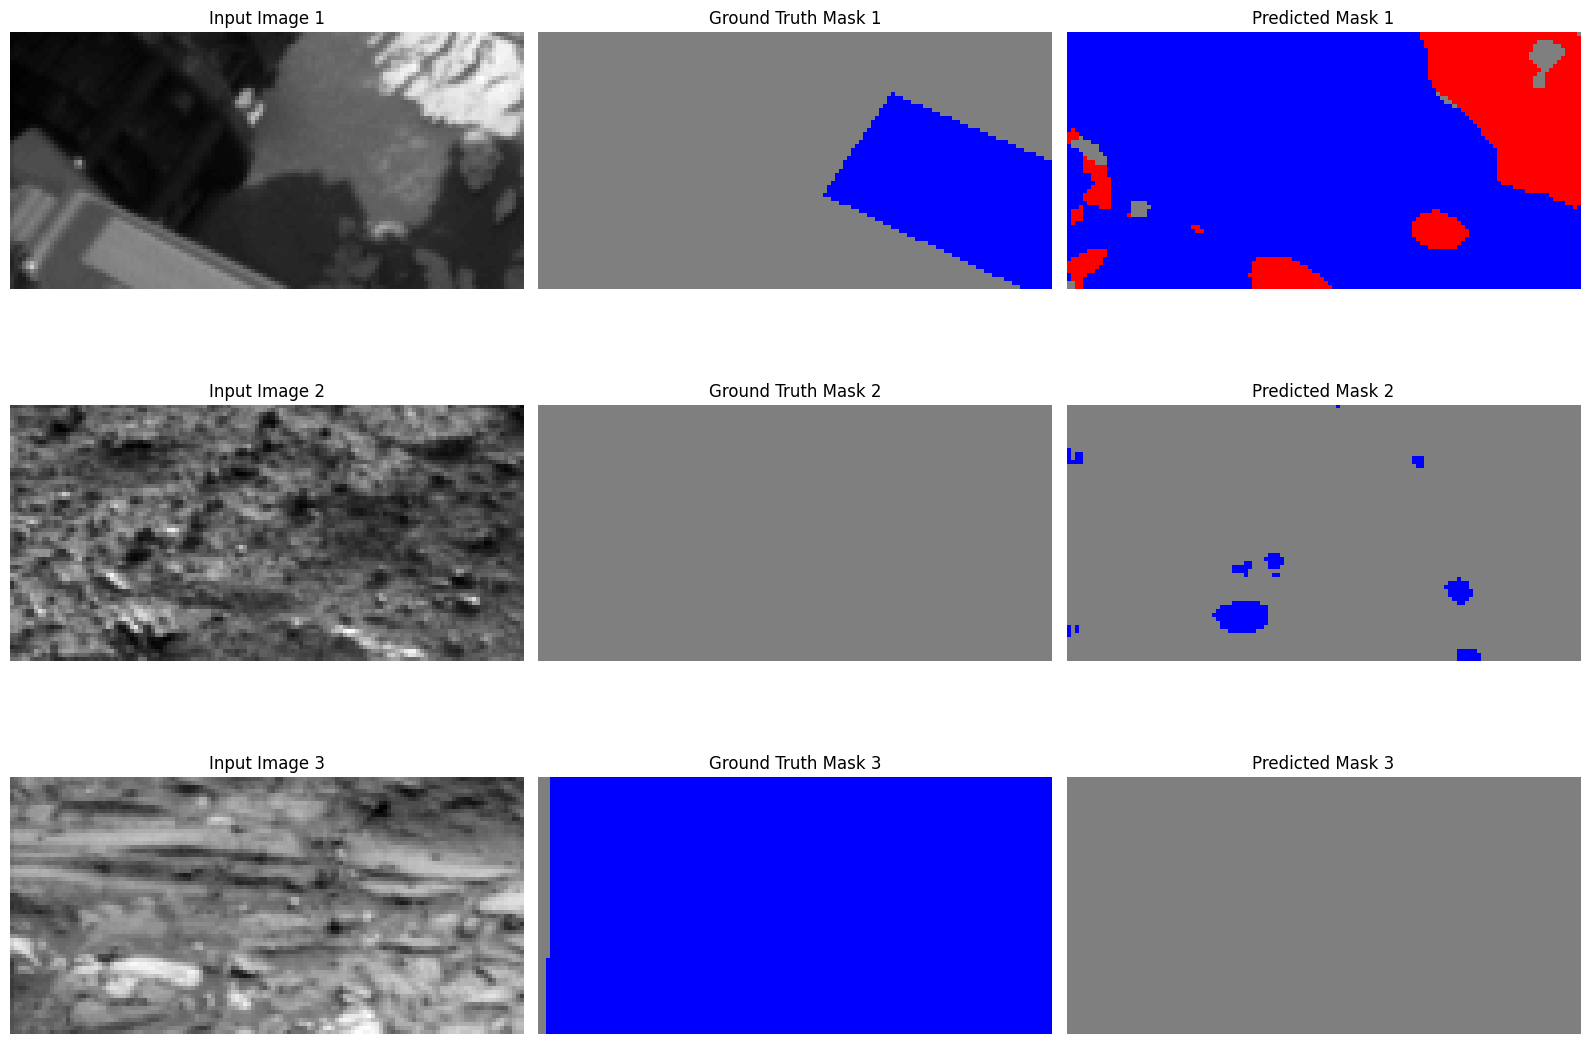

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.7213 - loss: 0.5089 - mean_iou: 0.8771 - val_accuracy: 0.6804 - val_loss: 1.2546 - val_mean_iou: 0.6948 - learning_rate: 3.1250e-05
Epoch 177/500
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.7206 - loss: 0.5098 - mean_iou: 0.8838
Epoch 177: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7212 - loss: 0.5090 - mean_iou: 0.8844 - val_accuracy: 0.6805 - val_loss: 1.3037 - val_mean_iou: 0.6998 - learning_rate: 3.1250e-05
Epoch 178/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7217 - loss: 0.5080 - mean_iou: 0.8822 - val_accuracy: 0.6810 - val_loss: 1.2944 - val_mean_iou: 0.7031 - learning_rate: 1.5625e-05
Epoch 179/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7215 - loss: 0.5079 - mean_iou: 0.8818 - val_accuracy: 0.6806 - val_loss: 1.2922 - val_mean_iou: 0.6966 - learning_rate: 1.5625e-05
Epoch 180/500
32/32 ━━━━━━━━━━━━━━━━━

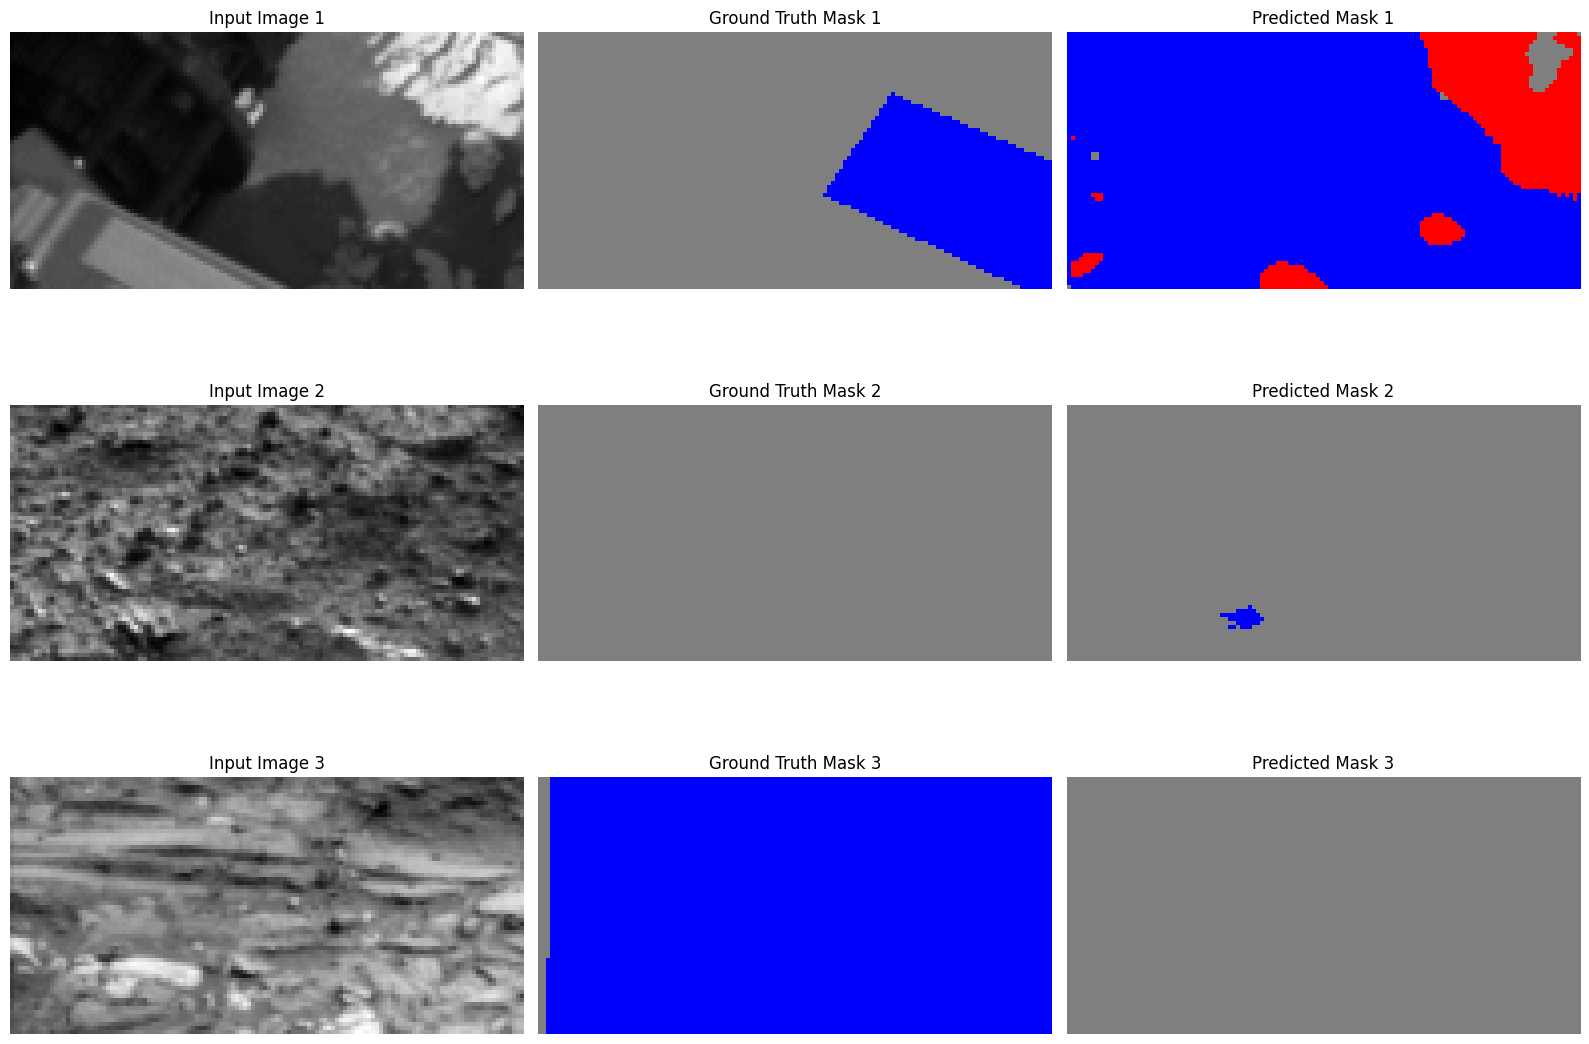

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.7220 - loss: 0.5059 - mean_iou: 0.8830 - val_accuracy: 0.6813 - val_loss: 1.2935 - val_mean_iou: 0.6972 - learning_rate: 1.5625e-05
Epoch 182/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7218 - loss: 0.5054 - mean_iou: 0.8852 - val_accuracy: 0.6815 - val_loss: 1.3255 - val_mean_iou: 0.7004 - learning_rate: 1.5625e-05
Epoch 183/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7220 - loss: 0.5061 - mean_iou: 0.8882 - val_accuracy: 0.6816 - val_loss: 1.3015 - val_mean_iou: 0.7037 - learning_rate: 1.5625e-05
Epoch 184/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7223 - loss: 0.5049 - mean_iou: 0.8868 - val_accuracy: 0.6813 - val_loss: 1.2960 - val_mean_iou: 0.7013 - learning_rate: 1.5625e-05
Epoch 185/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7222 - loss: 0.5041 - mean_iou: 0.8881 - val_accuracy: 0.6816 - val_loss: 1.3025 - val_mean_iou: 0.7017 - learning_rate: 1.5625e-05
Epoch 186

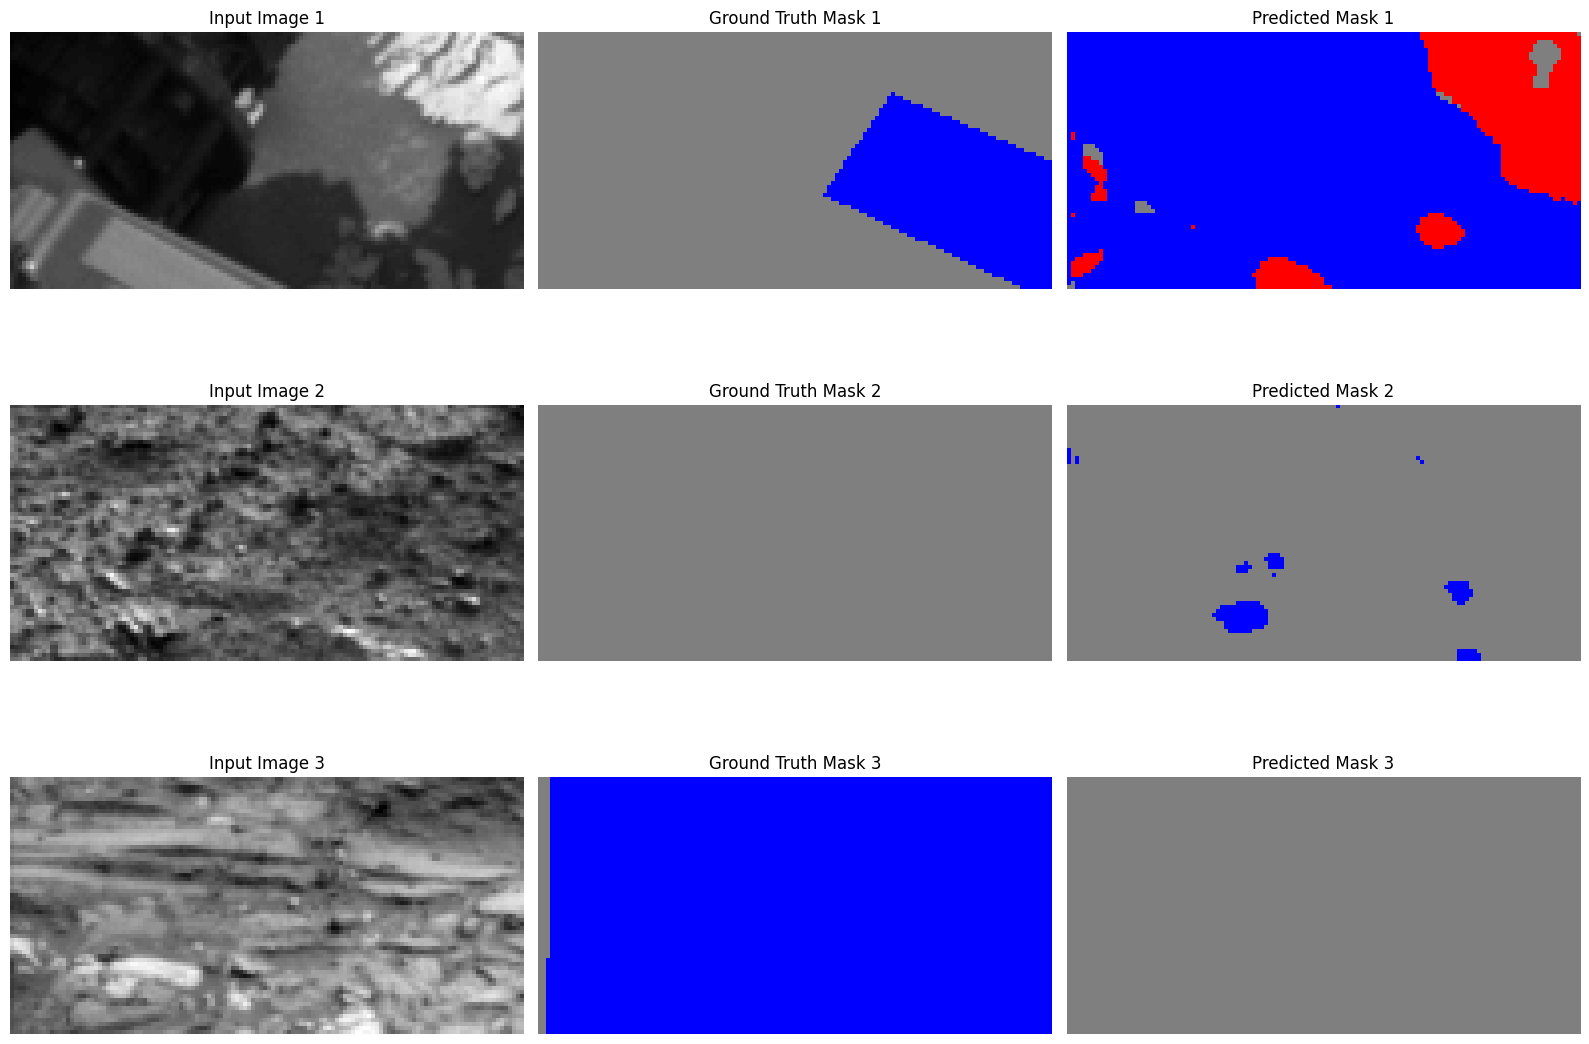

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.7224 - loss: 0.5037 - mean_iou: 0.8911 - val_accuracy: 0.6815 - val_loss: 1.3069 - val_mean_iou: 0.6992 - learning_rate: 1.5625e-05
Epoch 187/500
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.7215 - loss: 0.5047 - mean_iou: 0.8881
Epoch 187: ReduceLROnPlateau reducing learning rate to 1e-05.
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.7222 - loss: 0.5040 - mean_iou: 0.8888 - val_accuracy: 0.6814 - val_loss: 1.3116 - val_mean_iou: 0.7020 - learning_rate: 1.5625e-05
Epoch 188/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7224 - loss: 0.5033 - mean_iou: 0.8874 - val_accuracy: 0.6819 - val_loss: 1.3062 - val_mean_iou: 0.7033 - learning_rate: 1.0000e-05
Epoch 189/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7223 - loss: 0.5029 - mean_iou: 0.8851 - val_accuracy: 0.6812 - val_loss: 1.3058 - val_mean_iou: 0.7043 - learning_rate: 1.0000e-05
Epoch 190/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step

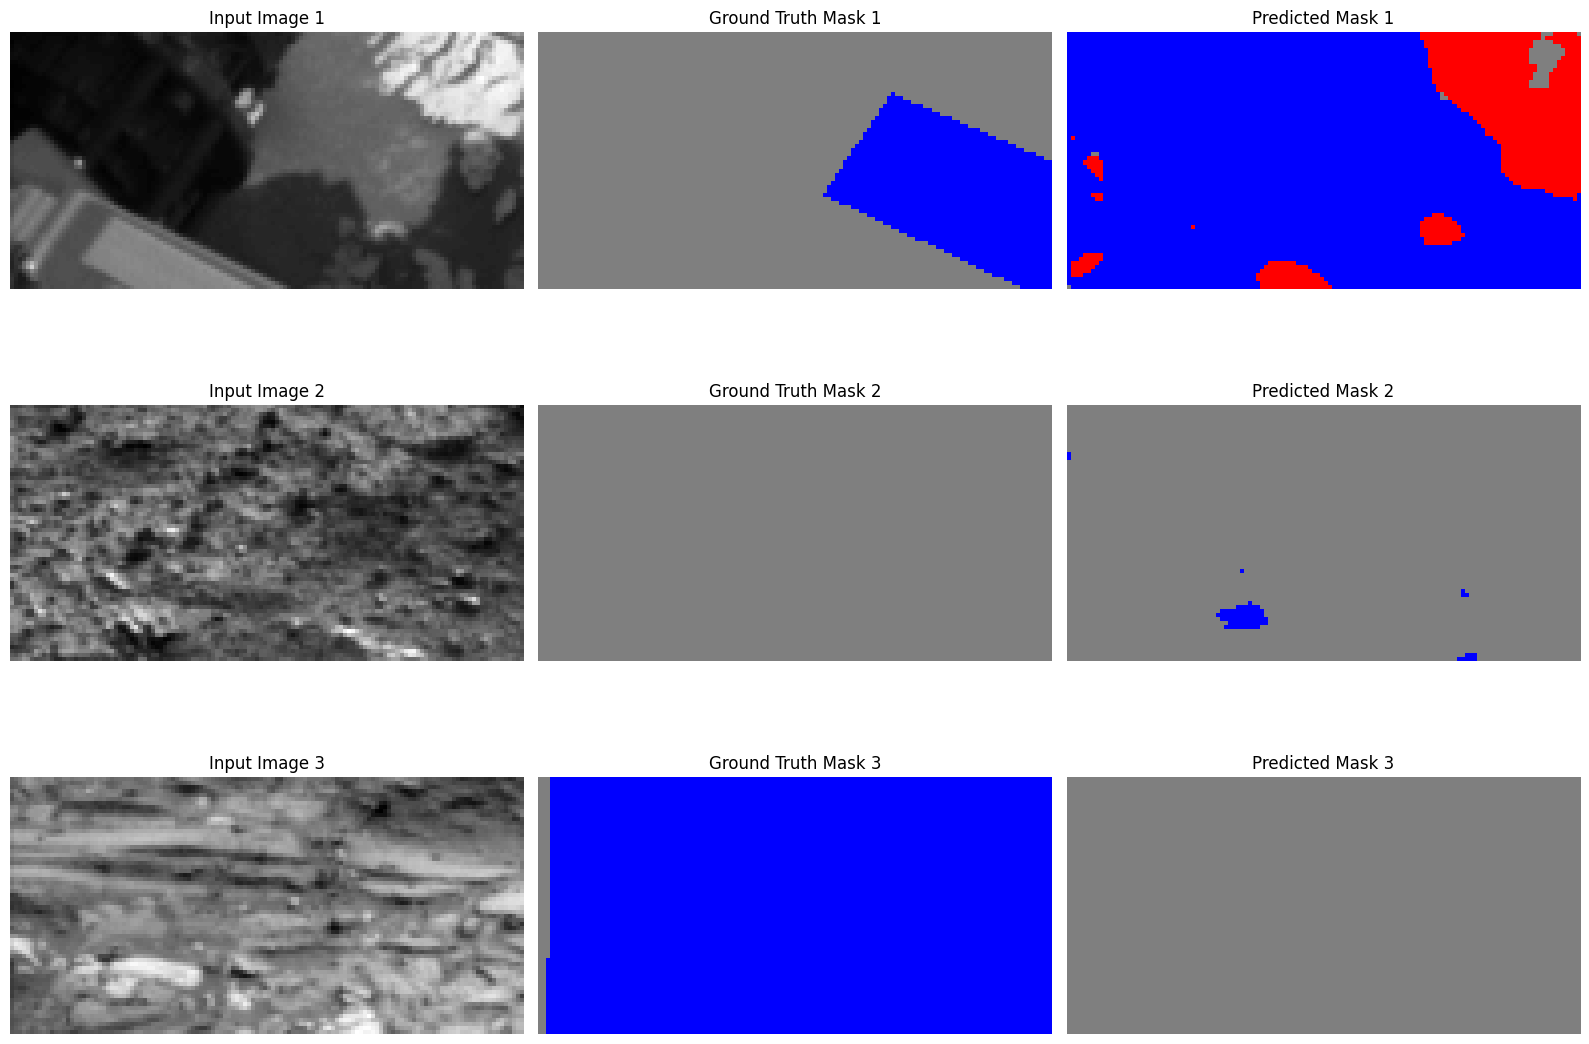

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.7225 - loss: 0.5027 - mean_iou: 0.8880 - val_accuracy: 0.6818 - val_loss: 1.3070 - val_mean_iou: 0.7049 - learning_rate: 1.0000e-05
Epoch 192/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7224 - loss: 0.5027 - mean_iou: 0.8881 - val_accuracy: 0.6817 - val_loss: 1.2714 - val_mean_iou: 0.7000 - learning_rate: 1.0000e-05
Epoch 193/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7224 - loss: 0.5027 - mean_iou: 0.8862 - val_accuracy: 0.6815 - val_loss: 1.3010 - val_mean_iou: 0.7079 - learning_rate: 1.0000e-05
Epoch 194/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7225 - loss: 0.5020 - mean_iou: 0.8885 - val_accuracy: 0.6819 - val_loss: 1.3208 - val_mean_iou: 0.7082 - learning_rate: 1.0000e-05
Epoch 195/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7225 - loss: 0.5018 - mean_iou: 0.8888 - val_accuracy: 0.6819 - val_loss: 1.3211 - val_mean_iou: 0.7030 - learning_rate: 1.0000e-05
Epoch 196

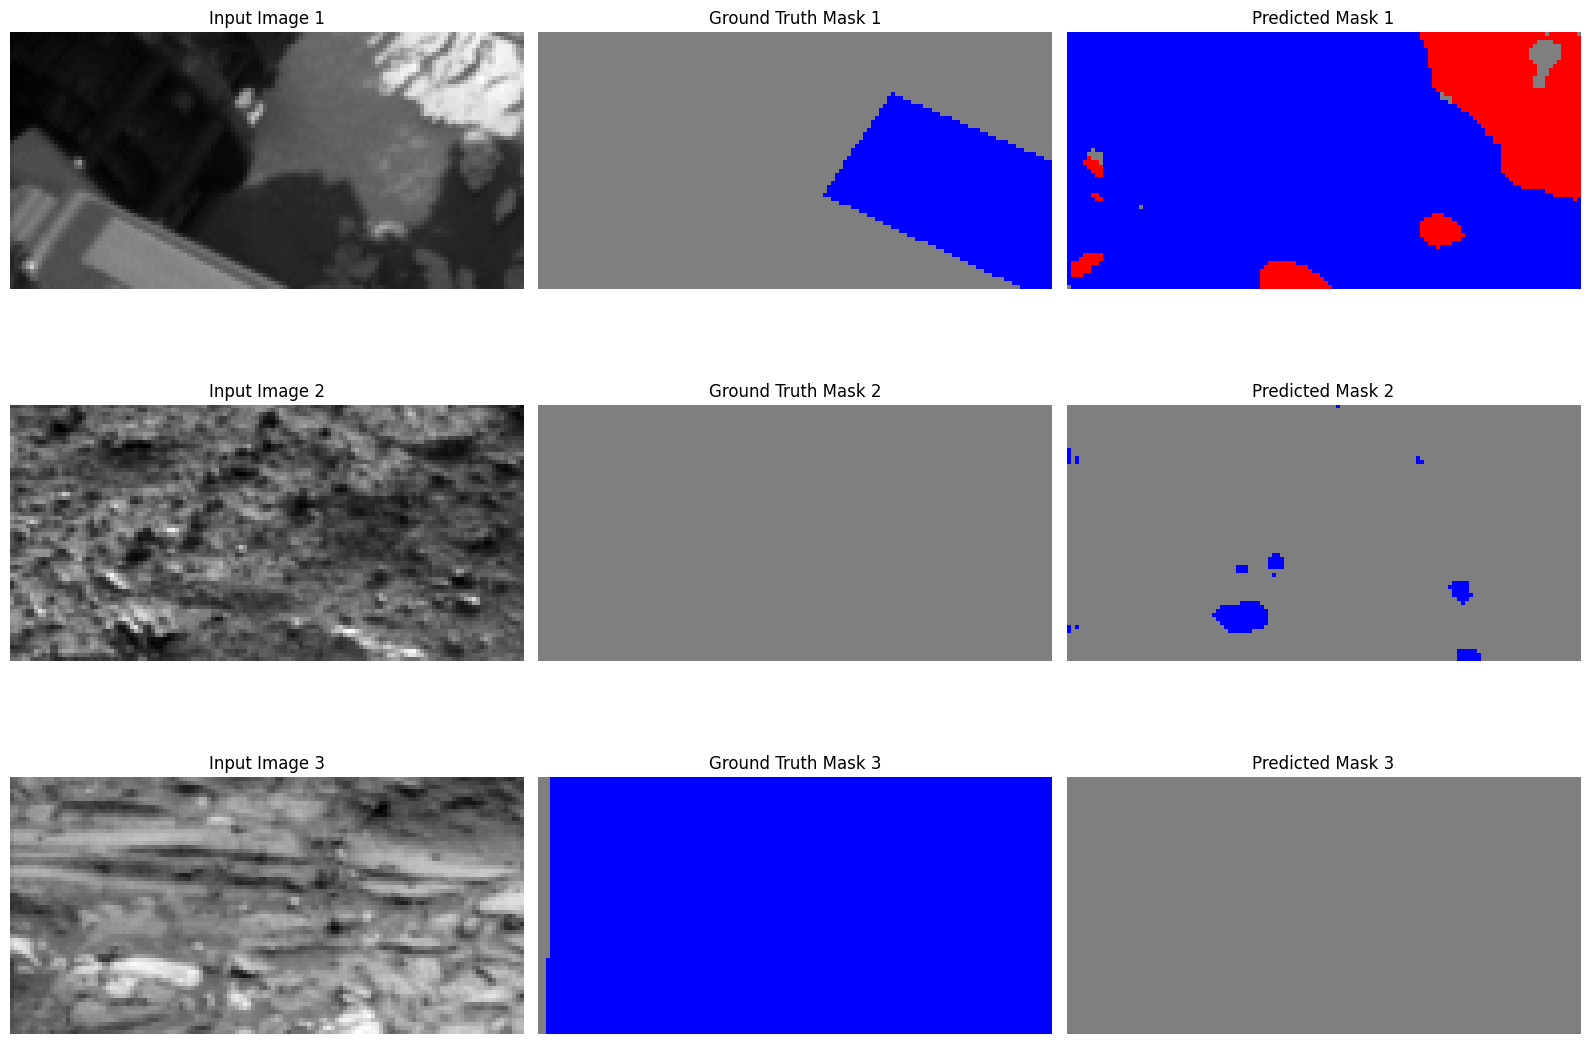

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.7227 - loss: 0.5011 - mean_iou: 0.8908 - val_accuracy: 0.6815 - val_loss: 1.3140 - val_mean_iou: 0.7068 - learning_rate: 1.0000e-05
Epoch 197/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7226 - loss: 0.5010 - mean_iou: 0.8896 - val_accuracy: 0.6818 - val_loss: 1.3025 - val_mean_iou: 0.7019 - learning_rate: 1.0000e-05
Final validation Mean Intersection Over Union: 71.39%
Model saved to model_241214_143341.keras


In [104]:
history = model.fit(

    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback, reduce_lr],
    verbose=1

).history



# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')


timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)


print(f"Model saved to {model_filename}")

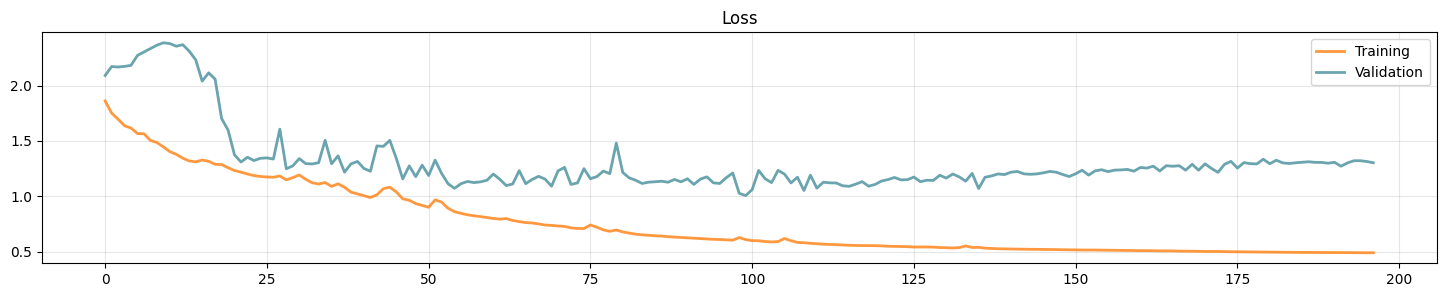

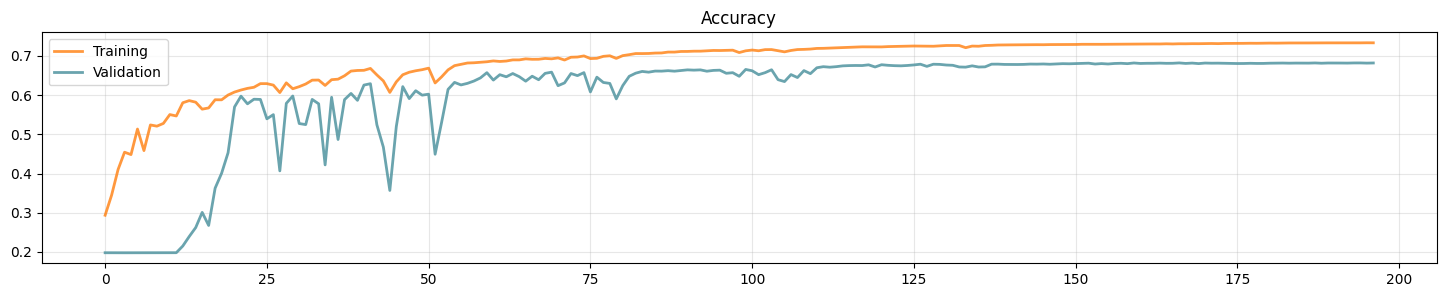

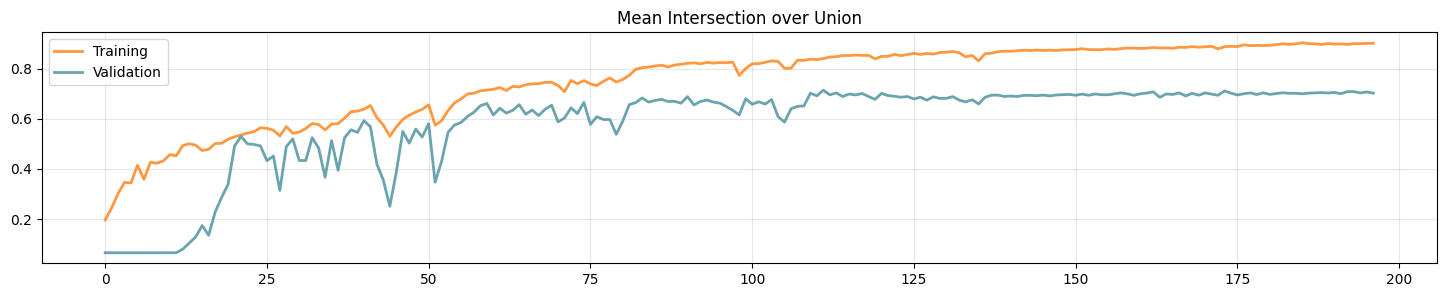

In [105]:

# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 🔍 Make Inference

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
(501, 64, 128, 5)
(501, 64, 128)
(4104192,)
(4104192,)


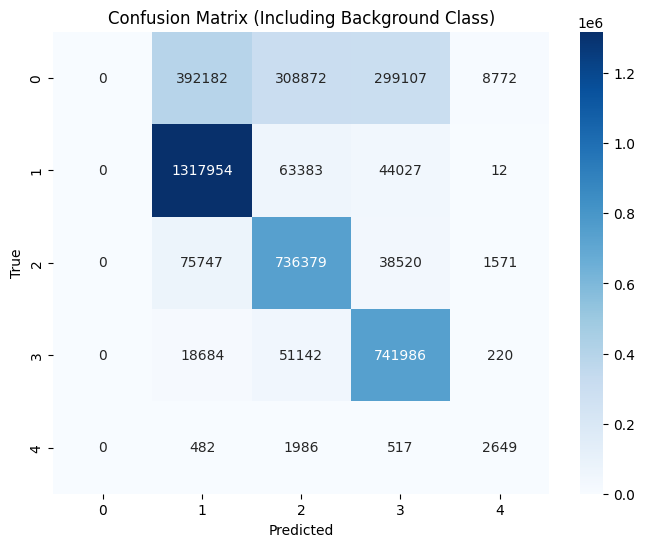

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
(2004, 64, 128, 5)
(2004, 64, 128)
(16416768,)
(16416768,)


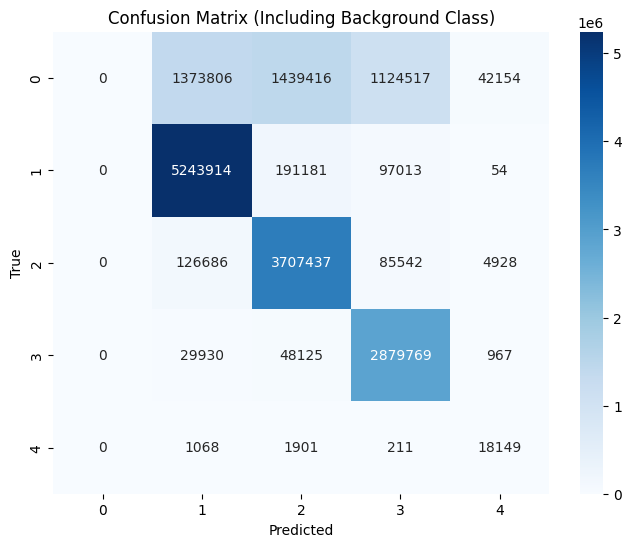

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Esegui la previsione sul set di validazione
y_pred = model.predict(X_val)  # Previsioni sui dati di validazione
y_true = y_val  # Etichette reali di validazione

print(y_pred.shape)
print(y_true.shape)

# Supponiamo che y_pred siano le predizioni del modello e y_true siano le etichette reali
y_pred_labels = np.argmax(y_pred, axis=-1)  # Predizioni finali come etichette
y_true_labels = y_true

# Appiattisci le variabili per la matrice di confusione
y_pred_flat = y_pred_labels.flatten()  # Predizioni piatte
y_true_flat = y_true_labels.flatten()  # Etichette reali piatte

print(y_pred_flat.shape)
print(y_true_flat.shape)

# Calcola la matrice di confusione includendo la classe 0
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=np.arange(0, num_classes))  # Includi la classe 0

# Plot della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(0, num_classes), yticklabels=np.arange(0, num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Including Background Class)')
plt.show()



# Esegui la previsione sul set di validazione
y_pred = model.predict(X_train)  # Previsioni sui dati di validazione
y_true = y_train  # Etichette reali di validazione

print(y_pred.shape)
print(y_true.shape)

# Supponiamo che y_pred siano le predizioni del modello e y_true siano le etichette reali
y_pred_labels = np.argmax(y_pred, axis=-1)  # Predizioni finali come etichette
y_true_labels = y_true

# Appiattisci le variabili per la matrice di confusione
y_pred_flat = y_pred_labels.flatten()  # Predizioni piatte
y_true_flat = y_true_labels.flatten()  # Etichette reali piatte

print(y_pred_flat.shape)
print(y_true_flat.shape)

# Calcola la matrice di confusione includendo la classe 0
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=np.arange(0, num_classes))  # Includi la classe 0

# Plot della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(0, num_classes), yticklabels=np.arange(0, num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Including Background Class)')
plt.show()


## 📊 Prepare Submission


In [107]:
preds = model.predict(X_test)

del model

preds = np.argmax(preds, axis=-1)

314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


In [108]:
def y_to_df(y) -> pd.DataFrame:

    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [109]:

# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)
